<div class="alert alert-block alert-info">
    <b>Projet 4 | Anticipez les besoins en consommation électrique de bâtiments<br>
    Partie 1 |  Nettoyage et préparation des données</b>
</div>

# 1 | Présentation du projet

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

<img src="logo_seattle.png" style="width:500px;height:200px"/>

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

L'objectif de cette première partie est de réaliser une courte analyse exploratoire et d'isoler les variables à retenir ou d'en créer de nouvelles.

# 2 | Import des packages, fonctions et paramétrage initial

On réinitialise les variables du notebook :

In [1]:
%reset -f

## 2.1 | Fonctions utiles au projet 

Fonctions utiles au projet : 

In [2]:
valueTobeRemoved = 'builtins'
import types
# Fonction qui liste les packages chargés
def imports():
    for name, val in globals().items():
        try:
            if isinstance(val, types.ModuleType):
                yield val.__name__
        except:
            continue
            
package_list = list(imports())
package_list = [value for value in package_list if value != valueTobeRemoved]

# Fonction qui vérifie si un site web est en cours (renvoie 200 si OK)
def url_ok(url):
    """Function testing if URL can be accessed, parameter = URl string"""
    request = urllib.request.Request(url)
    request.get_method = lambda: 'HEAD'
    try:
        urllib.request.urlopen(request)
        return True
    except urllib.request.HTTPError:
        return False

# fonction pour comparer les jeux de colonne entre deux DataFrames
# et qui renvoie les colonnes présentes uniquement dans chacun des deux df.
def column_comparator(df1,df2):
    columns_1 = list(df1.columns) 
    columns_2 = list(df2.columns)
    diff_columns_1=[]
    diff_columns_2=[]

    for col in columns_2:
        if col in columns_1:
            continue
        else:
            diff_columns_2.append(col)
    for col in columns_1:
        if col not in columns_2:
            diff_columns_1.append(col)
    return diff_columns_1, diff_columns_2

## 2.2 | Vérification de la version de Python

In [3]:
!python -V

Python 3.7.0


## 2.3 | Installation des nouveaux packages nécessaires

In [4]:
%pip install folium
# folium makes it easy to visualize data that’s been manipulated in Python
# on an interactive leaflet map. It enables both the binding of data to a map
# for choropleth visualizations as well as passing rich vector/raster/HTML
# visualizations as markers on the map.

%pip install bs4
# Beautiful Soup is a Python library for pulling data out of HTML and XML files.
# It works with your favorite parser to provide idiomatic ways of navigating,
# searching, and modifying the parse tree.
# It commonly saves programmers hours or days of work.

%pip install geopy
# geopy is a Python client for several popular geocoding web services.
# geopy makes it easy for Python developers to locate the coordinates of addresses,
# cities, countries, and landmarks across the globe using third-party
# geocoders and other data sources.

%pip install shapely
# Shapely is a Python package for set-theoretic analysis and manipulation of planar features
# using (via Python's ctypes module) functions from the well known and widely deployed
# GEOS library. GEOS, a port of the Java Topology Suite (JTS), is the geometry engine 
# of the PostGIS spatial extension for the PostgreSQL RDBMS.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2.4 | Import des packages utiles au projet

In [5]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import missingno as msno
import scipy.stats as stats

# Mathématiques
import math


# Manipulation fichiers et Interaction avec l'os / notebook
import os
import csv
import requests
import warnings

# Manipulation de chaines de caractères
from ast import literal_eval #abstract syntax tree
from bs4 import BeautifulSoup as soup

# Données géographiques et géométriques
import geopy
from geopy.distance import geodesic
import re
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
import folium
import folium.plugins

# Manipulations temporelles
from tqdm import tqdm
from tqdm.notebook import tqdm, trange
import time

# Extraction web
from urllib.request import urlopen as uReq # Web client
import urllib.request # Web client
from importlib_metadata import version

# Feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## 2.5 | Vérification des versions de package installées

In [6]:
print("package : version")
print("-"*28)

for p in package_list:
    try:
        print(p, " : ", eval(f"version('{p}')"))
    except:
        continue

package : version
----------------------------


## 2.6 | Mise en page et réglages divers du notebook

In [7]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

#Affichage avec la bibliothèque graphique intégrée à Notebook:
%matplotlib inline

#Format des graphiques seaborn
sns.set_theme(style="whitegrid")

# 3 | Chargement et préparation des données | Step 0

## 3.1 | Chargement des données 2015 et 2016

On charge les données :

In [8]:
data_2015 = pd.read_csv("2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("2016-building-energy-benchmarking.csv")

In [9]:
descr_2015 = pd.read_csv("descriptions_2015.csv", sep = ';', error_bad_lines=False)
descr_2016 = pd.read_csv("descriptions_2016.csv", sep = ';', error_bad_lines=False)

In [10]:
descr = pd.merge(descr_2015, descr_2016, how="outer", on="Column Name")

In [11]:
descr_2015.head(3)

Column Name  \
0  OSEBuildingID   
1       DataYear   
2   BuildingType   

                                                                                                                             Description  \
0  A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.   
1                                                                                                                                    NaN   
2                                                                                          City of Seattle building type classification.   

         Type  Column4  
0      Number      NaN  
1  Plain Text      NaN  
2  Plain Text      NaN

In [12]:
descr_2016.head(3)

Column Name  \
0  OSEBuildingID   
1       DataYear   
2   BuildingType   

                                                                                                                             Description  \
0  A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.   
1                                                                      Calendar year (January-December) represented by each data record.   
2                                                                                          City of Seattle building type classification.   

         Type  Column4  
0      Number      NaN  
1      Number      NaN  
2  Plain Text      NaN

In [13]:
descr.head(3)

Column Name  \
0  OSEBuildingID   
1       DataYear   
2   BuildingType   

                                                                                                                           Description_x  \
0  A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.   
1                                                                                                                                    NaN   
2                                                                                          City of Seattle building type classification.   

       Type_x  Column4_x  \
0      Number        NaN   
1  Plain Text        NaN   
2  Plain Text        NaN   

                                                                                                                           Description_y  \
0  A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.   
1                                                                      Calendar year (January-December) represented by each data record.   
2                                                                                          City of Seattle building type classification.   

       Type_y  Column4_y  
0      Number        NaN  
1      Number        NaN  
2  Plain Text        NaN

In [14]:
data_2015.head(3)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   

           PropertyName TaxParcelIdentificationNumber  \
0  MAYFLOWER PARK HOTEL                     659000030   
1       PARAMOUNT HOTEL                     659000220   
2          WESTIN HOTEL                     659000475   

                                                                                                                                                       Location  \
0  {'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   
1    {'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   
2   {'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}   

   CouncilDistrictCode Neighborhood  YearBuilt  NumberofBuildings  \
0                    7     DOWNTOWN       1927                  1   
1                    7     DOWNTOWN       1996                  1   
2                    7     DOWNTOWN       1969                  1   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0            12.0             88434                   0   
1            11.0            103566               15064   
2            41.0            961990                   0   

   PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   88434                          Hotel   
1                   88502     Hotel, Parking, Restaurant   
2                  961990  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   757243.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                      Parking                         100000.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             65.0              78.9   
1                      NaN             51.0              94.4   
2                      NaN             18.0              96.6   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                80.3               173.5                 175.1   
1                99.0               191.3                 195.2   
2                99.7               242.7                 246.5   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            6981428.0              7097539.0       2023032.0   
1            8354235.0              8765788.0             0.0   
2           73130656.0             75506272.0      19660404.0   

   Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
0         1080307.0          3686160.0             12724.0         1272388.0   
1         1144563.0          3905411.0             44490.0         4448985.0   
2        14583930.0         49762435.0             37099.0         3709900.0   

   OtherFuelUse(kBtu)  GHGEmissions(MetricTonsCO2e)  \
0                 0.0                        249.43   
1                 0.0                        263.51   
2                 0.0                       2061.48   

   GHGEmissionsIn

In [15]:
data_2016.head(3)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   

   PropertyGFAParking  PropertyGFABuilding(s)   ListOfAllPropertyUseTypes  \
0                   0                   88434                       Hotel   
1               15064                   88502  Hotel, Parking, Restaurant   
2              196718                  759392                       Hotel   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   
2           72587024.0             73937112.0      21566554.0   

   Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
0      1.156514e+06          3946027.0         12764.52930         1276453.0   
1      9.504252e+05          3242851.0         51450.81641         5145082.0   
2      1.451544e+07         49526664.0         14938.00000         1493800.0   

   DefaultData  Comments ComplianceStatus Outlier  TotalGHGEmissions  \
0        False       NaN        Compliant     NaN             249.98   
1        False       NaN        Compliant     NaN             295.86   
2        False       NaN        Compliant     NaN            2089.28   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19

In [16]:
print(f"""
     data_2015 : {data_2015.shape},
     data_2016 : {data_2016.shape}""")


     data_2015 : (3340, 47),
     data_2016 : (3376, 46)


## 3.2 | Split des données de la colonne 'Location'

Sur le fichier de 2015, on trouve 6 données différentes concaténées en une seule variable 'Location'.<br>
Nous allons devoir diviser cette cellule pour pouvoir comparer les fichiers 2015 et 2016 en vue de les concaténer.

data_2015 | Split des données de localisation

In [17]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

Cette ligne ressemble à du code Python. 

La méthode **ast.literal_eval** est une fonction qui aide à traverser un arbre syntaxique abstrait. Cette fonction évalue un nœud d'expression ou une chaîne composée d'une expression littérale Python ou d'un affichage de conteneur.

On utilise donc 'ast.literal_eval' pour splitter les valeurs de cette colonne:

In [18]:
data_2015['Location'].map(literal_eval).apply(pd.Series).head(3)

latitude      longitude  \
0  47.61219025  -122.33799744   
1  47.61310583  -122.33335756   
2  47.61334897  -122.33769944   

                                                                    human_address  
0  {"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}  
1    {"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}  
2   {"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}

Cela fonctionne, latitude et longitude sont maintenant traités comme des colonnes à part. Nous allons pouvoir réaliser l'opération de split sur l'ensemble du jeu de données data_2015. Nous renouvelons l'opération sur le champ 'human adress' qui est lui aussi compacté.

In [19]:
data_2015= pd.concat([data_2015.drop(columns=['Location']),data_2015['Location']
                               .map(literal_eval).apply(pd.Series)],axis=1)
data_2015 = pd.concat([data_2015.drop(columns=['human_address']), data_2015['human_address']
                               .map(literal_eval).apply(pd.Series)], axis=1)

In [20]:
data_2015.head(3)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   

           PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0  MAYFLOWER PARK HOTEL                     659000030                    7   
1       PARAMOUNT HOTEL                     659000220                    7   
2          WESTIN HOTEL                     659000475                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 175.1            6981428.0              7097539.0   
1                 195.2            8354235.0              8765788.0   
2                 246.5           73130656.0             75506272.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0       2023032.0         1080307.0          3686160.0             12724.0   
1             0.0         1144563.0          3905411.0             44490.0   
2      19660404.0        14583930.0         49762435.0             37099.0   

   NaturalGas(kBtu)  OtherFuelUse(kBtu)  GHGEmissions(MetricTonsCO2e)  \
0         1272388.0                 0.0                        249.43   
1         4448985.0                 0.0                        263.51   
2         3709900.0                 0.0                       2061.48   

   GHGEmissionsIntensity(kgCO2e/ft2) DefaultData Comment ComplianceStatus  \
0                               2.64          No     NaN        Compliant   
1                               2.38          No     NaN        Compliant   
2                               1.92         Yes     NaN        Compliant   

  Outlier  2010 Census Tracts  \
0     NaN                 NaN   
1     NaN                 NaN   
2     NaN                 NaN   

   Seattle Police Department Micro Community Policing Plan Areas  \
0                                                           14.0   
1                                                           14.0   
2                                            

Vérifions le format des colonnes numériques rajoutées :

In [21]:
data_2015[['latitude','longitude','zip']].dtypes

latitude     object
longitude    object
zip          object
dtype: object

Corrigeons le format de ces 3 colonnes en numerique

In [22]:
data_2015["zip"] = pd.to_numeric(data_2015["zip"])
data_2015["latitude"] = pd.to_numeric(data_2015["latitude"])
data_2015["longitude"] = pd.to_numeric(data_2015["longitude"])

In [23]:
data_2015[['latitude','longitude','zip']].dtypes

latitude     float64
longitude    float64
zip            int64
dtype: object

Passer le ZipCode en catégoriel

## 3.3 | Normalisation des colonnes 2015 et 2016 et merge | Step 0

### 3.3.1 | Affichage des colonnes en écart entre data_2015 et data_2016

In [24]:
print(data_2015.shape)
print(data_2016.shape)

(3340, 52)
(3376, 46)


On n'a pas le même nombre de colonnes d'une année à l'autre. Vérifions si les intitulés diffèrent également.

In [25]:
only_2015_columns, only_2016_columns = column_comparator(data_2015,data_2016)

In [26]:
only_2015_columns

['OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes',
 'latitude',
 'longitude',
 'address',
 'city',
 'state',
 'zip']

In [27]:
only_2016_columns

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

Normalisons les titres de colonnes pour pouvoir les concaténer avec 2016:

In [28]:
data_2015 = data_2015.rename(columns={"latitude":"Latitude", "longitude":"Longitude",
                                      "address":"Address", "city":"City", 
                                      "state":"State", "zip":"ZipCode"})

In [29]:
print(data_2015.shape)
print(data_2016.shape)

(3340, 52)
(3376, 46)


Alignement des colonnes entre les 2 jeux de données:

Unifier comments

In [30]:
only_2015_columns, only_2016_columns = column_comparator(data_2015,data_2016)

In [31]:
only_2015_columns

['OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [32]:
only_2016_columns

['Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

### 3.3.2 | Ajustement colonnes data_2015

In [33]:
data_2015.head(3)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   

           PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0  MAYFLOWER PARK HOTEL                     659000030                    7   
1       PARAMOUNT HOTEL                     659000220                    7   
2          WESTIN HOTEL                     659000475                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 175.1            6981428.0              7097539.0   
1                 195.2            8354235.0              8765788.0   
2                 246.5           73130656.0             75506272.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0       2023032.0         1080307.0          3686160.0             12724.0   
1             0.0         1144563.0          3905411.0             44490.0   
2      19660404.0        14583930.0         49762435.0             37099.0   

   NaturalGas(kBtu)  OtherFuelUse(kBtu)  GHGEmissions(MetricTonsCO2e)  \
0         1272388.0                 0.0                        249.43   
1         4448985.0                 0.0                        263.51   
2         3709900.0                 0.0                       2061.48   

   GHGEmissionsIntensity(kgCO2e/ft2) DefaultData Comment ComplianceStatus  \
0                               2.64          No     NaN        Compliant   
1                               2.38          No     NaN        Compliant   
2                               1.92         Yes     NaN        Compliant   

  Outlier  2010 Census Tracts  \
0     NaN                 NaN   
1     NaN                 NaN   
2     NaN                 NaN   

   Seattle Police Department Micro Community Policing Plan Areas  \
0                                                           14.0   
1                                                           14.0   
2                                            

In [34]:
print('la colonne OtherFuelUse(kBtu) contient',data_2015[data_2015["OtherFuelUse(kBtu)"]>0].shape[0],'lignes au total')

la colonne OtherFuelUse(kBtu) contient 17 lignes au total


Nous pouvons supprimer la colonne en question, les données, trop peu présentes en 2015 et absentes en 2016, ne seront pas exploitables.

In [35]:
data_2015.drop("OtherFuelUse(kBtu)", axis=1, inplace=True)

On renomme la colonne 'GHGEmissions(MetricTonsCO2e)' qui contient en fait les chiffres de la colonne 'TotalGHGEmissions' de data_2016 (vérification effectuée sur les premières lignes).

In [36]:
data_2015 = data_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions"})

Même constat pour la colonne ''GHGEmissionsIntensity(kgCO2e/ft2)' qui correspond aux données de la colonne 'GHGEmissionsIntensity' de data_2016.

In [37]:
data_2015 = data_2015.rename(columns={"GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity"})

In [38]:
print('la colonne "'"Comment"'" contient',data_2015[~data_2015["Comment"].isnull()].shape[0],'lignes au total')

la colonne "Comment" contient 13 lignes au total


In [39]:
data_2015.drop("Comment", axis=1, inplace=True)

In [40]:
print('la colonne "'"2010 Census Tracts"'" contient',data_2015[~data_2015["2010 Census Tracts"].isnull()].shape[0],'lignes au total')

la colonne "2010 Census Tracts" contient 224 lignes au total


In [41]:
data_2015["2010 Census Tracts"].unique()

array([ nan, 124., 116., 123., 134., 131., 127., 117., 129., 135., 119.,
       118., 122., 125.])

Les données de "2010 Census Tracts" ne semblent pas utiles et relativement peu nombreuses. Nous les supprimons.

In [42]:
data_2015.drop("2010 Census Tracts", axis=1, inplace=True)

'Zip Codes' ne montre pas des valeurs cohérentes avec 2016. On supprimera cette colonne et conservera 'ZipCode' sans espace, qui elle proposera les mêmes valeurs qu'en 2016.

In [43]:
data_2015.drop("Zip Codes", axis=1, inplace=True)

Les colonnes restantes : 'City Council Districts' et 'SPD Beats'ne sont pas présentes en 2016 et ne pourront pas être exploitées, nous les supprimons.

In [44]:
data_2015.drop("City Council Districts", axis=1, inplace=True)
data_2015.drop("SPD Beats", axis=1, inplace=True)
data_2015.drop("Seattle Police Department Micro Community Policing Plan Areas", axis=1, inplace=True)

### 3.3.3 | Ajustement colonnes data_2016

In [45]:
data_2016.head(3)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   

              PropertyName          Address     City State  ZipCode  \
0     Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1          Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2  5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   

   PropertyGFAParking  PropertyGFABuilding(s)   ListOfAllPropertyUseTypes  \
0                   0                   88434                       Hotel   
1               15064                   88502  Hotel, Parking, Restaurant   
2              196718                  759392                       Hotel   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   

   SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            7226362.5              7456910.0       2003882.0   
1            8387933.0              8664479.0             0.0   
2           72587024.0             73937112.0      21566554.0   

   Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  \
0      1.156514e+06          3946027.0         12764.52930         1276453.0   
1      9.504252e+05          3242851.0         51450.81641         5145082.0   
2      1.451544e+07         49526664.0         14938.00000         1493800.0   

   DefaultData  Comments ComplianceStatus Outlier  TotalGHGEmissions  \
0        False       NaN        Compliant     NaN             249.98   
1        False       NaN        Compliant     NaN             295.86   
2        False       NaN        Compliant     NaN            2089.28   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
2                   2.19

In [46]:
data_2016 = data_2016.drop(['Comments'], axis=1)

### 3.3.4 | Vérification des colonnes et merge de data_2015 et data_2016 | Step 0

On vérifie que les colonnes sont bien identiques en rejouant la fonction 'column_comparator' :

In [47]:
only_2015_columns, only_2016_columns = column_comparator(data_2015,data_2016)

In [48]:
only_2015_columns

[]

In [49]:
only_2016_columns

[]

On regroupe les données des 2 années en un jeu unique qu'on appellera dorénavant 'data' :

In [50]:
data = pd.concat([data_2015[data_2016.columns],data_2016], 
                 axis = 0, copy=False).sort_values(["DataYear", "OSEBuildingID"])
data.shape

(6716, 45)

In [51]:
data_count_0 = data.count().sum()
data_shape_0 = data.shape
data_nan_0 = data.isnull().sum().sum()
step_0 = "jeu de données initial"
nb_steps = 0

# 4 | Nettoyage du jeu de données 'data' | Step 1 à 9

### 4.1 | Vérification des manquants et correction des formats | Step 1

#### Réinitialisation des index afin d'éviter les doublons d'indices

In [52]:
data.reset_index(inplace=True, drop=True)

#### Les taux de manquant par colonne et par ligne

##### Les manquants par colonne :

In [53]:
pd.set_option('display.max_rows', 200)
data.isnull().mean(axis=0).sort_values(ascending = False)

Outlier                            0.982728
YearsENERGYSTARCertified           0.965902
ThirdLargestPropertyUseType        0.827874
ThirdLargestPropertyUseTypeGFA     0.827874
SecondLargestPropertyUseType       0.517868
SecondLargestPropertyUseTypeGFA    0.517868
ENERGYSTARScore                    0.241662
LargestPropertyUseTypeGFA          0.023228
LargestPropertyUseType             0.023228
ListOfAllPropertyUseTypes          0.020250
SourceEUI(kBtu/sf)                 0.002829
TotalGHGEmissions                  0.002829
GHGEmissionsIntensity              0.002829
SourceEUIWN(kBtu/sf)               0.002829
SteamUse(kBtu)                     0.002829
Electricity(kWh)                   0.002829
Electricity(kBtu)                  0.002829
NaturalGas(therms)                 0.002829
NaturalGas(kBtu)                   0.002829
SiteEUI(kBtu/sf)                   0.002531
SiteEnergyUseWN(kBtu)              0.002382
ZipCode                            0.002382
SiteEUIWN(kBtu/sf)              

 1 | NumberofFloors :

In [54]:
data[data['NumberofFloors'].isnull()]

OSEBuildingID  DataYear        BuildingType         PrimaryPropertyType  \
2015          24086      2015              Campus                       Other   
3171          40028      2015      NonResidential  Non-Refrigerated Warehouse   
3172          40031      2015      NonResidential              Medical Office   
3173          40034      2015      NonResidential              Medical Office   
3193          43948      2015  Nonresidential COS                       Other   
3209          49705      2015  Nonresidential COS                       Other   
3311          49958      2015  Nonresidential COS                       Other   
3313          49966      2015      NonResidential                       Other   

                                                PropertyName  \
2015  KING COUNTY METRO TRANSIT ATLANTIC-CENTRAL BASE-CAMPUS   
3171                         SAND POINT BUILDING 5A,5B,5C,5D   
3172                                  SAND POINT BUILDING 25   
3173                                  SAND POINT BUILDING 29   
3193                                  GEORGETOWN STEAM PLANT   
3209                                    MAGNUSON PARK CAMPUS   
3311                       FIRST HILL STREET CAR MAINTENANCE   
3313                  SMILOW RAINIER VISTA BOYS & GIRLS CLUB   

                     Address     City State  ZipCode  \
2015      1333 AIRPORT WAY S  SEATTLE    WA  98134.0   
3171        7561 63RD AVE NE  SEATTLE    WA  98115.0   
3172         6222 NE 74TH ST  SEATTLE    WA  98115.0   
3173         6200 NE 74TH ST  SEATTLE    WA  98115.0   
3193         6605 13TH AVE S  SEATTLE    WA  98108.0   
3209  7400 SAND POINT WAY NE  SEATTLE    WA  98115.0   
3311           848 7TH AVE S  SEATTLE    WA  98134.0   
3313  4520 M L KING JR WAY S  SEATTLE    WA  98108.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode      Neighborhood  \
2015                    7666203387                    2  GREATER DUWAMISH   
3171                     225049077                    4         NORTHEAST   
3172                     225049077                    4         NORTHEAST   
3173                     225049077                    4         NORTHEAST   
3193                           NaN                    2  GREATER DUWAMISH   
3209                     225049062                    4         NORTHEAST   
3311                    8592900285                    2  GREATER DUWAMISH   
3313                    6056110050                    2         SOUTHEAST   

       Latitude   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
2015  47.591130 -122.323399       1991               10.0             NaN   
3171  47.683844 -122.261760       1940                1.0             NaN   
3172  47.682195 -122.262390       1960                1.0             NaN   
3173  47.682195 -122.262946       1960                1.0             NaN   
3193  47.561588 -122.316071       1906                1.0             NaN   
3209  47.683179 -122.258795       1929                7.0             NaN   
3311  47.595246 -122.322947       2014                1.0             NaN   
3313  47.541027 -122.312492       2009                1.0             NaN   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
2015            180796                   0                  180796   
3171            384772                   0                  384772   
3172             30287                   0                   30287   
3173             21931                   0                   21931   
3193             39212                   0                   39212   
3209            502030                   0                  502030   
3311             20993                   0                   20993   
3313             40265                   0                   40265   

                            ListOfAllPropertyUseTypes  \
2015                                   Other, Parking   
3171               Non-Refrigerated Warehouse, Office   
3172

**NumberofFloors** : peu de lignes concernées. Vu le type de site concerné (campus, médical ou entrepôt), nous allons remplacer les nan par 0, le minimum.

In [55]:
data['NumberofFloors'] = data['NumberofFloors'].fillna(0)

In [56]:
data[data['NumberofFloors'].isnull()]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

 2 | NumberofBuildings :

In [57]:
data[data['NumberofBuildings'].isnull()]

OSEBuildingID  DataYear          BuildingType  \
3913            773      2016        NonResidential   
4097          19798      2016  Multifamily LR (1-4)   
5105          23355      2016  Multifamily LR (1-4)   
5130          23437      2016  Multifamily LR (1-4)   
5711          25431      2016  Multifamily LR (1-4)   
5814          25752      2016  Multifamily LR (1-4)   
5820          25763      2016  Multifamily LR (1-4)   
6010          26532      2016        NonResidential   

              PrimaryPropertyType         PropertyName  \
3913  Small- and Mid-Sized Office     SEATTLE BUILDING   
4097         Low-Rise Multifamily       SANDHURST APTS   
5105         Low-Rise Multifamily          GRAHAM VIEW   
5130         Low-Rise Multifamily     MERCER CREST APT   
5711         Low-Rise Multifamily        PONDERAY APTS   
5814         Low-Rise Multifamily  GRANVIEW APARTMENTS   
5820         Low-Rise Multifamily         Villa Andora   
6010           Mixed Use Property     KALBERG BUILDING   

                     Address     City State  ZipCode  \
3913         215 COLUMBIA ST  Seattle    WA  98104.0   
4097  7239 SAND POINT WAY NE  Seattle    WA  98115.0   
5105  6040 CALIFORNIA AVE SW  Seattle    WA  98136.0   
5130         500 W MERCER ST  Seattle    WA  98119.0   
5711        5625 15TH AVE NE  Seattle    WA  98105.0   
5814          1120 N 93RD ST  Seattle    WA  98103.0   
5820  1520 CALIFORNIA AVE SW  Seattle    WA  98116.0   
6010  4515 UNIVERSITY WAY NE  Seattle    WA  98105.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
3913                    0939000245                    7   
4097                    0225049032                    4   
5105                    7625703280                    1   
5130                    3876900230                    7   
5711                    5226300030                    4   
5814                    9267200155                    6   
5820                    9272201340                    1   
6010                    8816401120                    4   

               Neighborhood  Latitude  Longitude  YearBuilt  \
3913               DOWNTOWN  47.60380 -122.33293       1924   
4097              NORTHEAST  47.68149 -122.26471       1977   
5105              SOUTHWEST  47.54731 -122.38656       1992   
5130  MAGNOLIA / QUEEN ANNE  47.62479 -122.36364       1957   
5711              NORTHEAST  47.67025 -122.31232       1963   
5814              NORTHWEST  47.69658 -122.34342       1989   
5820              SOUTHWEST  47.58968 -122.38587       1969   
6010              NORTHEAST  47.66182 -122.31345       1928   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3913                NaN             4.0             63150                   0   
4097                NaN             3.0             33166                   0   
5105                NaN             4.0             29357                   0   
5130                NaN             4.0             23636                   0   
5711                NaN             4.0             28472                   0   
5814                NaN             4.0             29562                8531   
5820                NaN             3.0             30420                   0   
6010                NaN             2.0             20760                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
3913                   63150                       NaN                    NaN   
4097                   33166                       NaN                    NaN   
5105                   29357                       NaN                    NaN   
5130                   23636                       NaN                    NaN   
5711                   28472                       NaN                    NaN   
5814                   21031                       NaN                    NaN   
5820                   30420                       NaN                    NaN   
6010

**NumberofBuildings** : les NaN de cette colonne seront traités un peu plus loin (4.4) avec ceux d'autres colonnes via une analyse des lignes montrant beaucoup de NaN.

##### Remplaçons les éventuelles valeurs 'nan' par de véritables np.nan afin de pouvoir les comptabiliser correctement.

In [58]:
data.replace(to_replace='^nan$', value=np.nan, regex=True, inplace=True) # Ignore case en regex ajouter flags=re.I

In [59]:
# data.replace(to_replace='nan', value=np.nan, regex=False, inplace=True)

Contre-vérification :<br>
Le taux devrait augmenter si de faux nan ont été remplacé par des np.nan.<br>
Le taux est resté inchangé.

In [60]:
pd.set_option('display.max_rows', 200)
data.isnull().mean(axis=0).sort_values(ascending = False)

Outlier                            0.982728
YearsENERGYSTARCertified           0.965902
ThirdLargestPropertyUseType        0.827874
ThirdLargestPropertyUseTypeGFA     0.827874
SecondLargestPropertyUseType       0.517868
SecondLargestPropertyUseTypeGFA    0.517868
ENERGYSTARScore                    0.241662
LargestPropertyUseTypeGFA          0.023228
LargestPropertyUseType             0.023228
ListOfAllPropertyUseTypes          0.020250
SourceEUI(kBtu/sf)                 0.002829
TotalGHGEmissions                  0.002829
GHGEmissionsIntensity              0.002829
SourceEUIWN(kBtu/sf)               0.002829
SteamUse(kBtu)                     0.002829
Electricity(kWh)                   0.002829
Electricity(kBtu)                  0.002829
NaturalGas(therms)                 0.002829
NaturalGas(kBtu)                   0.002829
SiteEUI(kBtu/sf)                   0.002531
SiteEUIWN(kBtu/sf)                 0.002382
SiteEnergyUseWN(kBtu)              0.002382
ZipCode                         

##### Les taux de manquant par ligne :

In [61]:
pd.set_option('display.max_rows', 200)
data.isnull().mean(axis=1).sort_values(ascending = False)

5814    0.533333
4097    0.533333
6010    0.533333
5130    0.533333
3913    0.533333
          ...   
3546    0.022222
3854    0.022222
905     0.022222
3632    0.022222
3239    0.000000
Length: 6716, dtype: float64

Jusqu'à 53,33% des informations d'une ligne peuvent manquer.

In [62]:
pd.set_option('display.max_rows', 200)
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                     float64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

#### Cas de 'TaxParcelIdentificationNumber'

In [63]:
descr_2015[descr_2015["Column Name"] == "TaxParcelIdentificationNumber"]

Column Name               Description        Type  \
5  TaxParcelIdentificationNumber  Property King County PIN  Plain Text   

   Column4  
5      NaN

On note une colonne au format a priori erroné ou avec saisie incohérente : 'TaxParcelIdentificationNumber' (County PIN) devrait être transformé en numérique. Il a été cependant saisi au format texte, peut-être à cause de saisies erronnées. Regardons cela de plus près :

In [64]:
pd.set_option('display.max_rows', 20)

In [65]:
data[data["TaxParcelIdentificationNumber"].str.len() > 10]

OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
2256          24887      2015  Multifamily LR (1-4)  Low-Rise Multifamily   
3175          40348      2015        NonResidential          Retail Store   
3231          49737      2015        NonResidential          Retail Store   
3310          49947      2015  Multifamily MR (5-9)  Mid-Rise Multifamily   
5570          24887      2016  Multifamily LR (1-4)  Low-Rise Multifamily   
6474          40348      2016        NonResidential    Mixed Use Property   
6532          49737      2016        NonResidential          Retail Store   
6609          49947      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   

                          PropertyName                Address     City State  \
2256          Monica's Village Place 1         140 23RD AVE S  SEATTLE    WA   
3175  BROADWAY MARKET AND HARVARD APTS         401 BROADWAY E  SEATTLE    WA   
3231                    MARQUEEN HOTEL   600 QUEEN ANNE AVE N  SEATTLE    WA   
3310            AVA BALLARD APARTMENTS      1400 NW MARKET ST  SEATTLE    WA   
5570          Monica's Village Place 1  140 23rd Avenue South  Seattle    WA   
6474                   Broadway Market         401 Broadway E  Seattle    WA   
6532                    MARQUEEN / MQH   600 Queen Anne Ave N  Seattle    WA   
6609                 WA023_AVA Ballard       5555 14th AVE NW  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
2256  98144.0                   55696400000                    3   
3175  98102.0     6850700316 and 6850700315                    3   
3231  98109.0                   701100-0000                    7   
3310  98107.0                   276810-0400                    6   
5570  98144.0                   55696400000                    3   
6474  98102.0     6850700316 and 6850700315                    3   
6532  98109.0                   701100-0000                    7   
6609  98107.0                   276810-0400                    6   

               Neighborhood   Latitude   Longitude  YearBuilt  \
2256                CENTRAL  47.600609 -122.301704       2010   
3175                   EAST  47.622117 -122.320999       1916   
3231  MAGNOLIA / QUEEN ANNE  47.625000 -122.356277       1918   
3310                BALLARD  47.669079 -122.374298       2013   
5570                CENTRAL  47.600580 -122.301700       2010   
6474                   EAST  47.622560 -122.320920       1916   
6532  MAGNOLIA / QUEEN ANNE  47.625030 -122.356420       1918   
6609                BALLARD  47.669150 -122.374580       2013   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
2256                1.0             4.0            157724               21203   
3175                1.0             2.0            140823               59401   
3231                1.0             3.0             43832               13038   
3310                1.0             6.0            317814                   0   
5570                1.0             4.0            157724                   0   
6474                1.0             2.0            140823               59401   
6532                1.0             3.0             43832                   0   
6609                1.0             6.0            317814                   0   

      PropertyGFABuilding(s)  \
2256                  136521   
3175                   81422   
3231                   30794   
3310                  317814   
5570                  157724   
6474                   81422   
6532                   43832   
6609                  317814   

                                                                                                        ListOfAllPropertyUseTypes  \
2256                                                                           Multifamily Housing, Office, Parking, Retail Store   
3175                                                                                                       

Deux phénomènes sont visibles : erreurs de tiret (à retirer), puis longueur de la chaîne supérieure à 10 (soit par ajout d'un second numéro ou d'un 0 de plus). Dans les deux cas nous retiendrons les 10 premiers caractères, une fois supprimés les tirets.

Traitement des tirets :

In [66]:
data[data["TaxParcelIdentificationNumber"].str.contains("-") == True]

OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
3231          49737      2015        NonResidential          Retail Store   
3310          49947      2015  Multifamily MR (5-9)  Mid-Rise Multifamily   
6532          49737      2016        NonResidential          Retail Store   
6609          49947      2016  Multifamily MR (5-9)  Mid-Rise Multifamily   

                PropertyName               Address     City State  ZipCode  \
3231          MARQUEEN HOTEL  600 QUEEN ANNE AVE N  SEATTLE    WA  98109.0   
3310  AVA BALLARD APARTMENTS     1400 NW MARKET ST  SEATTLE    WA  98107.0   
6532          MARQUEEN / MQH  600 Queen Anne Ave N  Seattle    WA  98109.0   
6609       WA023_AVA Ballard      5555 14th AVE NW  Seattle    WA  98107.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
3231                   701100-0000                    7   
3310                   276810-0400                    6   
6532                   701100-0000                    7   
6609                   276810-0400                    6   

               Neighborhood   Latitude   Longitude  YearBuilt  \
3231  MAGNOLIA / QUEEN ANNE  47.625000 -122.356277       1918   
3310                BALLARD  47.669079 -122.374298       2013   
6532  MAGNOLIA / QUEEN ANNE  47.625030 -122.356420       1918   
6609                BALLARD  47.669150 -122.374580       2013   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3231                1.0             3.0             43832               13038   
3310                1.0             6.0            317814                   0   
6532                1.0             3.0             43832                   0   
6609                1.0             6.0            317814                   0   

      PropertyGFABuilding(s)     ListOfAllPropertyUseTypes  \
3231                   30794  Hotel, Parking, Retail Store   
3310                  317814           Multifamily Housing   
6532                   43832  Hotel, Parking, Retail Store   
6609                  317814           Multifamily Housing   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
3231           Retail Store                    24588.0   
3310    Multifamily Housing                   228426.0   
6532           Retail Store                    24588.0   
6609    Multifamily Housing                   228426.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3231                        Hotel                          17558.0   
3310                          NaN                              NaN   
6532                        Hotel                          17558.0   
6609                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3231                     Parking                          1686.0   
3310                         NaN                             NaN   
6532                     Parking                          1686.0   
6609                         NaN                             NaN   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
3231                      NaN             67.0         87.300000   
3310                     2014             95.0         31.200000   
6532                      NaN             67.0         92.199997   
6609                     2014             97.0         29.900000   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
3231           92.900000          163.700000            164.500000   
3310           33.500000           72.700000             76.200000   
6532           96.900002          163.500000            165.899994   
6609           30.700001           70.300003             71.099998   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
3231            3678939.0             3916624.00             0.0   
3310            7133222.0             7642866.00             0.0   
6532       

In [67]:
data["TaxParcelIdentificationNumber"] = data["TaxParcelIdentificationNumber"].str.replace("-","", regex=False)

In [68]:
data[data["TaxParcelIdentificationNumber"].str.contains("-") == True]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

Traitement des numéros > 10 caractères :

In [69]:
data[data["TaxParcelIdentificationNumber"].str.len() > 10]

OSEBuildingID  DataYear          BuildingType   PrimaryPropertyType  \
2256          24887      2015  Multifamily LR (1-4)  Low-Rise Multifamily   
3175          40348      2015        NonResidential          Retail Store   
5570          24887      2016  Multifamily LR (1-4)  Low-Rise Multifamily   
6474          40348      2016        NonResidential    Mixed Use Property   

                          PropertyName                Address     City State  \
2256          Monica's Village Place 1         140 23RD AVE S  SEATTLE    WA   
3175  BROADWAY MARKET AND HARVARD APTS         401 BROADWAY E  SEATTLE    WA   
5570          Monica's Village Place 1  140 23rd Avenue South  Seattle    WA   
6474                   Broadway Market         401 Broadway E  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
2256  98144.0                   55696400000                    3      CENTRAL   
3175  98102.0     6850700316 and 6850700315                    3         EAST   
5570  98144.0                   55696400000                    3      CENTRAL   
6474  98102.0     6850700316 and 6850700315                    3         EAST   

       Latitude   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
2256  47.600609 -122.301704       2010                1.0             4.0   
3175  47.622117 -122.320999       1916                1.0             2.0   
5570  47.600580 -122.301700       2010                1.0             4.0   
6474  47.622560 -122.320920       1916                1.0             2.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
2256            157724               21203                  136521   
3175            140823               59401                   81422   
5570            157724                   0                  157724   
6474            140823               59401                   81422   

                                                                                                        ListOfAllPropertyUseTypes  \
2256                                                                           Multifamily Housing, Office, Parking, Retail Store   
3175                                                                                                                 Retail Store   
5570                                                                           Multifamily Housing, Office, Parking, Retail Store   
6474  Multifamily Housing, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc), Retail Store, Supermarket/Grocery Store   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
2256    Multifamily Housing                    47708.0   
3175           Retail Store                   157610.0   
5570    Multifamily Housing                    47708.0   
6474                Parking                    89820.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
2256                      Parking                          21203.0   
3175                          NaN                              NaN   
5570                      Parking                          21203.0   
6474    Supermarket/Grocery Store                          64000.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
2256                      Office                          4060.0   
3175                         NaN                             NaN   
5570                      Office                          4060.0   
6474         Multifamily Housing                         41014.0   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
2256                      NaN              NaN         38.800000   
3175                      NaN             30.0         86.200000   
5570                      NaN              NaN         37.400002   
6474                      NaN              NaN         19.700001   

      SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
2256           4

In [70]:
data.loc[data["TaxParcelIdentificationNumber"].str.len() > 10,"TaxParcelIdentificationNumber"] =\
data.loc[data["TaxParcelIdentificationNumber"].str.len() > 10,"TaxParcelIdentificationNumber"].str[0:10]

In [71]:
data.loc[[2256, 3175, 5570, 6474],"TaxParcelIdentificationNumber"]

2256    5569640000
3175    6850700316
5570    5569640000
6474    6850700316
Name: TaxParcelIdentificationNumber, dtype: object

On peut maintenant convertir en numérique :

In [72]:
data["TaxParcelIdentificationNumber"] = pd.to_numeric(data["TaxParcelIdentificationNumber"], downcast = 'integer')

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   Address                          6716 non-null   object 
 6   City                             6716 non-null   object 
 7   State                            6716 non-null   object 
 8   ZipCode                          6700 non-null   float64
 9   TaxParcelIdentificationNumber    6714 non-null   float64
 10  CouncilDistrictCode              6716 non-null   int64  
 11  Neighborhood                     6716 non-null   object 
 12  Latitude            

#### Uniformiser le format des colonnes décrivant l'utilisation des biens

Nous aurons besoin d'uniformiser le format dans les colonnes qui décrivent l'utilisation des biens, contenant pour l'instant des str et des float, ce qui provoque une erreur au tri :

In [74]:
for col in ['LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']:
    data[col] = data[col].apply(str) #Merci Chakib

#### Traitement de la colonne ZipCode | Step 1

In [75]:
print("ZipCode contient-il des nan ?:",
      data.ZipCode.isnull().any(),"\n"\
      "Longitude contient-il des nan ?:",
      data.Longitude.isnull().any(),"\n"\
      "Latitude contient-il des nan ?:",\
      data.Latitude.isnull().any())

ZipCode contient-il des nan ?: True 
Longitude contient-il des nan ?: False 
Latitude contient-il des nan ?: False


In [76]:
data.ZipCode.isnull().sum()

16

La **colonne ZipCode** contient des **nan** alors que les informations de **Longitude et Latitude sont disponibles**.<br>
Nous allons donc **reconstituer le ZipCode** à partir des variables 'Longitude' et 'Latitude' fournies.

In [77]:
# geolocator = geopy.Nominatim(user_agent="study_project_Energy_Consumption_Forecast_Seattle")

# def get_zip_code(x):
#     location = geolocator.reverse("{}, {}".format(x['Latitude'],x['Longitude']), timeout=None)
#     time.sleep(1)
#     try:
#         return location.raw['address']['postcode']
#     except:
#         pass
# data['Zipcode_Calc'] = data.progress_apply(lambda x: get_zip_code(x), axis = 1)

# data['Zipcode_Calc'].to_csv('Zipcode_Calc.csv')

L'opération de récupération des ZipCode étant **longue mais fructueuse**, une fois terminée cette étape, j'ai passé les lignes de code de la récupération en **commentaire**, et j'ai **stocké les données au format csv**.<br>
Ci-dessous l'écran final de l'opération montrant la **durée de la récupération de 2:02 heures**, il a fallu laisser une seconde entre chaque demande au serveur geolocator pour pouvoir passer sans erreur.

<img src="get_zip_code_process.png"/>

In [78]:
# on charge le fichier csv 'Zipcode_Calc.csv' qui contient le résultat de la requête
data['Zipcode_Calc'] = pd.read_csv('Zipcode_Calc.csv', names=['Zipcode_Calc'])

In [79]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName         Address     City State  ZipCode  \
0   MAYFLOWER PARK HOTEL   405 OLIVE WAY  SEATTLE    WA  98101.0   
1        PARAMOUNT HOTEL     724 PINE ST  SEATTLE    WA  98101.0   
2           WESTIN HOTEL    1900 5TH AVE  SEATTLE    WA  98101.0   
3              HOTEL MAX  620 STEWART ST  SEATTLE    WA  98101.0   
4  WARWICK SEATTLE HOTEL   401 LENORA ST  SEATTLE    WA  98121.0   

   TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood   Latitude  \
0                    659000030.0                    7     DOWNTOWN  47.612190   
1                    659000220.0                    7     DOWNTOWN  47.613106   
2                    659000475.0                    7     DOWNTOWN  47.613349   
3                    659000640.0                    7     DOWNTOWN  47.614216   
4                    659000970.0                    7     DOWNTOWN  47.613754   

    Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.337997       1927                1.0            12.0             88434   
1 -122.333358       1996                1.0            11.0            103566   
2 -122.337699       1969                1.0            41.0            961990   
3 -122.336609       1926                1.0            10.0             61320   
4 -122.340924       1980                1.0            18.0            119890   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2                   0                  961990  Hotel, Parking, Swimming Pool   
3                   0                   61320                          Hotel   
4               12460                  107430  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   757243.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          nan                              NaN   
1                      Parking                          15064.0   
2                      Parking                         100000.0   
3                          nan                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         nan                             NaN   
1                  Restaurant                          4622.0   
2               Swimming Pool                             0.0   
3                         nan                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             65.0              78.9   
1                      NaN             51.0              94.4   
2                      NaN             18.0              96.6   
3                      NaN              1.0             460.4   
4                      NaN             67.0             120.1   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                80.3               173.5                 175.1   
1                99.0               191.3                 195.2   
2                99.7    

In [80]:
data['ZipCode'].unique()

array([98101., 98121., 98104., 98118., 98105., 98112., 98125., 98109.,
       98103., 98199., 98115., 98107., 98144., 98119., 98122., 98126.,
       98133., 98146., 98106., 98108., 98134., 98117., 98136., 98116.,
       98177., 98102., 98155., 98178., 98154., 98070., 98033., 98111.,
       98191., 98164., 98195., 98185., 98181., 98168., 98006., 98124.,
       98053., 98012., 98013., 98028., 98114., 98127., 98165., 98011.,
       98198., 98113., 98040., 98204., 98020., 98272., 98145.,    nan])

In [81]:
mask = pd.to_numeric(data['ZipCode'], errors='coerce').isnull()

In [82]:
mask

0       False
1       False
2       False
3       False
4       False
        ...  
6711     True
6712     True
6713     True
6714     True
6715     True
Name: ZipCode, Length: 6716, dtype: bool

In [83]:
data.loc[~mask,'ZipCode'].unique()

array([98101., 98121., 98104., 98118., 98105., 98112., 98125., 98109.,
       98103., 98199., 98115., 98107., 98144., 98119., 98122., 98126.,
       98133., 98146., 98106., 98108., 98134., 98117., 98136., 98116.,
       98177., 98102., 98155., 98178., 98154., 98070., 98033., 98111.,
       98191., 98164., 98195., 98185., 98181., 98168., 98006., 98124.,
       98053., 98012., 98013., 98028., 98114., 98127., 98165., 98011.,
       98198., 98113., 98040., 98204., 98020., 98272., 98145.])

In [84]:
data.loc[mask,'ZipCode'].unique()

array([nan])

In [85]:
data['Zipcode_Calc'].unique()

array(['98101', '98121', '98104', '98118', '98105', '98109-5210', '98191',
       '98112', '98125', '98109', '98103', '98168', '98199', '98115',
       '98107', '98144', '98181', '98119', '98122', '98126', '98133',
       '98146', '98106', '98108', '98015', '98106-1499', '98134', '98117',
       '98136', '98174', '96698-1000', '98116', '98105-6286', '98161',
       '98101-2017', '98154', '98164', '98102', '98017', '98155', '98113',
       '98177', '98133-9145', '5345', '98165', '98178', '98138',
       'WA 98101', '98127', '98020', '98033', '98032', nan, '98195-2350',
       '98195'], dtype=object)

On voit que les deux variables ont des nan. Nous allons convertir en string les valeurs non nan.

In [86]:
data.loc[~mask,'ZipCode'] = data.loc[~mask, 'ZipCode'].astype(str)

In [87]:
data['Zipcode_Calc'] = data['Zipcode_Calc'].astype('str')

In [88]:
data[['ZipCode', 'Zipcode_Calc']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ZipCode       6700 non-null   object
 1   Zipcode_Calc  6716 non-null   object
dtypes: object(2)
memory usage: 105.1+ KB


Maintenant que les deux variables sont passées en objet, nous allons retenir les 5 premiers caractères du ZipCode :

In [89]:
data['ZipCode'] = data['ZipCode'].str[:5]

In [90]:
data['Zipcode_Calc'] = data['Zipcode_Calc'].str[:5]

On peut maintenant comparer les deux colonnes :

In [91]:
pd.set_option('display.max_rows', 300)
data.loc[data['ZipCode'] != data['Zipcode_Calc'],:][['DataYear','ZipCode', 'Zipcode_Calc']]

DataYear ZipCode Zipcode_Calc
12        2015   98104        98101
24        2015   98121        98109
26        2015   98101        98191
35        2015   98118        98168
48        2015   98101        98181
...        ...     ...          ...
6711      2016     NaN        98108
6712      2016     NaN        98104
6713      2016     NaN        98119
6714      2016     NaN        98108
6715      2016     NaN        98108

[659 rows x 3 columns]

In [92]:
pd.set_option('display.max_rows', 20)

On constate que la colonne 'Zipcode_Calc' renvoie des valeurs cohérentes de ZipCode (les différences correspondent à des Zip Code existants). La Zipcode_Calc existe même pour les 'ZipCode' en nan.<br>
Pour ces raisons nous allons **supprimer** la variable **'ZipCode' d'origine** et la **remplacer** par la colonne **'Zipcode_Calc'**.

In [93]:
data.drop(['ZipCode'], axis=1, inplace=True)

In [94]:
data.rename(columns={'Zipcode_Calc': 'ZipCode'}, inplace=True)

In [95]:
data.ZipCode.isnull().sum()

0

In [96]:
data_count_1 = data.count().sum()
data_shape_1 = data.shape
data_nan_1 = data.isnull().sum().sum()
step_1 = 'colonne ZipCode'
nb_steps =+ 1

### 4.2 | Vérification des doublons

In [97]:
data[data.duplicated(subset = ['OSEBuildingID','DataYear'], keep='last')]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity, ZipCode]
Index: []

Pas de doublon de bâtiment x année d'étude. En revanche le même bâtiment se retrouve cité deux fois, 2015 et 2016, ce qui est normal.

### 4.3 | Pandas Profiling

In [98]:
# run the profile report
# prof = ProfileReport(data)
# prof = ProfileReport(data) # pour fichier csv volumineux

# prof = ProfileReport(data, minimal="True") # pour fichier csv volumineux
# prof.to_file(output_file="analyse_EdStatsSeries.html") # export en html pour lecture sur navigateur

In [99]:
# prof

### 4.4 | Sélection des colonnes à retenir | Step 2, 3, 4, 5

Nous allons nous restreindre au minimum de données nécessaire pour l'analyse, et nous en ajouterons éventuellement après une première itération.

Avant la suppression de 'TaxParcelIdentificationNumber', nous allons l'utiliser avec d'autres pour vérifier la consistance de la variable OSEBuildingID entre 2015 et 2016. Cette variable fait-elle bien référence aux mêmes bâtiments d'une années sur l'autre?

#### 4.4.1  | Vérification consistance OSEBuildingID | Step 2

In [100]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName         Address     City State  \
0   MAYFLOWER PARK HOTEL   405 OLIVE WAY  SEATTLE    WA   
1        PARAMOUNT HOTEL     724 PINE ST  SEATTLE    WA   
2           WESTIN HOTEL    1900 5TH AVE  SEATTLE    WA   
3              HOTEL MAX  620 STEWART ST  SEATTLE    WA   
4  WARWICK SEATTLE HOTEL   401 LENORA ST  SEATTLE    WA   

   TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood   Latitude  \
0                    659000030.0                    7     DOWNTOWN  47.612190   
1                    659000220.0                    7     DOWNTOWN  47.613106   
2                    659000475.0                    7     DOWNTOWN  47.613349   
3                    659000640.0                    7     DOWNTOWN  47.614216   
4                    659000970.0                    7     DOWNTOWN  47.613754   

    Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.337997       1927                1.0            12.0             88434   
1 -122.333358       1996                1.0            11.0            103566   
2 -122.337699       1969                1.0            41.0            961990   
3 -122.336609       1926                1.0            10.0             61320   
4 -122.340924       1980                1.0            18.0            119890   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2                   0                  961990  Hotel, Parking, Swimming Pool   
3                   0                   61320                          Hotel   
4               12460                  107430  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   757243.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          nan                              NaN   
1                      Parking                          15064.0   
2                      Parking                         100000.0   
3                          nan                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         nan                             NaN   
1                  Restaurant                          4622.0   
2               Swimming Pool                             0.0   
3                         nan                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             65.0              78.9   
1                      NaN             51.0              94.4   
2                      NaN             18.0              96.6   
3                      NaN              1.0             460.4   
4                      NaN             67.0             120.1   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0                80.3               173.5                 175.1   
1                99.0               191.3                 195.2   
2                99.7               242.7                 246.5   
3           

In [101]:
check_OSEB = data.loc[:,['OSEBuildingID', 'DataYear', 'BuildingType', 'TaxParcelIdentificationNumber']]

In [102]:
check_OSEB[check_OSEB['OSEBuildingID']==30]

OSEBuildingID  DataYear    BuildingType  TaxParcelIdentificationNumber
24               30      2015  NonResidential                    660001420.0
3364             30      2016  NonResidential                    660001420.0

In [103]:
check_OSEB.DataYear.unique()

array([2015, 2016], dtype=int64)

Pour vérifier la consistance d'une année sur l'autre de la variable d'identification des bâtiments 'OSEBuildingID', nous construisons un **tableau croisé** dans lequel nous présentons en **index 'OSEBuildingID'**, avec le 'BuildingType', et en **colonne le numéro d'identification fiscale 'TaxParcelIdentificationNumber'**.

Nous observerons ensuite pour **quelles lignes** les valeurs **2015** et **2016** de 'TaxParcelIdentificationNumber' **divergent pour un même numéro 'OSEBuildingID'**.

In [104]:
check_OSEB = check_OSEB.pivot_table(index=['OSEBuildingID', 'BuildingType'],\
                       columns='DataYear', values='TaxParcelIdentificationNumber'\
                                   ).reset_index().rename_axis(None, axis=1)

In [105]:
check_OSEB.columns

Index(['OSEBuildingID', 'BuildingType', 2015, 2016], dtype='object')

Vérifions via quelques filtres si les distributions 2015 et 2016 des numéros 'TaxParcelIdentificationNumber' sont associées aux mêmes numéros 'OSEBuildingID' :

In [106]:
check_OSEB[(check_OSEB[2015] != check_OSEB[2016]) & (check_OSEB[2015].notnull())][2016].unique()

array([           nan, 9.30150000e+09, 1.33310000e+09, 6.79810088e+09])

In [107]:
check_OSEB[(check_OSEB[2015] != check_OSEB[2016]) & (check_OSEB[2016].notnull())][2015].unique()

array([           nan, 6.59000040e+08, 9.52006755e+08, 7.98100970e+08])

Quelques **divergences** (2 pour 2016 et 2 pour 2015) apparaissent entre les deux années pour une même ligne. Regardons plus en détail les données correspondantes en éliminant les cas où la donnée n'est présente que sur une seule année :

In [108]:
test1 = check_OSEB[(check_OSEB[2015] != check_OSEB[2016]) & (check_OSEB[2015].notnull()) \
                   & (check_OSEB[2016].notnull())]['OSEBuildingID'].to_list()

In [109]:
len(test1)

3

In [110]:
pd.set_option('display.max_rows', 40)
data.loc[data['OSEBuildingID'].isin(test1),:].sort_values(by=['OSEBuildingID','DataYear'])

OSEBuildingID  DataYear          BuildingType  \
205             326      2015        NonResidential   
3543            326      2016        NonResidential   
1001          20432      2015  Multifamily MR (5-9)   
4327          20432      2016  Multifamily MR (5-9)   
3182          41928      2015        NonResidential   
6481          41928      2016        NonResidential   

              PrimaryPropertyType                             PropertyName  \
205                  Large Office          WEST LAKE TOWER OFFICE BUILDING   
3543                 Large Office                           Westlake Tower   
1001         Mid-Rise Multifamily  CAPCO PLAZA (Altamira Apartments & QFC)   
4327         Mid-Rise Multifamily                                 Altamira   
3182    Supermarket/Grocery Store               SAFEWAY STORE #1586 (2012)   
6481  Supermarket / Grocery Store                  Safeway 1586 - 15th Ave   

                Address     City State  TaxParcelIdentificationNumber  \
205        1601 5TH AVE  SEATTLE    WA                   6.590000e+08   
3543    1601 5th Avenue  Seattle    WA                   9.301500e+09   
1001   4550 42ND AVE SW  SEATTLE    WA                   9.520068e+08   
4327   4540 42nd Ave SW  Seattle    WA                   1.333100e+09   
3182  12318 15TH AVE NE  SEATTLE    WA                   7.981010e+08   
6481  12318 15th Ave NE  Seattle    WA                   6.798101e+09   

      CouncilDistrictCode Neighborhood   Latitude   Longitude  YearBuilt  \
205                     7     DOWNTOWN  47.611753 -122.336674       1989   
3543                    7     DOWNTOWN  47.612170 -122.336940       1989   
1001                    1    SOUTHWEST  47.561595 -122.385417       2008   
4327                    1    SOUTHWEST  47.561370 -122.385240       2008   
3182                    5        NORTH  47.717930 -122.312202       2011   
6481                    5        NORTH  47.718640 -122.312000       2011   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
205                 1.0            25.0            369996                   0   
3543                1.0            25.0            369996                   0   
1001                1.0             7.0            322592              138000   
4327                1.0             7.0            142099                   0   
3182                1.0             1.0             51400                   0   
6481                1.0             1.0             51400                   0   

      PropertyGFABuilding(s)  \
205                   369996   
3543                  369996   
1001                  184592   
4327                  142099   
3182                   51400   
6481                   51400   

                                                 ListOfAllPropertyUseTypes  \
205                                                        Office, Parking   
3543                                                       Office, Parking   
1001  Multifamily Housing, Office, Retail Store, Supermarket/Grocery Store   
4327  Multifamily Housing, Office, Retail Store, Supermarket/Grocery Store   
3182                                    Parking, Supermarket/Grocery Store   
6481                                    Parking, Supermarket/Grocery Store   

         LargestPropertyUseType  LargestPropertyUseTypeGFA  \
205                      Office                   380397.0   
3543                     Office                   383942.0   
1001        Multifamily Housing                   116160.0   
4327        Multifamily Housing                   116160.0   
3182  Supermarket/Grocery Store                    51841.0   
6481  Supermarket/Grocery Store                    51841.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
205                       Parking                         127192.0   
3543                      Parking                         127192.0   
1001    Supermarket/Grocery Store          

A 3 exceptions près, les **bâtiments sont bien identiques entre 2015 et 2016**, et possèdent le **même numéro d'identification fiscale**. <br>
Les raisons de l'absence de ce numéro sont :
-  le bâtiment n'est **pas listé** en 2015, ou bien est absent en 2016,
-  les **latitude** et **longitude** ont été **mises à jour**.<br>

Nous avons donc identifié des doublons en phase de nettoyage, principalement dûs au fait que les bâtiments sont évalués chaque année.<br>

Cependant **pour la modélisation**, nous allons **conserver toutes les données** et effectuerons l'**apprentissage sans considérer le feature de l'année d'évaluation**. Nous appliquons ici le principe de causalité des données, en nous plaçant dans le contexte de la vie réelle, dans lequel les bâtiments, sont d'abords étudiées, puis construits, puis évalués, puis modifiés et évalués à nouveau, avec de potentielles différences de résultat, etc...

Nous entrainerons le modèle sans tenir compte des années d'évaluation afin de :
-  ne pas surperformer pour les bâtiments communs à 2015 et 2016
-  considérer les résultats différents en 2016 et en 2015 (un bâtiment peut consommer différemment d'une année à l'autre)

Nous **conservons donc les données** en doublon sur le champ 'OSEBuildingID'.

In [111]:
data.shape

(6716, 45)

Ci-dessous je supprime les doublons de bâtiment en conservant le relevé le plus récent :

In [112]:
#On trie sur la colonne 'DataYear' pour pouvoir ensuite conserver la dernière donnée saisie via keep='last'
data.sort_values(by=['DataYear'], ascending=True, inplace=True)

In [113]:
data.drop_duplicates(subset =['OSEBuildingID'], keep='last', inplace=True)

In [114]:
data.shape

(3432, 45)

In [115]:
data_count_2 = data.count().sum()
data_shape_2 = data.shape
data_nan_2 = data.isnull().sum().sum()
step_2 = "suppression doublons OSEBuildingID"
nb_steps += 1

#### 4.4.2  | On indexe le jeu de données data avec la concaténation de 'OSEBuildingID' et 'DataYear'

On passe la **concaténation des variables 'OSEBuildingID' et 'DataYear' en index**, nous aurons ainsi une clé unique pour chaque individu de notre jeu de données, tout en conservant des informations descriptives.

In [116]:
# on convertit les formats 'int' des 2 colonnes en 'str' pour pouvoir les joindre
data[['OSEBuildingID', 'DataYear']] = data[['OSEBuildingID', 'DataYear']].applymap(str)

In [117]:
# on concatène les deux chaines de caractères avec un séparateur "_"
data['OSEBuildingID_DataYear'] = data['OSEBuildingID'].str.cat(data['DataYear'],sep="_")
# on retire les deux colonnes sources devenues inutiles
data.drop(['OSEBuildingID', 'DataYear'], axis = 1, inplace=True)
# on passe la nouvelle colonne 'OSEBuildingID_DataYear' en index du DataFrame
data.set_index('OSEBuildingID_DataYear', inplace=True)

In [118]:
data.tail()

BuildingType          PrimaryPropertyType  \
OSEBuildingID_DataYear                                                      
20986_2016                    NonResidential                    Warehouse   
20987_2016                    NonResidential  Small- and Mid-Sized Office   
20988_2016                    NonResidential  Small- and Mid-Sized Office   
20875_2016              Multifamily HR (10+)        High-Rise Multifamily   
50226_2016                Nonresidential COS           Mixed Use Property   

                                       PropertyName                  Address  \
OSEBuildingID_DataYear                                                         
20986_2016                   Orcas Maintenance Shop           707 S Orcas St   
20987_2016                               Building P  5700 Sixth Avenue South   
20988_2016                               Building O   655 South Orcas Street   
20875_2016                            Cristalla-300          2033 2nd Avenue   
50226_2016              Van Asselt Community Center         2820 S Myrtle St   

                           City State  TaxParcelIdentificationNumber  \
OSEBuildingID_DataYear                                                 
20986_2016              Seattle    WA                   1.722801e+09   
20987_2016              Seattle    WA                   1.722801e+09   
20988_2016              Seattle    WA                   1.722801e+09   
20875_2016              Seattle    WA                   1.843050e+09   
50226_2016              Seattle    WA                   7.857002e+09   

                        CouncilDistrictCode      Neighborhood  Latitude  \
OSEBuildingID_DataYear                                                    
20986_2016                                2  GREATER DUWAMISH  47.55049   
20987_2016                                2  GREATER DUWAMISH  47.55145   
20988_2016                                2  GREATER DUWAMISH  47.55127   
20875_2016                                7          DOWNTOWN  47.61208   
50226_2016                                2  GREATER DUWAMISH  47.53939   

                        Longitude  YearBuilt  NumberofBuildings  \
OSEBuildingID_DataYear                                            
20986_2016             -122.32382       1968                1.0   
20987_2016             -122.32635       1969                1.0   
20988_2016             -122.32576       1969                1.0   
20875_2016             -122.34287       2004                1.0   
50226_2016             -122.29536       1938                1.0   

                        NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
OSEBuildingID_DataYear                                                         
20986_2016                         1.0             27680                   0   
20987_2016                         2.0             25872                   0   
20988_2016                         2.0             25872                   0   
20875_2016                        23.0            248225                2206   
50226_2016                         1.0             18258                   0   

                        PropertyGFABuilding(s)  \
OSEBuildingID_DataYear                           
20986_2016                               27680   
20987_2016                               25872   
20988_2016                               25872   
20875_2016                              246019   
50226_2016                               18258   

                                                                                           ListOfAllPropertyUseTypes  \
OSEBuildingID_DataYear                                                                                                 
20986_2016                                                                        Non-Refrigerated Warehouse, Office   
20987_2016                                                                        Non-Refrigerated Warehouse, Office   
20988_2016                            

#### 4.4.3  | Création jeux de colonnes 'data_num' et 'data_cat'

On regroupe une première fois les libellés de colonne correspondant à des valeurs numériques sous la variable 'data_num', pour les analyser à part des données catégorielles, que l'on regroupe sous la variable 'data_cat'. Nous réitèrerons cette séparation une fois supprimées les colonnes jugées non nécessaires.

In [119]:
# les données au format numérique sont listées dans data_num 
data_num = data.select_dtypes(include=[np.number]).columns

In [120]:
# les données ne figurant pas dans data_num sont identifiées dans data_cat
data_cat = [item for item in data.columns if item not in data_num]

In [121]:
data_num = data_num.tolist()

Nous allons ajuster les classifications pour les variables numériques qui sont des classes et non des mesures, comme des indentifiants, codes ou années :

In [122]:
# on crée la liste des éléments à passer d'une liste à l'autre
item_to_swap = ['YearBuilt', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode']

In [123]:
# on ajoute les item à la liste data_qual
data_cat.extend(item_to_swap)
# on trie data_qual
data_cat.sort()
# on retire les item de la liste data_num
data_num = [ele for ele in data_num if ele not in item_to_swap]
# on trie data_num
data_num.sort()

#### 4.4.4  | Analyse des colonnes 'data_cat'

On vérifie que notre sélection de colonnes est bien complètement décrite dans le dataframe descr :

In [124]:
descr.loc[descr['Column Name'].isin(data_cat)].shape[0] == len(data_cat)

True

In [125]:
descr.loc[descr['Column Name'].isin(data_cat)]

Column Name  \
2                    BuildingType   
3             PrimaryPropertyType   
4                    PropertyName   
5   TaxParcelIdentificationNumber   
7             CouncilDistrictCode   
8                    Neighborhood   
9                       YearBuilt   
15      ListOfAllPropertyUseTypes   
16         LargestPropertyUseType   
18   SecondLargestPropertyUseType   
20    ThirdLargestPropertyUseType   
22       YearsENERGYSTARCertified   
38                    DefaultData   
40               ComplianceStatus   
41                        Outlier   
42                        Address   
43                           City   
44                          State   
45                        ZipCode   

                                                                                                                                                                                                              Description_x  \
2                                                                                                                                                                             City of Seattle building type classification.   
3   The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.   
4                                                                                                                                                                                         Official or common property name.   
5                                                                                                                                                                                                  Property King County PIN   
7                                                                                                                                                                                Property City of Seattle council district.   
8                                                                                                                                                                                                                       NaN   
9                                                                                                                                              Year in which a property was constructed or underwent a complete renovation.   
15                                                                                                                                                                                                                      NaN   
16                                                                                                                                                                                                                      NaN   
18                                                                                                                                                                                                                      NaN   
20                                                                                                                                                                                                                      NaN   
22                                                                                                                                                                                                                      NaN   
38                                                                                                                                                                                                                      NaN   
40                                                                                                                                                             

In [126]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Non-Compliant',
       'Missing Data'], dtype=object)

In [127]:
print("Seattle a identifié : {} saisies non conformes.".format(data[data['ComplianceStatus'] != "Compliant"].shape[0]))

Seattle a identifié : 165 saisies non conformes.


In [128]:
# On observe les lignes non conformes
data[data['ComplianceStatus'] != "Compliant"]

BuildingType          PrimaryPropertyType  \
OSEBuildingID_DataYear                                                      
25217_2016                 SPS-District K-12                  K-12 School   
25220_2016              Multifamily LR (1-4)         Low-Rise Multifamily   
25130_2016              Multifamily LR (1-4)         Low-Rise Multifamily   
25149_2016              Multifamily MR (5-9)         Mid-Rise Multifamily   
24605_2016              Multifamily LR (1-4)         Low-Rise Multifamily   
...                                      ...                          ...   
21315_2016                    NonResidential  Small- and Mid-Sized Office   
20777_2016              Multifamily LR (1-4)         Low-Rise Multifamily   
20811_2016                 SPS-District K-12                  K-12 School   
21094_2016              Multifamily MR (5-9)         Mid-Rise Multifamily   
20967_2016                 SPS-District K-12                  K-12 School   

                                  PropertyName                    Address  \
OSEBuildingID_DataYear                                                      
25217_2016               Schmitz Park Building      5000 S.W. Spokane St.   
25220_2016              Old Colony Condominium             615 Boren Ave.   
25130_2016                NORTHGATE MANOR APTS            818 NE 106TH ST   
25149_2016                        Genesee Park              3801 S Alaska   
24605_2016                            Stellina          1810 S Charles St   
...                                        ...                        ...   
21315_2016                     1518 Fifith Ave             1520 Fifth Ave   
20777_2016                           Broadview  12550 Greenwood Ave North   
20811_2016                            TOPS K-8      2500 Franklin Ave. E.   
21094_2016                         Haddon Hall               1921 3rd Ave   
20967_2016                   Columbia Building         3528 Ferdinand St.   

                           City State  TaxParcelIdentificationNumber  \
OSEBuildingID_DataYear                                                 
25217_2016              Seattle    WA                   6.318000e+09   
25220_2016              Seattle    WA                   6.352000e+09   
25130_2016              Seattle    WA                   8.944240e+09   
25149_2016              Seattle    WA                   3.929900e+09   
24605_2016              Seattle    WA                   7.995000e+09   
...                         ...   ...                            ...   
21315_2016              Seattle    WA                   1.975700e+09   
20777_2016              Seattle    WA                   1.785500e+09   
20811_2016              Seattle    WA                   1.959700e+09   
21094_2016              Seattle    WA                   1.977201e+09   
20967_2016              Seattle    WA                   1.703401e+09   

                        CouncilDistrictCode Neighborhood  Latitude  Longitude  \
OSEBuildingID_DataYear                                                          
25217_2016                                1    SOUTHWEST  47.57269 -122.39673   
25220_2016                                3         EAST  47.60675 -122.32345   
25130_2016                                5        NORTH  47.70657 -122.31942   
25149_2016                                2    SOUTHEAST  47.56052 -122.28446   
24605_2016                                3      CENTRAL  47.59478 -122.30880   
...                                     ...          ...       ...        ...   
21315_2016                                7     DOWNTOWN  47.61119 -122.33581   
20777_2016                                5    NORTHWEST  47.72116 -122.35512   
20811_2016                                4   LAKE UNION  47.64252 -122.32418   
21094_2016                                7     DOWNTOWN  47.61190 -122.34055   
20967_2016                                2    SOUTHEAST  47.55818 -122.28712   

                        YearBuilt  Nu

In [129]:
# On supprime les lignes non conformes
data = data[data['ComplianceStatus'] == "Compliant"]

In [130]:
data[data_cat]

Address          BuildingType  \
OSEBuildingID_DataYear                                                  
24739_2015                       1619 E JOHN ST  Multifamily LR (1-4)   
25042_2015                      1701 18TH AVE S        NonResidential   
24904_2015                      1630 15TH AVE W        NonResidential   
24408_2015                       1330 N 90TH ST     SPS-District K-12   
25455_2015                        711 9TH AVE N        NonResidential   
...                                         ...                   ...   
20986_2016                       707 S Orcas St        NonResidential   
20987_2016              5700 Sixth Avenue South        NonResidential   
20988_2016               655 South Orcas Street        NonResidential   
20875_2016                      2033 2nd Avenue  Multifamily HR (10+)   
50226_2016                     2820 S Myrtle St    Nonresidential COS   

                           City ComplianceStatus  CouncilDistrictCode  \
OSEBuildingID_DataYear                                                  
24739_2015              SEATTLE        Compliant                    3   
25042_2015              SEATTLE        Compliant                    2   
24904_2015              SEATTLE        Compliant                    7   
24408_2015              SEATTLE        Compliant                    5   
25455_2015              SEATTLE        Compliant                    7   
...                         ...              ...                  ...   
20986_2016              Seattle        Compliant                    2   
20987_2016              Seattle        Compliant                    2   
20988_2016              Seattle        Compliant                    2   
20875_2016              Seattle        Compliant                    7   
50226_2016              Seattle        Compliant                    2   

                       DefaultData  \
OSEBuildingID_DataYear               
24739_2015                      No   
25042_2015                      No   
24904_2015                      No   
24408_2015                     Yes   
25455_2015                      No   
...                            ...   
20986_2016                   False   
20987_2016                   False   
20988_2016                   False   
20875_2016                   False   
50226_2016                   False   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
24739_2015                                                     nan   
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                                     nan   
24408_2015                                             K-12 School   
25455_2015                                   Automobile Dealership   
...                                                            ...   
20986_2016                              Non-Refrigerated Warehouse   
20987_2016                                                  Office   
20988_2016                                                  Office   
20875_2016                                     Multifamily Housing   
50226_2016                                      Other - Recreation   

                                                                                           ListOfAllPropertyUseTypes  \
OSEBuildingID_DataYear                                                                                                 
24739_2015                                                                                                       NaN   
25042_2015                                                       Outpatient Rehabilitation/Physical Therapy, Parking   
24904_2015                                                                                                       NaN   
24408_2015                                                                                               K-12 School   
25455_2015    

**Colonnes que l'on peut supprimer à ce stade** 
-  City : on parle de Seattle
-  State : on parle de Seattle
-  Address : nous utiliserons la longitude et latitude, chiffres = plus pratiques en ML
-  Neighborhood : à retirer car corrélation attendue avec latitude et longitude
-  YearsENERGYSTARCertified : on souhaite s'émanciper de cette évaluation, colonne de plus assez peu complète
-  DefaultData : colonne peu explicite
-  ComplianceStatus : colonne à supprimer une fois que les lignes au statut non 'Compliant' ont été retirées
-  Outlier : conservée jusqu'à l'identification des lignes concernées pour les supprimer, puis colonne retirée

In [131]:
cols_to_be_dropped = ['City','State', 'Address', 'Neighborhood',\
                      'YearsENERGYSTARCertified','DefaultData', 'ComplianceStatus', 'PropertyName']

#### 4.4.5  | Analyse des colonnes 'data_num' | Step 3

##### On vérifie que notre sélection de colonnes est bien complètement décrite dans le dataframe descr :

In [132]:
descr.loc[descr['Column Name'].isin(data_num)].shape[0] == len(data_num)

True

In [133]:
pd.set_option('display.max_rows', 200)

In [134]:
descr.loc[descr['Column Name'].isin(data_num)]

Column Name  \
10                NumberofBuildings   
11                   NumberofFloors   
12                 PropertyGFATotal   
13               PropertyGFAParking   
14           PropertyGFABuilding(s)   
17        LargestPropertyUseTypeGFA   
19  SecondLargestPropertyUseTypeGFA   
21   ThirdLargestPropertyUseTypeGFA   
23                  ENERGYSTARScore   
24                 SiteEUI(kBtu/sf)   
25               SiteEUIWN(kBtu/sf)   
26               SourceEUI(kBtu/sf)   
27             SourceEUIWN(kBtu/sf)   
28              SiteEnergyUse(kBtu)   
29            SiteEnergyUseWN(kBtu)   
30                   SteamUse(kBtu)   
31                 Electricity(kWh)   
32                Electricity(kBtu)   
33               NaturalGas(therms)   
34                 NaturalGas(kBtu)   
46                         Latitude   
47                        Longitude   
49                TotalGHGEmissions   
50            GHGEmissionsIntensity   

                                                                                                                                                                                                                                                                                                                                                   Description_x  \
10                                                                                                                                                                                                                                                                                                                                                           NaN   
11                                                                                                                                                                                                                                                                                                                                                           NaN   
12                                                                                                                                                                                                                                                                                                                  Total building and parking gross floor area.   
13                                                                                                                                                                                                                                                            Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).   
14                                                                                                                                       Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.   
17                                                                                                                                                                                                                                                                                                                                                           NaN   
19                                                                                                                                                                                                                                                                                                                                                           NaN   
21                                                                                                                                                                                                      

In [135]:
pd.set_option('display.max_rows', 20)

##### Acronymes des colonnes & passage au pourcentage d'énergie | Step 3

###### **Acronymes et mesures**

-  Mesure d'énergie utilisée dans l'étude : 1 Kilowatt = 3412.14 British thermal unit (BTU) par heure
-  EUI = Energy Use Intensity = Site Energy / GFA 
-  EPA = Environmental Protection Agency (gouv us)
-  GFA = Gross Floor Area
-  WN = Weather Normalized = consommation estimée selon une météo moyenne sur 30 ans
-  GHGE = GreenHouse Gas Emissions
-  sf = Square Feet, sachant que 1m² = 10,7639 sf

**Choix des mesures à valoriser**

-  On nous demande de bâtir un modèle permettant de prédire au mieux la consommation énergétique et les émissions de gaz à effet de serre.<br>

-  Lorsqu'elles sont disponibles, les **données ajustées à la météo sur 30 ans** présentent l'intérêt d'être **moins corrélées aux aléas** de la météo d'une seule année 2015 ou 2016.<br>
Nous avons donc envisagé d'utiliser les colonnes **se terminant par 'WN'** pour les mesures de quantité d'énergie et de gaz à effet de serre lorsque disponibles.<br>
Malheureusement, cette mesure qui lisse les effets des années exceptionnellement chaudes ou froides n'est pas présente sur tous les indicateurs, **nous allons donc l'ignorer**.


-  On nous demande également de **"nous passer des relevés de consommations annuels"** et de les remplacer par d'autres variables plus simples **"nature et proportions des sources d'énergie utilisées"**.<br>

-  On ne dispose par ailleurs pas systématiquement de la **conso totale d'énergie** : SiteEUI(kBtu/sf) et SiteEUIWN(kBtu/sf) normalisée.

In [136]:
data[(data['SiteEUI(kBtu/sf)'] != 0) & (data['SiteEUIWN(kBtu/sf)'] == 0)]

BuildingType          PrimaryPropertyType  \
OSEBuildingID_DataYear                                                      
26938_2015              Multifamily LR (1-4)         Low-Rise Multifamily   
50014_2016              Multifamily HR (10+)        High-Rise Multifamily   
49967_2016                            Campus                   University   
49968_2016                    NonResidential                   University   
49972_2016                    NonResidential                   University   
50044_2016              Multifamily MR (5-9)         Mid-Rise Multifamily   
493_2016                      NonResidential  Small- and Mid-Sized Office   
372_2016                      NonResidential                 Large Office   
343_2016                      NonResidential                 Large Office   
414_2016                      NonResidential                 Large Office   
20324_2016                    NonResidential             Worship Facility   
20130_2016                    NonResidential             Worship Facility   

                                                       PropertyName  \
OSEBuildingID_DataYear                                                
26938_2015                                     CLAIREMONT APT HOMES   
50014_2016                                         Premiere on Pine   
49967_2016                University of Washington - Seattle Campus   
49968_2016                                                Aerospace   
49972_2016              Computer Science and Electrical Engineering   
50044_2016                                              Junction 47   
493_2016                                            200 First Ave W   
372_2016                                     Metropolitan Park East   
343_2016                                            Norton Building   
414_2016                            Onni 1411 Fourth Development LP   
20324_2016                                           Temple Beth Am   
20130_2016                       Green Lake United Methodist Church   

                                          Address     City State  \
OSEBuildingID_DataYear                                             
26938_2015                      2010 E YESLER WAY  SEATTLE    WA   
50014_2016                           1525 9th ave  Seattle    WA   
49967_2016              NE 45th St & Brooklyn Ave  Seattle    WA   
49968_2016                  3795 E Stevens Way NE  Seattle    WA   
49972_2016                  3785 E Stevens Way NE  Seattle    WA   
50044_2016                 4706 California Ave SW  Seattle    WA   
493_2016                            200 1ST AVE W  Seattle    WA   
372_2016                        1730 Minor Avenue  Seattle    WA   
343_2016                   801 2nd Ave Suite 1300  Seattle    WA   
414_2016                             1411 4TH AVE  Seattle    WA   
20324_2016                       2632 NE 80th St.  Seattle    WA   
20130_2016                        6415 1st ave ne  Seattle    WA   

                        TaxParcelIdentificationNumber  CouncilDistrictCode  \
OSEBuildingID_DataYear                                                       
26938_2015                               9.826701e+09                    3   
50014_2016                               6.600009e+08                    7   
49967_2016                               1.625049e+09                    4   
49968_2016                               1.625049e+09                    4   
49972_2016                               1.625049e+09                    4   
50044_2016                               7.579200e+09                    1   
493_2016                                 1.989201e+09                    7   
372_2016                                 6.600024e+08                    7   
343_2016                                 9.390004e+08                    7   
414_2016                                 1.975700e+09                    7   
20324_2016                               1.513800e+09                

In [137]:
data[(data['SiteEUI(kBtu/sf)'] != 0) & (data['SiteEUIWN(kBtu/sf)'] == 0)].shape

(12, 43)

###### Passage au pourcentage d'énergie | Step 3

Nous allons donc nous en passer en utilisant les proportions de chaque énergie, et nous en profiterons au passage pour ne conserver que les lignes pour lesquelles la somme des 3 énergie est égale à 100% de l'énergie totale.

In [138]:
columns_list = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# on somme les valeurs des colonnes de columns_list
data['VerifTotal'] = data[columns_list].sum(axis=1)
# on stocke dans EcartVerif la différence entre la conso SiteEnergyUse(kBtu) et VerifTotal
data['EcartVerif'] = data.apply(lambda x: x['SiteEnergyUse(kBtu)'] - x['VerifTotal'], axis=1)
# on calcule EcartVerif% en pourcentage du total réel: 
data['EcartVerif%'] = data.apply(lambda x: round((x['EcartVerif'])/x['SiteEnergyUse(kBtu)'],2)*100 \
                                 if x['SiteEnergyUse(kBtu)'] != 0 else np.nan, axis=1)

In [139]:
data[['SiteEnergyUse(kBtu)', 'VerifTotal', 'EcartVerif', 'EcartVerif%']].sort_values(by='EcartVerif%', ascending=False)

SiteEnergyUse(kBtu)  VerifTotal    EcartVerif  \
OSEBuildingID_DataYear                                                  
49784_2016                     3.427261e+05   -115417.0  4.581431e+05   
25431_2016                     7.702755e+05         0.0  7.702755e+05   
50082_2016                     8.202201e+05         0.0  8.202201e+05   
21524_2016                     8.801155e+05         0.0  8.801155e+05   
25763_2016                     1.049639e+06         0.0  1.049639e+06   
...                                     ...         ...           ...   
757_2016                       5.177270e+06   6287167.0 -1.109896e+06   
25661_2016                     2.092696e+06   2589388.0 -4.966920e+05   
49964_2016                     6.352846e+06   7944044.0 -1.591198e+06   
50086_2016                     2.751301e+06   4525978.0 -1.774677e+06   
24408_2015                              NaN         0.0           NaN   

                        EcartVerif%  
OSEBuildingID_DataYear               
49784_2016                    134.0  
25431_2016                    100.0  
50082_2016                    100.0  
21524_2016                    100.0  
25763_2016                    100.0  
...                             ...  
757_2016                      -21.0  
25661_2016                    -24.0  
49964_2016                    -25.0  
50086_2016                    -65.0  
24408_2015                      NaN  

[3267 rows x 4 columns]

In [140]:
pd.set_option('display.max_rows', 60)
data[(data['EcartVerif%']!=0) & (data['EcartVerif%'].notnull())]\
[['SiteEnergyUse(kBtu)', 'VerifTotal', 'EcartVerif', 'EcartVerif%']].sort_values(by='EcartVerif%', ascending=False)

SiteEnergyUse(kBtu)   VerifTotal    EcartVerif  \
OSEBuildingID_DataYear                                                   
49784_2016                     3.427261e+05    -115417.0  4.581431e+05   
21524_2016                     8.801155e+05          0.0  8.801155e+05   
25763_2016                     1.049639e+06          0.0  1.049639e+06   
25431_2016                     7.702755e+05          0.0  7.702755e+05   
50082_2016                     8.202201e+05          0.0  8.202201e+05   
23355_2016                     5.636832e+05          0.0  5.636832e+05   
700_2016                       1.252517e+07          0.0  1.252517e+07   
26849_2016                     9.772303e+05     204995.0  7.722353e+05   
25004_2016                     2.253648e+06     611967.0  1.641681e+06   
26973_2016                     4.729846e+06    1323792.0  3.406054e+06   
688_2016                       5.974994e+06    1966947.0  4.008046e+06   
19536_2016                     1.339221e+06     656634.0  6.825866e+05   
803_2016                       3.795171e+07   19295187.0  1.865652e+07   
49972_2016                     5.116831e+07   28614613.0  2.255370e+07   
22334_2016                     6.914840e+06    4545963.0  2.368876e+06   
23682_2016                     5.121586e+06    3601807.0  1.519779e+06   
24752_2016                     8.555790e+06    6096763.0  2.459027e+06   
26737_2016                     2.249620e+06    1634353.0  6.152675e+05   
49968_2016                     5.000717e+06    3719217.0  1.281500e+06   
21436_2016                     2.485521e+06    2021951.0  4.635700e+05   
106_2016                       2.095503e+07   17016015.0  3.939011e+06   
19793_2016                     2.321336e+06    1879677.0  4.416590e+05   
26188_2016                     6.411570e+06    5426786.0  9.847845e+05   
49967_2016                     8.739237e+08  742059629.0  1.318641e+08   
24216_2016                     2.107744e+06    1815369.0  2.923748e+05   
561_2016                       9.058916e+06    7877393.0  1.181523e+06   
26938_2015                     1.445738e+06    1267644.0  1.780940e+05   
103_2016                       2.365898e+07   21200976.0  2.458002e+06   
112_2016                       2.072325e+07   18649906.0  2.073342e+06   
110_2016                       2.726369e+06    2495729.0  2.306400e+05   
21465_2016                     1.832809e+06    1706659.0  1.261498e+05   
21464_2016                     2.844685e+06    2737835.0  1.068500e+05   
104_2016                       8.141156e+06    7874245.0  2.669105e+05   
49958_2016                     9.238128e+05     894741.0  2.907181e+04   
49850_2016                     1.662054e+06    1631290.0  3.076412e+04   
49725_2016                     4.258403e+07   42343769.0  2.402590e+05   
49772_2016                     2.435382e+06    2412696.0  2.268600e+04   
328_2016                       4.084775e+07   41377888.0 -5.301360e+05   
50000_2016                     4.216640e+06    4790322.0 -5.736825e+05   
757_2016                       5.177270e+06    6287167.0 -1.109896e+06   
25661_2016                     2.092696e+06    2589388.0 -4.966920e+05   
49964_2016                     6.352846e+06    7944044.0 -1.591198e+06   
50086_2016                     2.751301e+06    4525978.0 -1.774677e+06   

                        EcartVerif%  
OSEBuildingID_DataYear               
49784_2016                    134.0  
21524_2016                    100.0  
25763_2016                    100.0  
25431_2016                    100.0  
50082_2016                    100.0  
23355_2016                    100.0  
700_2016                      100.0  
26849_2016                     79.0  
25004_2016                     73.0  
26973_2016                     72.0  
688_2016                       67.0  
19536_2016                     51.0  
803_2016                       49.0  
49972_2016                     44.0  
22334_2016                     34.0  
23682_2016                     30.0  
24752_201

In [141]:
data[(data['EcartVerif%']!=0) & (data['EcartVerif%'].notnull())]\
[['SiteEnergyUse(kBtu)', 'VerifTotal', 'EcartVerif', 'EcartVerif%']].shape

(43, 4)

Compte-tenu du relatif faible nombre d'écarts reportés entre l'énergie totale calculée et celle reportée, et des possibles causes de ces écarts qui peuvent être extérieures aux données, **nous allons supprimer les 43 lignes en écart**.

In [142]:
mask = (data['EcartVerif%']!=0) & (data['EcartVerif%'].notnull())

In [143]:
data = data[~mask]

Nous n'avons **plus besoin des colonnes 'VerifTotal', 'EcartVerif' et 'EcartVerif%'**: nous venons en effet d'identifier et de supprimer les lignes pour lesquelles le total ne correspondait pas à la somme des énergies. <br>
Nous **supprimons ces 3 colonnes**.

In [144]:
cols_to_be_dropped.extend(['VerifTotal', 'EcartVerif', 'EcartVerif%'])

Créons maintenant les **proportions pour chaque énergie**, nous pourrons ensuite supprimer les valeurs absolues et ne conserver que le **total de toutes les énergies**.

In [145]:
data['SteamUse_Perc'] = data.apply(lambda x: x['SteamUse(kBtu)'] / x['SiteEnergyUse(kBtu)']\
                                   if x['SiteEnergyUse(kBtu)'] != 0 else np.nan, axis=1)
data['Electricity_Perc'] = data.apply(lambda x: x['Electricity(kBtu)'] / x['SiteEnergyUse(kBtu)']\
                                   if x['SiteEnergyUse(kBtu)'] != 0 else np.nan, axis=1)
data['NaturalGas_Perc'] = data.apply(lambda x: x['NaturalGas(kBtu)'] / x['SiteEnergyUse(kBtu)']\
                                   if x['SiteEnergyUse(kBtu)'] != 0 else np.nan, axis=1)

In [146]:
data['Total_Perc'] = data.apply(lambda x: x['SteamUse_Perc'] + x['Electricity_Perc']\
                                  + x['NaturalGas_Perc'], axis=1)
data[['Total_Perc', 'SteamUse_Perc', 'Electricity_Perc', 'NaturalGas_Perc', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', \
      'NaturalGas(kBtu)']]

Total_Perc  SteamUse_Perc  Electricity_Perc  \
OSEBuildingID_DataYear                                                
24739_2015                1.000007            0.0          0.162114   
25042_2015                1.000017            0.0          0.405372   
24904_2015                1.000022            0.0          0.547833   
24408_2015                     NaN            NaN               NaN   
25455_2015                1.000019            0.0          0.458095   
...                            ...            ...               ...   
20986_2016                1.000000            0.0          0.361228   
20987_2016                1.000000            0.0          0.595777   
20988_2016                1.000000            0.0          0.410718   
20875_2016                1.000000            0.0          0.519470   
50226_2016                1.000000            0.0          0.375189   

                        NaturalGas_Perc  SiteEnergyUse(kBtu)  SteamUse(kBtu)  \
OSEBuildingID_DataYear                                                         
24739_2015                     0.837893           2614968.00             0.0   
25042_2015                     0.594645            662012.00             0.0   
24904_2015                     0.452189            595839.00             0.0   
24408_2015                          NaN                  NaN             NaN   
25455_2015                     0.541923           4291789.00             0.0   
...                                 ...                  ...             ...   
20986_2016                     0.638772           1778431.75             0.0   
20987_2016                     0.404223           1787119.00             0.0   
20988_2016                     0.589282           2399353.50             0.0   
20875_2016                     0.480530          18353916.00             0.0   
50226_2016                     0.624811           1152896.25             0.0   

                        Electricity(kBtu)  NaturalGas(kBtu)  
OSEBuildingID_DataYear                                       
24739_2015                   4.239220e+05      2.191064e+06  
25042_2015                   2.683610e+05      3.936620e+05  
24904_2015                   3.264200e+05      2.694320e+05  
24408_2015                            NaN               NaN  
25455_2015                   1.966049e+06      2.325821e+06  
...                                   ...               ...  
20986_2016                   6.424200e+05      1.136012e+06  
20987_2016                   1.064725e+06      7.223940e+05  
20988_2016                   9.854570e+05      1.413896e+06  
20875_2016                   9.534309e+06      8.819607e+06  
50226_2016                   4.325542e+05      7.203420e+05  

[3224 rows x 8 columns]

On arrondi à 4 décimales puis on multiplie par 100 pour obtenir un pourcentage ##,##% :

In [147]:
data['SteamUse_Perc'] = data.apply(lambda x: round((x['SteamUse_Perc']),4)*100, axis=1)
data['Electricity_Perc'] = data.apply(lambda x: round((x['Electricity_Perc']),4)*100, axis=1)
data['NaturalGas_Perc'] = data.apply(lambda x: round((x['NaturalGas_Perc']),4)*100, axis=1)

In [148]:
data[['SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'SteamUse_Perc', 'Electricity(kBtu)', \
      'Electricity_Perc', 'NaturalGas(kBtu)', 'NaturalGas_Perc']]

SiteEnergyUse(kBtu)  SteamUse(kBtu)  SteamUse_Perc  \
OSEBuildingID_DataYear                                                       
24739_2015                       2614968.00             0.0            0.0   
25042_2015                        662012.00             0.0            0.0   
24904_2015                        595839.00             0.0            0.0   
24408_2015                              NaN             NaN            NaN   
25455_2015                       4291789.00             0.0            0.0   
...                                     ...             ...            ...   
20986_2016                       1778431.75             0.0            0.0   
20987_2016                       1787119.00             0.0            0.0   
20988_2016                       2399353.50             0.0            0.0   
20875_2016                      18353916.00             0.0            0.0   
50226_2016                       1152896.25             0.0            0.0   

                        Electricity(kBtu)  Electricity_Perc  NaturalGas(kBtu)  \
OSEBuildingID_DataYear                                                          
24739_2015                   4.239220e+05             16.21      2.191064e+06   
25042_2015                   2.683610e+05             40.54      3.936620e+05   
24904_2015                   3.264200e+05             54.78      2.694320e+05   
24408_2015                            NaN               NaN               NaN   
25455_2015                   1.966049e+06             45.81      2.325821e+06   
...                                   ...               ...               ...   
20986_2016                   6.424200e+05             36.12      1.136012e+06   
20987_2016                   1.064725e+06             59.58      7.223940e+05   
20988_2016                   9.854570e+05             41.07      1.413896e+06   
20875_2016                   9.534309e+06             51.95      8.819607e+06   
50226_2016                   4.325542e+05             37.52      7.203420e+05   

                        NaturalGas_Perc  
OSEBuildingID_DataYear                   
24739_2015                        83.79  
25042_2015                        59.46  
24904_2015                        45.22  
24408_2015                          NaN  
25455_2015                        54.19  
...                                 ...  
20986_2016                        63.88  
20987_2016                        40.42  
20988_2016                        58.93  
20875_2016                        48.05  
50226_2016                        62.48  

[3224 rows x 7 columns]

On peut maintenant supprimer les colonnes en valeur absolue et 'Total_Perc' (utilisé pour la vérifiaction) devenues inutiles :

In [149]:
cols_to_be_dropped.extend(['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Total_Perc'])

In [150]:
data_num_to_be_added = ['SteamUse_Perc', 'Electricity_Perc', 'NaturalGas_Perc']

In [151]:
cols_to_be_dropped

['City',
 'State',
 'Address',
 'Neighborhood',
 'YearsENERGYSTARCertified',
 'DefaultData',
 'ComplianceStatus',
 'PropertyName',
 'VerifTotal',
 'EcartVerif',
 'EcartVerif%',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'Total_Perc']

Je décide finalement d'ajouter ces colonnes à dropper à la liste, et de supprimer toutes les colonnes à l'étape suivante (Step 4)

In [152]:
data_count_3 = data.count().sum()
data_shape_3 = data.shape
data_nan_3 = data.isnull().sum().sum()
step_3 = "Ecart SiteEnergyUse vs calculé, Compliance"
nb_steps += 1

##### Sélection des colonnes conservées

**Colonnes à conserver**

-  OSEBuildingID : numéro identifiant les bâtiments
-  DataYear : année de mesure
-  YearBuilt : année de construction / rénovation complète
-  NumberofBuildings : nombre de bâtiments du site (ex. campus universitaires, condominiums)
-  NumberofFloors : nombre d'étages
-  PropertyGFATotal : surface totale en squared feet bâtiments et parkings 
-  PropertyGFAParking : surface totale en squared feet des parkings (couverts et ouverts)
-  PropertyGFABuilding(s) : surface totale en squared feet des bâtiments
-  LargestPropertyUseTypeGFA : surface réservée à l'usage principal du site
-  SecondLargestPropertyUseTypeGFA : surface réservée à l'usage secondaire du site
-  ThirdLargestPropertyUseTypeGFA : surface réservée à l'usage tertiaire du site
-  ENERGYSTARScore : score de performance energétique national calculé par l'EPA
-  SiteEUI(kBtu/sf) : quantité annuelle d'énergie consommée (en kBtu) ramenée au squared foot
-  SiteEUIWN(kBtu/sf) : quantité moyenne 30 ans d'énergie consommée (en kBtu) ramenée au squared foot
-  SourceEUI(kBtu/sf) : quantité annuelle d'énergie produite pour alimenter le site (en kBtu) ramenée au squared foot
-  SourceEUIWN(kBtu/sf) : quantité moyenne 30 ans d'énergie produite pour alimenter le site (en kBtu) ramenée au squared foot
-  SiteEnergyUse(kBtu) : quantité annuelle d'énergie consommée par le site toutes sources confondues 
-  SiteEnergyUseWN(kBtu) : quantité moyenne 30 ans d'énergie consommée par le site toutes sources confondues 
-  SteamUse(kBtu) : consommation annuelle de vapeur par le site
-  Electricity(kBtu) : consommation annuelle d'électricité par le site (incluant l'autoproduction)
-  NaturalGas(therms) : consommation annuelle de gaz par le site (à convertir en kBtu pour 2015 puis supprimer)
-  NaturalGas(kBtu) : consommation annuelle de gaz par le site
-  ZipCode : maillage plus gros que latitude x longitude. Unique que l'on pourra conserver pour ranking et autres
-  Latitude	: -
-  Longitude : -
-  TotalGHGEmissions : émission de gaz à effet de serre (unité tonne équivalent CO2)
-  GHGEmissionsIntensity : émission de gaz à effet de serre (unité tonne equiv CO2 ramenée au squared foot)

**Colonnes à supprimer**

-  TaxParcelIdentificationNumber : info géographique a priori redondante et corrélée avec longitude et latitude
-  CouncilDistrictCode : info géographique a priori redondante et corrélée avec longitude et latitude
-  Electricity(kWh) : consommation d'électricité par le site (incluant l'autoproduction) - redondant avec Electricity(kBtu) 

In [153]:
pd.set_option('display.max_rows', 20)
data[['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',\
      'SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']]

SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
OSEBuildingID_DataYear                                         
24739_2015                     48.000000           58.400000   
25042_2015                     19.900000           22.900000   
24904_2015                     25.900000           28.100000   
24408_2015                           NaN                 NaN   
25455_2015                    186.200000          188.700000   
...                                  ...                 ...   
20986_2016                     64.199997           69.300003   
20987_2016                     69.099998           71.699997   
20988_2016                     96.000000          100.000000   
20875_2016                     89.099998           92.500000   
50226_2016                     63.099998           70.900002   

                        SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
OSEBuildingID_DataYear                                             
24739_2015                       66.600000             77.500000   
25042_2015                       37.700000             40.900000   
24904_2015                       56.900000             59.100000   
24408_2015                             NaN                   NaN   
25455_2015                      373.800000            367.400000   
...                                    ...                   ...   
20986_2016                      116.000000            121.300003   
20987_2016                      158.500000            162.300003   
20988_2016                      183.199997            187.000000   
20875_2016                      190.199997            191.199997   
50226_2016                      115.800003            123.900001   

                        SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
OSEBuildingID_DataYear                                               
24739_2015                       2614968.00           3.181178e+06   
25042_2015                        662012.00           7.640180e+05   
24904_2015                        595839.00           6.456940e+05   
24408_2015                              NaN                    NaN   
25455_2015                       4291789.00           4.350474e+06   
...                                     ...                    ...   
20986_2016                       1778431.75           1.918666e+06   
20987_2016                       1787119.00           1.853912e+06   
20988_2016                       2399353.50           2.498335e+06   
20875_2016                      18353916.00           1.905841e+07   
50226_2016                       1152896.25           1.293722e+06   

                        TotalGHGEmissions  GHGEmissionsIntensity  
OSEBuildingID_DataYear                                            
24739_2015                         119.32                   2.60  
25042_2015                          22.78                   0.65  
24904_2015                          16.59                   0.66  
24408_2015                            NaN                    NaN  
25455_2015                         137.23                   5.59  
...                                   ...                    ...  
20986_2016                          64.81                   2.34  
20987_2016                          45.79                   1.77  
20988_2016                          81.96                   3.17  
20875_2016                         534.88                   2.15  
50226_2016                          41.27                   2.26  

[3224 rows x 8 columns]

##### Colonnes Electricity(kWh) & Electricity(kBtu)  - obsolète

In [154]:
# data[['Electricity(kWh)', 'Electricity(kBtu)']].loc[(data['Electricity(kWh)'] == 0) & (data['Electricity(kBtu)'] != 0)]

In [155]:
# data[['Electricity(kWh)', 'Electricity(kBtu)']].loc[(data['Electricity(kWh)'] != 0) & (data['Electricity(kBtu)'] == 0)]

On vérifie que les deux colonnes sont toujours complètes ensemble (i.e. nous n'avons aucune ligne à 0 pour un indicateur alors que l'autre est complété). Nous pouvons donc supprimer la colonne Electricity(kWh) redondante.<br>
**Raisonnement plus valable**, car nous sommes passés depuis aux **proportions d'énergie** et j'ai entretemps **supprimé la colonne en valeur**.

##### Valeurs de NaturalGas(kBtu) à conserver, NaturalGas(therms) à éliminer - obsolète

In [156]:
# data[['NaturalGas(kBtu)', 'NaturalGas(therms)']].loc[(data['NaturalGas(kBtu)'] == 0) & (data['NaturalGas(therms)'] != 0)]

Il n'existe donc aucune ligne pour laquelle l'information manquerait en kBtu et existerait en therms. Nous pouvons donc supprimer la colonne NaturalGas(therms) sans avoir à convertir des données de therms vers kBtu.
**Raisonnement plus valable**, car nous sommes passés depuis aux **proportions d'énergie** et j'ai entretemps **supprimé la colonne en valeur**.

In [157]:
cols_to_be_dropped.extend(['NaturalGas(therms)'])

#### 4.4.6  | Suppression des colonnes 'cols_to_be_dropped' | Step 4 et 5

##### Suppression des colonnes inutiles pour l'analyse | Step 4

On ajoute aux colonnes à supprimer les colonnes de mesure en WN, qui ne seront pas utiles.

In [158]:
cols_to_be_dropped.extend(['TaxParcelIdentificationNumber','CouncilDistrictCode', 'Electricity(kWh)',\
                          'SiteEnergyUseWN(kBtu)','SourceEUIWN(kBtu/sf)', 'SiteEUIWN(kBtu/sf)'])

In [159]:
cols_to_be_dropped

['City',
 'State',
 'Address',
 'Neighborhood',
 'YearsENERGYSTARCertified',
 'DefaultData',
 'ComplianceStatus',
 'PropertyName',
 'VerifTotal',
 'EcartVerif',
 'EcartVerif%',
 'SteamUse(kBtu)',
 'Electricity(kBtu)',
 'NaturalGas(kBtu)',
 'Total_Perc',
 'NaturalGas(therms)',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Electricity(kWh)',
 'SiteEnergyUseWN(kBtu)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)']

In [160]:
data[cols_to_be_dropped]

City State                  Address  \
OSEBuildingID_DataYear                                           
24739_2015              SEATTLE    WA           1619 E JOHN ST   
25042_2015              SEATTLE    WA          1701 18TH AVE S   
24904_2015              SEATTLE    WA          1630 15TH AVE W   
24408_2015              SEATTLE    WA           1330 N 90TH ST   
25455_2015              SEATTLE    WA            711 9TH AVE N   
...                         ...   ...                      ...   
20986_2016              Seattle    WA           707 S Orcas St   
20987_2016              Seattle    WA  5700 Sixth Avenue South   
20988_2016              Seattle    WA   655 South Orcas Street   
20875_2016              Seattle    WA          2033 2nd Avenue   
50226_2016              Seattle    WA         2820 S Myrtle St   

                                 Neighborhood YearsENERGYSTARCertified  \
OSEBuildingID_DataYear                                                   
24739_2015                               EAST                      NaN   
25042_2015                   GREATER DUWAMISH                      NaN   
24904_2015              MAGNOLIA / QUEEN ANNE                      NaN   
24408_2015                          NORTHWEST                      NaN   
25455_2015              MAGNOLIA / QUEEN ANNE                      NaN   
...                                       ...                      ...   
20986_2016                   GREATER DUWAMISH                      NaN   
20987_2016                   GREATER DUWAMISH                      NaN   
20988_2016                   GREATER DUWAMISH                      NaN   
20875_2016                           DOWNTOWN                      NaN   
50226_2016                   GREATER DUWAMISH                      NaN   

                       DefaultData ComplianceStatus  \
OSEBuildingID_DataYear                                
24739_2015                      No        Compliant   
25042_2015                      No        Compliant   
24904_2015                      No        Compliant   
24408_2015                     Yes        Compliant   
25455_2015                      No        Compliant   
...                            ...              ...   
20986_2016                   False        Compliant   
20987_2016                   False        Compliant   
20988_2016                   False        Compliant   
20875_2016                   False        Compliant   
50226_2016                   False        Compliant   

                                         PropertyName    VerifTotal  \
OSEBuildingID_DataYear                                                
24739_2015                             WHITWORTH APTS  2.614986e+06   
25042_2015                     ALAN FRIEDMAN BUILDING  6.620230e+05   
24904_2015                                     RETAIL  5.958520e+05   
24408_2015              WILSON-PACIFIC (SPS-DISTRICT)  0.000000e+00   
25455_2015                             DUCATI SEATTLE  4.291870e+06   
...                                               ...           ...   
20986_2016                     Orcas Maintenance Shop  1.778432e+06   
20987_2016                                 Building P  1.787119e+06   
20988_2016                                 Building O  2.399353e+06   
20875_2016                              Cristalla-300  1.835392e+07   
50226_2016                Van Asselt Community Center  1.152896e+06   

                        EcartVerif  EcartVerif%  SteamUse(kBtu)  \
OSEBuildingID_DataYear                                            
24739_2015                -18.0000         -0.0             0.0   
25042_2015                -11.0000         -0.0             0.0   
24904_2015                -13.0000         -0.0             0.0   
24408_2015                     NaN          NaN             NaN   
25455_2015                -81.0000         -0.0             0.0   
...                            ...          ...             ...   
20986_2016                 -0

In [161]:
data.drop(cols_to_be_dropped, axis=1, inplace=True)

In [162]:
data_cat = [i for i in data_cat if i not in cols_to_be_dropped]
data_num = [i for i in data_num if i not in cols_to_be_dropped]

In [163]:
data_num.extend(data_num_to_be_added)

In [164]:
data_num

['ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'SteamUse_Perc',
 'Electricity_Perc',
 'NaturalGas_Perc']

In [165]:
data_cat

['BuildingType',
 'LargestPropertyUseType',
 'ListOfAllPropertyUseTypes',
 'Outlier',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'YearBuilt',
 'ZipCode']

In [166]:
data_count_4 = data.count().sum()
data_shape_4 = data.shape
data_nan_4 = data.isnull().sum().sum()
step_4 = "sélection colonnes analyse"
nb_steps += 1

#### 4.4.7  | Visualisation du taux de manquants par colonne

In [167]:
data.shape

(3224, 28)

In [168]:
#Fixation du niveau maximum de NaN acceptable pour conserver les colonnes
max_threshold = 0.9

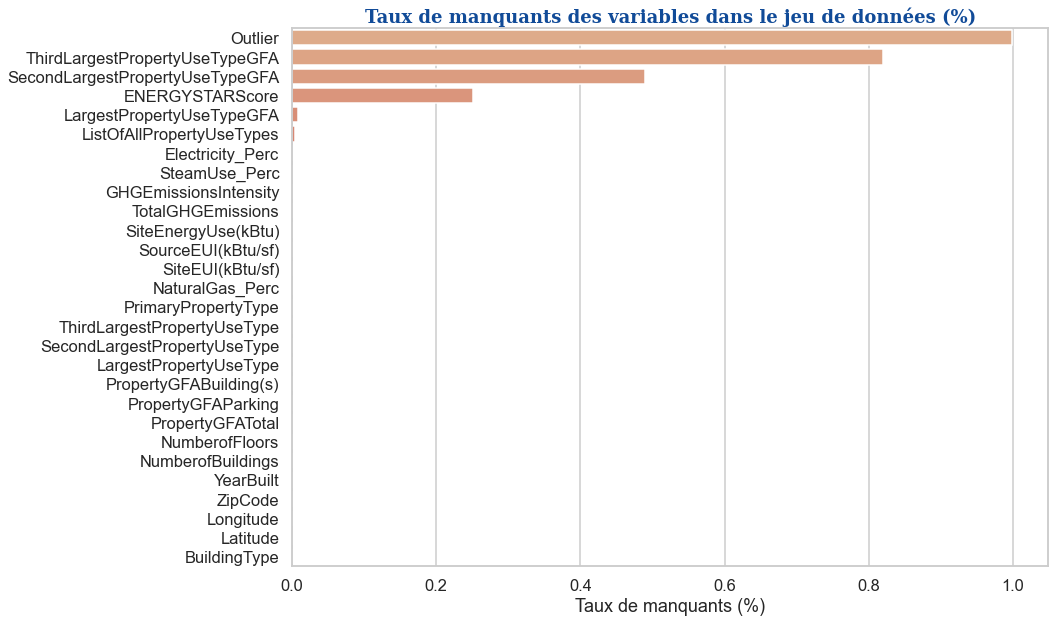

In [169]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

vars = pd.DataFrame(data.isnull().mean(), columns=['Taux_de_Null']).sort_values(by='Taux_de_Null', ascending = False)
fig = plt.figure(figsize=(15, 9))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x=vars.Taux_de_Null, y=vars.index, data=vars, palette="flare")

#Seuil pour suppression des variables
# plt.axvline(x=max_threshold, linewidth=2, color = 'r')
# plt.text(max_threshold+0.1, 20, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de manquants des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de manquants (%)")

fig.tight_layout()

plt.show()

Sur 35 colonnes à ce stade, seulement **6 présentent des données incomplètes** :<br>
-  **'Outlier'** : nous conservons cette colonne pour le moment mais la supprimerons une fois traités les outliers en question.
-  **colonnes de surface par 2nd ou 3e property use** : nous remplacerons ces valeurs par 0.
-  **colonne de surface de la largest property use type GFA** : nous vérifierons les lignes en question pour choisir l'action.
-  **'ENERGYSTARScore'** : nous devrons d'abord essayer d'émuler ce score via ML avant de supprimer la colonne
-  **'ListOfAllPropertyUseTypes'** : nous pourrons supprimer cette colonne, remplie de manière assez peu exploitable.

#### 4.4.7 | Traitement spécifique par colonne et suppression | Step 5

##### Cas de **Longitude et Latitude** :

In [170]:
corr_matrix = data.corr()

In [171]:
corr_matrix["Latitude"].sort_values(ascending = False)

Latitude                           1.000000
YearBuilt                          0.129250
ENERGYSTARScore                    0.097586
Electricity_Perc                   0.083702
NumberofBuildings                  0.023642
Longitude                          0.012380
SourceEUI(kBtu/sf)                -0.001142
PropertyGFAParking                -0.001884
SiteEUI(kBtu/sf)                  -0.010335
NumberofFloors                    -0.031483
TotalGHGEmissions                 -0.035486
PropertyGFATotal                  -0.040647
LargestPropertyUseTypeGFA         -0.042300
SiteEnergyUse(kBtu)               -0.043465
PropertyGFABuilding(s)            -0.045564
GHGEmissionsIntensity             -0.047173
SecondLargestPropertyUseTypeGFA   -0.054776
SteamUse_Perc                     -0.059213
NaturalGas_Perc                   -0.068463
ThirdLargestPropertyUseTypeGFA    -0.106009
Name: Latitude, dtype: float64

Ces deux colonnes sont fortement corrélées, et nous pourrions essayer de diminuer le nombre de features en leur préférant la distance entre le Centre de Seattle et le site correspondant au point GPS déterminé par ces deux coordonnées. Nous supprimerons ensuite les 2 colonnes Longitude et Latitude.

In [172]:
data[['Latitude', 'Longitude']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3224 entries, 24739_2015 to 50226_2016
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   3224 non-null   float64
 1   Longitude  3224 non-null   float64
dtypes: float64(2)
memory usage: 75.6+ KB


Renseignons maintenant la **variable 'DistKm_CityCenter'**, qui va mesurer la **distance géodésique en Km** entre le centre de Seattle et chaque bâtiment défini par sa **Latitude et Longitude**, c'est à dire le **chemin le plus court** entre les deux points.

In [173]:
# Fonction lambda de calcul de la distance geodesique au centre de Seattle

City_Center = (47.6062, -122.3321) # coordonnées gps du centre de Seattle

data['DistKm_CityCenter'] = data.apply(lambda x:geodesic((x["Latitude"], x["Longitude"]), City_Center), axis=1)

Test nettoyage DistKm_CityCenter (on retire les Km pour arrondir)

In [174]:
texte_test = '2.1922426617852855 km'

In [175]:
round(float(str(texte_test)[:-3]),3)

2.192

In [176]:
f = lambda x: round(float(str(x)[:-3]),3)
data['DistKm_CityCenter'] = data['DistKm_CityCenter'].apply(f)

In [177]:
data_num.append('DistKm_CityCenter')

La colonne 'DistKm_CityCenter' est opérationnelle. Nous supprimerons Latitude et Longitude à l'étape finale avant d'exporter. Nous utiliserons avant ces coordonnées visualiser les bâtiments sur une carte de Seattle et nous faire une idée le la disparité géographique.

##### Cas de **SecondLargestPropertyUseTypeGFA** :

In [178]:
data['SecondLargestPropertyUseTypeGFA'] = data['SecondLargestPropertyUseTypeGFA'].fillna(0)

##### Cas de **ThirdLargestPropertyUseTypeGFA** :

In [179]:
data['ThirdLargestPropertyUseTypeGFA'] = data['ThirdLargestPropertyUseTypeGFA'].fillna(0)

##### Cas de **LargestPropertyUseTypeGFA** :

In [180]:
pd.set_option('display.max_rows', 20)
data[data['LargestPropertyUseTypeGFA'].isnull()]

BuildingType    PrimaryPropertyType  \
OSEBuildingID_DataYear                                                
24739_2015              Multifamily LR (1-4)   Low-Rise Multifamily   
24904_2015                    NonResidential     Mixed Use Property   
25701_2015              Multifamily LR (1-4)   Low-Rise Multifamily   
25654_2015                    NonResidential           Retail Store   
23308_2015              Multifamily LR (1-4)   Low-Rise Multifamily   
...                                      ...                    ...   
27343_2016              Multifamily LR (1-4)   Low-Rise Multifamily   
496_2016                      NonResidential  Self-Storage Facility   
21950_2016              Multifamily MR (5-9)   Mid-Rise Multifamily   
20762_2016              Multifamily HR (10+)  High-Rise Multifamily   
21103_2016                    NonResidential                  Hotel   

                         Latitude   Longitude  YearBuilt  NumberofBuildings  \
OSEBuildingID_DataYear                                                        
24739_2015              47.619454 -122.310511       1927                1.0   
24904_2015              47.634530 -122.375757       1928                1.0   
25701_2015              47.656823 -122.320515       1987                1.0   
25654_2015              47.598945 -122.333267       1900                1.0   
23308_2015              47.605709 -122.322893       1959                1.0   
...                           ...         ...        ...                ...   
27343_2016              47.693270 -122.303470       1981                1.0   
496_2016                47.668380 -122.393100       1946                2.0   
21950_2016              47.623900 -122.364370       2000                1.0   
20762_2016              47.617330 -122.353760       1999                1.0   
21103_2016              47.612030 -122.341650       1910                1.0   

                        NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
OSEBuildingID_DataYear                                                         
24739_2015                         4.0             45192                9318   
24904_2015                         2.0             23000                   0   
25701_2015                         4.0             30347                6915   
25654_2015                         2.0             21600                   0   
23308_2015                         3.0             20998                   0   
...                                ...               ...                 ...   
27343_2016                         3.0             42448                   0   
496_2016                           2.0            111445                   0   
21950_2016                         5.0             45715                   0   
20762_2016                        13.0            219874                   0   
21103_2016                         8.0             61721                   0   

                        PropertyGFABuilding(s)  \
OSEBuildingID_DataYear                           
24739_2015                               35874   
24904_2015                               23000   
25701_2015                               23432   
25654_2015                               21600   
23308_2015                               20998   
...                                        ...   
27343_2016                               42448   
496_2016                                111445   
21950_2016                               45715   
20762_2016                              219874   
21103_2016                               61721   

                                                                                                                                                                                                                                                              ListOfAllPropertyUseTypes  \
OSEBuildingID_DataYear                                                                                   

In [181]:
# pd.set_option('display.max_rows', 20)

L'observation montre que pour la majorité de ces lignes l'utilisation correspond à une **activité unique**.

D'abord on passe la valeur de PrimaryPropertyType à LargestPropertyType : 

In [182]:
data.loc[data['LargestPropertyUseTypeGFA'].isnull(), 'LargestPropertyUseType'] =\
data[data['LargestPropertyUseTypeGFA'].isnull()]['PrimaryPropertyType']

Nous allons ensuite passer à **LargestPropertyUseTypeGFA** la surface totale de building **PropertyGFABuilding(s)**.

In [183]:
data.loc[data['LargestPropertyUseTypeGFA'].isnull(), 'LargestPropertyUseTypeGFA'] =\
data[data['LargestPropertyUseTypeGFA'].isnull()]['PropertyGFABuilding(s)']

In [184]:
data[data['LargestPropertyUseTypeGFA'].isnull()]

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), SiteEnergyUse(kBtu), Outlier, TotalGHGEmissions, GHGEmissionsIntensity, ZipCode, SteamUse_Perc, Electricity_Perc, NaturalGas_Perc, DistKm_CityCenter]
Index: []

##### Cas de **ListOfAllPropertyUseTypes** :

In [185]:
cols_to_be_dropped = ['ListOfAllPropertyUseTypes', 'Latitude', 'Longitude']

In [186]:
data_cat = [i for i in data_cat if i not in cols_to_be_dropped]
data_num = [i for i in data_num if i not in cols_to_be_dropped]

In [187]:
# On supprime 'ListOfAllPropertyUseTypes'
data.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)
# data_cat.remove('ListOfAllPropertyUseTypes')
# data_num.remove('Latitude')
# data_num.remove('Longitude')

In [188]:
data_count_5 = data.count().sum()
data_shape_5 = data.shape
data_nan_5 = data.isnull().sum().sum()
step_5 = "fillna(0), cols manquants"
nb_steps += 1

In [189]:
len(data_cat)

8

In [190]:
data_cat

['BuildingType',
 'LargestPropertyUseType',
 'Outlier',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'YearBuilt',
 'ZipCode']

In [191]:
len(data_num)

18

In [192]:
data_num

['ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'SteamUse_Perc',
 'Electricity_Perc',
 'NaturalGas_Perc',
 'DistKm_CityCenter']

In [193]:
data.shape

(3224, 28)

In [194]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ZipCode', 'SteamUse_Perc', 'Electricity_Perc',
       'NaturalGas_Perc', 'DistKm_CityCenter'],
      dtype='object')

### 4.5 | Sélection des lignes à retenir | Step 6, 7, 8

Nous allons maintenant procéder au nettoyage des lignes, en éliminant celles qui :
-  qui ne correspondent pas aux domaine d'étude
-  sont identifiées comme des outliers
-  présentent trop peu de données ou des données erronnées

#### 4.5.1 | Bâtiments dans le périmètre | Step 6

##### Préparation du filtre sur les bâtiments non destinés à l’habitation

In [195]:
data[['BuildingType','PrimaryPropertyType','LargestPropertyUseType',\
     'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']]

BuildingType          PrimaryPropertyType  \
OSEBuildingID_DataYear                                                      
24739_2015              Multifamily LR (1-4)         Low-Rise Multifamily   
25042_2015                    NonResidential                        Other   
24904_2015                    NonResidential           Mixed Use Property   
24408_2015                 SPS-District K-12                  K-12 School   
25455_2015                    NonResidential                        Other   
...                                      ...                          ...   
20986_2016                    NonResidential                    Warehouse   
20987_2016                    NonResidential  Small- and Mid-Sized Office   
20988_2016                    NonResidential  Small- and Mid-Sized Office   
20875_2016              Multifamily HR (10+)        High-Rise Multifamily   
50226_2016                Nonresidential COS           Mixed Use Property   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
24739_2015                                    Low-Rise Multifamily   
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
24408_2015                                             K-12 School   
25455_2015                                   Automobile Dealership   
...                                                            ...   
20986_2016                              Non-Refrigerated Warehouse   
20987_2016                                                  Office   
20988_2016                                                  Office   
20875_2016                                     Multifamily Housing   
50226_2016                                      Other - Recreation   

                          SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                   
24739_2015                                         nan   
25042_2015                                     Parking   
24904_2015                                         nan   
24408_2015                                         nan   
25455_2015                                         nan   
...                                                ...   
20986_2016                                      Office   
20987_2016                  Non-Refrigerated Warehouse   
20988_2016                                         nan   
20875_2016                                     Parking   
50226_2016              Fitness Center/Health Club/Gym   

                       ThirdLargestPropertyUseType  
OSEBuildingID_DataYear                              
24739_2015                                     nan  
25042_2015                                     nan  
24904_2015                                     nan  
24408_2015                                     nan  
25455_2015                                     nan  
...                                            ...  
20986_2016                                     nan  
20987_2016                                     nan  
20988_2016                                     nan  
20875_2016                            Retail Store  
50226_2016                      Pre-school/Daycare  

[3224 rows x 5 columns]

In [196]:
sorted(data.BuildingType.unique())

['Campus',
 'Multifamily HR (10+)',
 'Multifamily LR (1-4)',
 'Multifamily MR (5-9)',
 'NonResidential',
 'Nonresidential COS',
 'Nonresidential WA',
 'SPS-District K-12']

In [197]:
print('La catégorie BuildingType comprend',len(data.BuildingType.unique()),\
      'valeurs uniques, pas de traitement particulier à appliquer')

La catégorie BuildingType comprend 8 valeurs uniques, pas de traitement particulier à appliquer


In [198]:
sorted(data.PrimaryPropertyType.unique())

['Distribution Center',
 'High-Rise Multifamily',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'Non-Refrigerated Warehouse',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Restaurant',
 'Restaurant\n',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket / Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

In [199]:
print('La catégorie comprend',len(data.PrimaryPropertyType.unique()),'valeurs, dont quelques doublons à corriger')

La catégorie comprend 25 valeurs, dont quelques doublons à corriger


Pour cela nous allons remplacer dans cette colonne les chaines de caractères :
-  '\n' par une chaine vide 
-  ' / ' par '/'

In [200]:
data['PrimaryPropertyType'].replace(to_replace='\n$', value='', regex=True, inplace=True)
data['PrimaryPropertyType'].replace(to_replace=' / ', value='/', regex=True, inplace=True)

In [201]:
sorted(data.PrimaryPropertyType.unique())

['Distribution Center',
 'High-Rise Multifamily',
 'Hospital',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Large Office',
 'Low-Rise Multifamily',
 'Medical Office',
 'Mid-Rise Multifamily',
 'Mixed Use Property',
 'Non-Refrigerated Warehouse',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Small- and Mid-Sized Office',
 'Supermarket/Grocery Store',
 'University',
 'Warehouse',
 'Worship Facility']

In [202]:
print('La catégorie PrimaryPropertyType comprend',len(data.PrimaryPropertyType.unique()),'valeurs uniques')

La catégorie PrimaryPropertyType comprend 24 valeurs uniques


In [203]:
data.loc[data['PrimaryPropertyType'] == 'SPS-District K-12']

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), SiteEnergyUse(kBtu), Outlier, TotalGHGEmissions, GHGEmissionsIntensity, ZipCode, SteamUse_Perc, Electricity_Perc, NaturalGas_Perc, DistKm_CityCenter]
Index: []

##### Type principal de site par type de bâtiment

In [204]:
for b in sorted(data.BuildingType.unique()):
    print(b,' :\n')
    for p in sorted(data.loc[data['BuildingType'] == b]['PrimaryPropertyType'].unique()):
        print(p)
    print('_'*20)
    print('\n')

Campus  :

K-12 School
Large Office
Low-Rise Multifamily
Mixed Use Property
Other
Restaurant
University
____________________


Multifamily HR (10+)  :

High-Rise Multifamily
Hotel
Other
Senior Care Community
____________________


Multifamily LR (1-4)  :

Low-Rise Multifamily
Mixed Use Property
Other
Senior Care Community
Small- and Mid-Sized Office
University
____________________


Multifamily MR (5-9)  :

Mid-Rise Multifamily
Mixed Use Property
Other
Residence Hall
Senior Care Community
____________________


NonResidential  :

Distribution Center
Hospital
Hotel
K-12 School
Laboratory
Large Office
Low-Rise Multifamily
Medical Office
Mixed Use Property
Non-Refrigerated Warehouse
Other
Refrigerated Warehouse
Residence Hall
Restaurant
Retail Store
Self-Storage Facility
Senior Care Community
Small- and Mid-Sized Office
Supermarket/Grocery Store
University
Warehouse
Worship Facility
____________________


Nonresidential COS  :

Distribution Center
Large Office
Medical Office
Mixed Use Pro

L'analyse devant ne contenir que des bâtiments non destinés à l'habitation (nous décidons d'y inclure les hôtels), nous allons éliminer les BuildingType ou PrimaryPropertyType contenant le terme 'Multifamily' dans leur libellé.  

##### On supprime les sites liés à l'habitation | Step 6

In [205]:
data = data[(~data['BuildingType'].str.contains("Multifamily")) & (~data['PrimaryPropertyType'].str.contains("Multifamily"))]

In [206]:
data_count_6 = data.count().sum()
data_shape_6 = data.shape
data_nan_6 = data.isnull().sum().sum()
step_6 = "filtre bâtiments hors habitation"
nb_steps += 1

##### Visualisation des types de site

Visualisation par **BuildingType** :

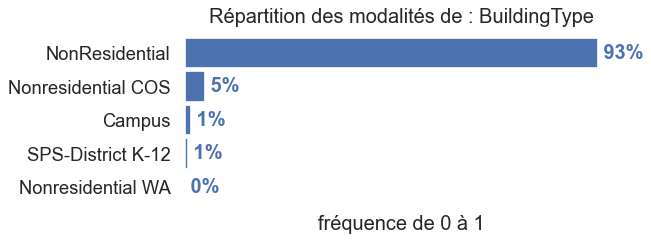

In [207]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

for column in ['BuildingType']:
    chaine = 'Répartition des modalités de : ' + column
    plt.figure(figsize=(7,3), dpi=80)
    data[column].value_counts(normalize=True, ascending = True).plot(kind='barh', width=0.9) #normalize pour avoir les fréquences
#     plt.axis('off')
    axes = plt.gca()
    axes.set_frame_on(False) # supprime le cadre entourant le graphe
    axes.yaxis.grid(False) # Supprime la grille pour les ordonnées et conserve les ticks
#     axes.xaxis.grid(False) # Supprime la grille pour les abscisses et conserve les ticks
    plt.xticks([], []) # Supprime les graduations et étiquettes pour les abscisses
    plt.title(chaine)
    plt.xlabel("fréquence de 0 à 1")
#     plt.tight_layout()

    for i, v in enumerate(data[column].value_counts(normalize=True, ascending = True)):
        plt.text(v, i, " "+str(int(round(v*100,0)))+"%", color='b', va='center', fontweight='bold')
        
    plt.show()

Visualisation par **PrimaryPropertyType** :

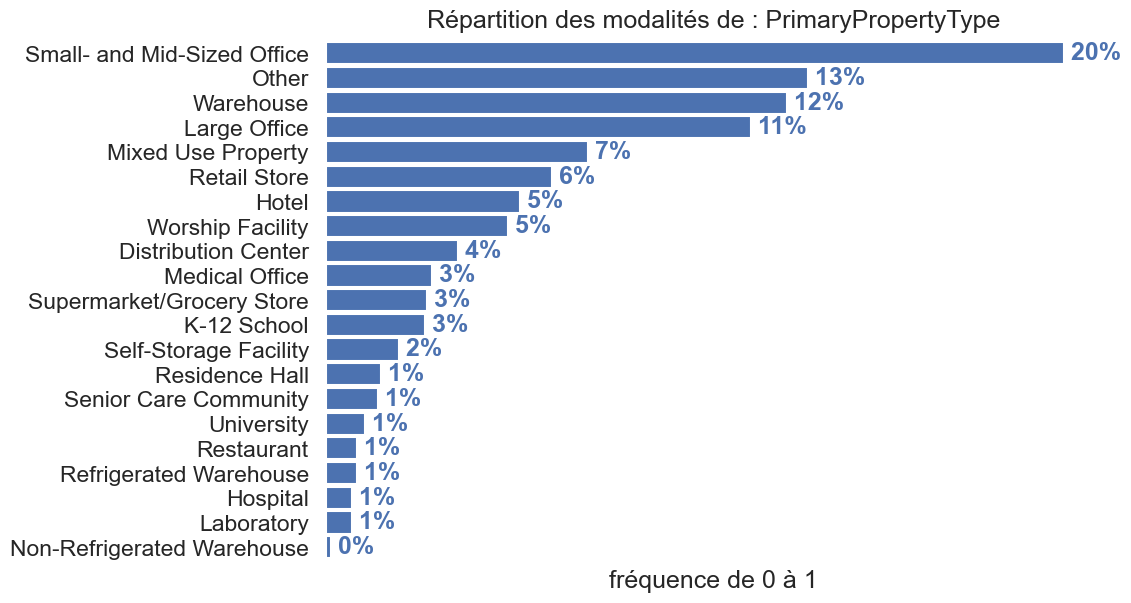

In [208]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

for column in ['PrimaryPropertyType']:
    chaine = 'Répartition des modalités de : ' + column
    plt.figure(figsize=(10,7), dpi=100)
    data.loc[(data['BuildingType']=="NonResidential"),column].\
    value_counts(normalize=True, ascending = True).plot(kind='barh', width=0.9) #normalize pour avoir les fréquences
#     plt.axis('off')
    axes = plt.gca()
    axes.set_frame_on(False) # supprime le cadre entourant le graphe
    axes.yaxis.grid(False) # Supprime la grille pour les ordonnées et conserve les ticks
#     axes.xaxis.grid(False) # Supprime la grille pour les abscisses et conserve les ticks
    plt.xticks([], []) # Supprime les graduations et étiquettes pour les abscisses
    plt.title(chaine)
    plt.xlabel("fréquence de 0 à 1")
#     plt.tight_layout()

    for i, v in enumerate(data.loc[(data['BuildingType']=="NonResidential"),column].\
    value_counts(normalize=True, ascending = True)):
        plt.text(v, i, " "+str(int(round(v*100,0)))+"%", color='b', va='center', fontweight='bold')
        
    plt.show()

##### Sous catégories usage des sites

En prévision d'un usage ultérieur, nous allons nous assurer que les sous catégories précisant les usages des sites sont correctement renseignées, sans erreurs de libellé (à assembler).

In [209]:
data[data['LargestPropertyUseType'] == ("nan")]

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), SiteEnergyUse(kBtu), Outlier, TotalGHGEmissions, GHGEmissionsIntensity, ZipCode, SteamUse_Perc, Electricity_Perc, NaturalGas_Perc, DistKm_CityCenter]
Index: []

In [210]:
sorted(data.LargestPropertyUseType.unique())

['Adult Education',
 'Automobile Dealership',
 'Bank Branch',
 'College/University',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Financial Office',
 'Fire Station',
 'Fitness Center/Health Club/Gym',
 'Food Service',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Library',
 'Lifestyle Center',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Mixed Use Property',
 'Movie Theater',
 'Multifamily Housing',
 'Museum',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Lodging/Residential',
 'Other - Mall',
 'Other - Public Services',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Other - Utility',
 'Other/Specialty Hospital',
 'Outpatient Rehabilitation/Physical Therapy',
 'Parking',
 'Performing Arts',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Police Station',
 'Pre-school/Daycare',
 'Prison/Incarceration',
 'Refrig

In [211]:
sorted(data.SecondLargestPropertyUseType.unique())

['Adult Education',
 'Automobile Dealership',
 'Bank Branch',
 'Bar/Nightclub',
 'College/University',
 'Convenience Store without Gas Station',
 'Courthouse',
 'Data Center',
 'Distribution Center',
 'Enclosed Mall',
 'Financial Office',
 'Fitness Center/Health Club/Gym',
 'Food Sales',
 'Food Service',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Movie Theater',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Lodging/Residential',
 'Other - Public Services',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Parking',
 'Performing Arts',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Pre-school/Daycare',
 'Refrigerated Warehouse',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Residence Hall/Dormitory',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Social/Meeting Hall',
 'Superm

In [212]:
sorted(data.ThirdLargestPropertyUseType.unique())

['Bank Branch',
 'Bar/Nightclub',
 'Convenience Store without Gas Station',
 'Data Center',
 'Distribution Center',
 'Fast Food Restaurant',
 'Financial Office',
 'Fitness Center/Health Club/Gym',
 'Food Service',
 'Hotel',
 'K-12 School',
 'Laboratory',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Other - Education',
 'Other - Entertainment/Public Assembly',
 'Other - Recreation',
 'Other - Restaurant/Bar',
 'Other - Services',
 'Other - Technology/Science',
 'Other - Utility',
 'Other/Specialty Hospital',
 'Parking',
 'Personal Services (Health/Beauty, Dry Cleaning, etc)',
 'Pre-school/Daycare',
 'Refrigerated Warehouse',
 'Restaurant',
 'Retail Store',
 'Self-Storage Facility',
 'Social/Meeting Hall',
 'Strip Mall',
 'Supermarket/Grocery Store',
 'Swimming Pool',
 'Vocational School',
 'Worship Facility',
 'nan']

Pas de fait marquant dans ces 3 listes. On peut les conserver telles quelles.

#### 4.5.2 | Lignes identifiées comme des outliers | Step 7

Observons les lignes identifiées par la ville de Seattle comme des outliers, pour décider ou non de les supprimer.

In [213]:
data.loc[~data['Outlier'].isnull()]

BuildingType          PrimaryPropertyType  \
OSEBuildingID_DataYear                                                
19656_2015              NonResidential  Small- and Mid-Sized Office   
22446_2015              NonResidential  Small- and Mid-Sized Office   

                         Latitude   Longitude  YearBuilt  NumberofBuildings  \
OSEBuildingID_DataYear                                                        
19656_2015              47.617539 -122.332782       1929                1.0   
22446_2015              47.662407 -122.373085       1903                1.0   

                        NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
OSEBuildingID_DataYear                                                         
19656_2015                         3.0             21600                   0   
22446_2015                         3.0             24913                   0   

                        PropertyGFABuilding(s) LargestPropertyUseType  \
OSEBuildingID_DataYear                                                  
19656_2015                               21600                 Office   
22446_2015                               24913                 Office   

                        LargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                              
19656_2015                                21600.0   
22446_2015                                24913.0   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
19656_2015                                      nan   
22446_2015                                      nan   

                        SecondLargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                                    
19656_2015                                          0.0   
22446_2015                                          0.0   

                       ThirdLargestPropertyUseType  \
OSEBuildingID_DataYear                               
19656_2015                                     nan   
22446_2015                                     nan   

                        ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
OSEBuildingID_DataYear                                                    
19656_2015                                         0.0              NaN   
22446_2015                                         0.0            100.0   

                        SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
OSEBuildingID_DataYear                                         
19656_2015                           6.2                19.5   
22446_2015                           9.6                26.5   

                        SiteEnergyUse(kBtu)      Outlier  TotalGHGEmissions  \
OSEBuildingID_DataYear                                                        
19656_2015                         133880.0  Low Outlier               0.93   
22446_2015                         238255.0  Low Outlier               3.59   

                        GHGEmissionsIntensity ZipCode  SteamUse_Perc  \
OSEBuildingID_DataYear                                                 
19656_2015                               0.02   98191            0.0   
22446_2015                               0.11   98107            0.0   

                        Electricity_Perc  NaturalGas_Perc  DistKm_CityCenter  
OSEBuildingID_DataYear                                                        
19656_2015                        100.00             0.00              1.262  
22446_2015                         82.49            17.51              6.967

Il s'agit principalement de **sites non résidentiels** et relativement **anciens**.<br>
Les outliers peuvent **influer sur les régressions** et sur **l'analyse ML** à venir.<br>
Nous allons donc **retirer les lignes concernées**.

In [214]:
#On supprime les lignes sans aucune valeur dans la colonne 'Outlier' (High / Low Outlier)
data = data[data['Outlier'].isnull()]
#On supprime la colonne Outlier devenue inutile
data = data.drop(['Outlier'], axis=1)

In [215]:
data_cat = [i for i in data_cat if i not in ['Outlier']]

In [216]:
data_count_7 = data.count().sum()
data_shape_7 = data.shape
data_nan_7 = data.isnull().sum().sum()
step_7 = "filtre outliers"
nb_steps += 1

#### 4.5.3 | Suppression des lignes présentant peu de données | Step 8

Observons les lignes ayant un pourcentage de manquants >0% sur les colonnes numériques (hors manquants dûs à ENERGYSTARScore), pour décider ou non de supprimer les indices correspondants.

In [217]:
data[data.ENERGYSTARScore.notnull()][data_num].isnull().mean(axis=1).sort_values(ascending = False)

OSEBuildingID_DataYear
20988_2016    0.0
27145_2016    0.0
762_2016      0.0
761_2016      0.0
760_2016      0.0
             ... 
474_2016      0.0
473_2016      0.0
471_2016      0.0
468_2016      0.0
23163_2015    0.0
Length: 1003, dtype: float64

In [218]:
data[data.ENERGYSTARScore.notnull()][data[data_num].isnull().mean(axis=1).sort_values(ascending = False)>0]

C:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), SiteEnergyUse(kBtu), TotalGHGEmissions, GHGEmissionsIntensity, ZipCode, SteamUse_Perc, Electricity_Perc, NaturalGas_Perc, DistKm_CityCenter]
Index: []

In [219]:
# on voit ici que les nan sont bien dûs uniquement à ENERGYSTARScore ou sa version log
pd.set_option('display.max_rows', 20)
data[data[data_num].isnull().mean(axis=1).sort_values(ascending = False)>0]

C:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


BuildingType          PrimaryPropertyType  \
OSEBuildingID_DataYear                                                    
25042_2015                  NonResidential                        Other   
24904_2015                  NonResidential           Mixed Use Property   
24408_2015               SPS-District K-12                  K-12 School   
25455_2015                  NonResidential                        Other   
25654_2015                  NonResidential                 Retail Store   
...                                    ...                          ...   
20978_2016                  NonResidential                        Other   
20985_2016                  NonResidential                        Other   
20986_2016                  NonResidential                    Warehouse   
20987_2016                  NonResidential  Small- and Mid-Sized Office   
50226_2016              Nonresidential COS           Mixed Use Property   

                         Latitude   Longitude  YearBuilt  NumberofBuildings  \
OSEBuildingID_DataYear                                                        
25042_2015              47.588095 -122.310103       1966                1.0   
24904_2015              47.634530 -122.375757       1928                1.0   
24408_2015              47.695489 -122.340188       1953                1.0   
25455_2015              47.626170 -122.340102       1922                1.0   
25654_2015              47.598945 -122.333267       1900                1.0   
...                           ...         ...        ...                ...   
20978_2016              47.552970 -122.324720       1976                1.0   
20985_2016              47.551680 -122.324590       1970                1.0   
20986_2016              47.550490 -122.323820       1968                1.0   
20987_2016              47.551450 -122.326350       1969                1.0   
50226_2016              47.539390 -122.295360       1938                1.0   

                        NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
OSEBuildingID_DataYear                                                         
25042_2015                         2.0             33332                   0   
24904_2015                         2.0             23000                   0   
24408_2015                         1.0            110830                   0   
25455_2015                         1.0             23050                   0   
25654_2015                         2.0             21600                   0   
...                                ...               ...                 ...   
20978_2016                         1.0             47105                   0   
20985_2016                         1.0             26400                   0   
20986_2016                         1.0             27680                   0   
20987_2016                         2.0             25872                   0   
50226_2016                         1.0             18258                   0   

                        PropertyGFABuilding(s)  \
OSEBuildingID_DataYear                           
25042_2015                               33332   
24904_2015                               23000   
24408_2015                              110830   
25455_2015                               23050   
25654_2015                               21600   
...                                        ...   
20978_2016                               47105   
20985_2016                               26400   
20986_2016                               27680   
20987_2016                               25872   
50226_2016                               18258   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
24408_2015                                            

Il semble que les ajustements effectués durant le projet aient modifié le taux de nan. A ce stade **aucune ligne parmi les variables numériques ne présente un taux de manquants supérieur à 50%**.

In [220]:
data_count_8 = data.count().sum()
data_shape_8 = data.shape
data_nan_8 = data.isnull().sum().sum()
step_8 = "Taux manquants numériques"
nb_steps += 1

Observons maintenant les lignes ayant un pourcentage de manquants **>0% pour les variables catégorielles**, pour décider ou non de supprimer les indices correspondants.

In [221]:
data[data_cat].head()

BuildingType  \
OSEBuildingID_DataYear                      
25042_2015                 NonResidential   
24904_2015                 NonResidential   
24408_2015              SPS-District K-12   
25455_2015                 NonResidential   
25654_2015                 NonResidential   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
24408_2015                                             K-12 School   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   

                       PrimaryPropertyType SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                                    
25042_2015                           Other                      Parking   
24904_2015              Mixed Use Property                          nan   
24408_2015                     K-12 School                          nan   
25455_2015                           Other                          nan   
25654_2015                    Retail Store                          nan   

                       ThirdLargestPropertyUseType  YearBuilt ZipCode  
OSEBuildingID_DataYear                                                 
25042_2015                                     nan       1966   98144  
24904_2015                                     nan       1928   98119  
24408_2015                                     nan       1953   98103  
25455_2015                                     nan       1922   98109  
25654_2015                                     nan       1900   98104

In [222]:
data[data_cat].isnull().mean(axis=1).sort_values(ascending = False)

OSEBuildingID_DataYear
50226_2016    0.0
26392_2016    0.0
26359_2016    0.0
26115_2016    0.0
26119_2016    0.0
             ... 
481_2016      0.0
477_2016      0.0
452_2016      0.0
453_2016      0.0
25042_2015    0.0
Length: 1550, dtype: float64

In [223]:
pd.set_option('display.max_rows', 200)
data[data[data_cat].isnull().mean(axis=1).sort_values(ascending = False)>0]

C:\anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SourceEUI(kBtu/sf), SiteEnergyUse(kBtu), TotalGHGEmissions, GHGEmissionsIntensity, ZipCode, SteamUse_Perc, Electricity_Perc, NaturalGas_Perc, DistKm_CityCenter]
Index: []

In [224]:
pd.set_option('display.max_rows', 20)

A ce stade **aucune ligne parmi les variables catégorielles ne présente un taux de manquants supérieur à 0%**.

### 4.6 | Hypothèse de Normalité

In [225]:
print('Sur un total de ',data.shape[1],'colonnes, on distingue,',len(data_num),'colonnes numériques.')

Sur un total de  27 colonnes, on distingue, 18 colonnes numériques.


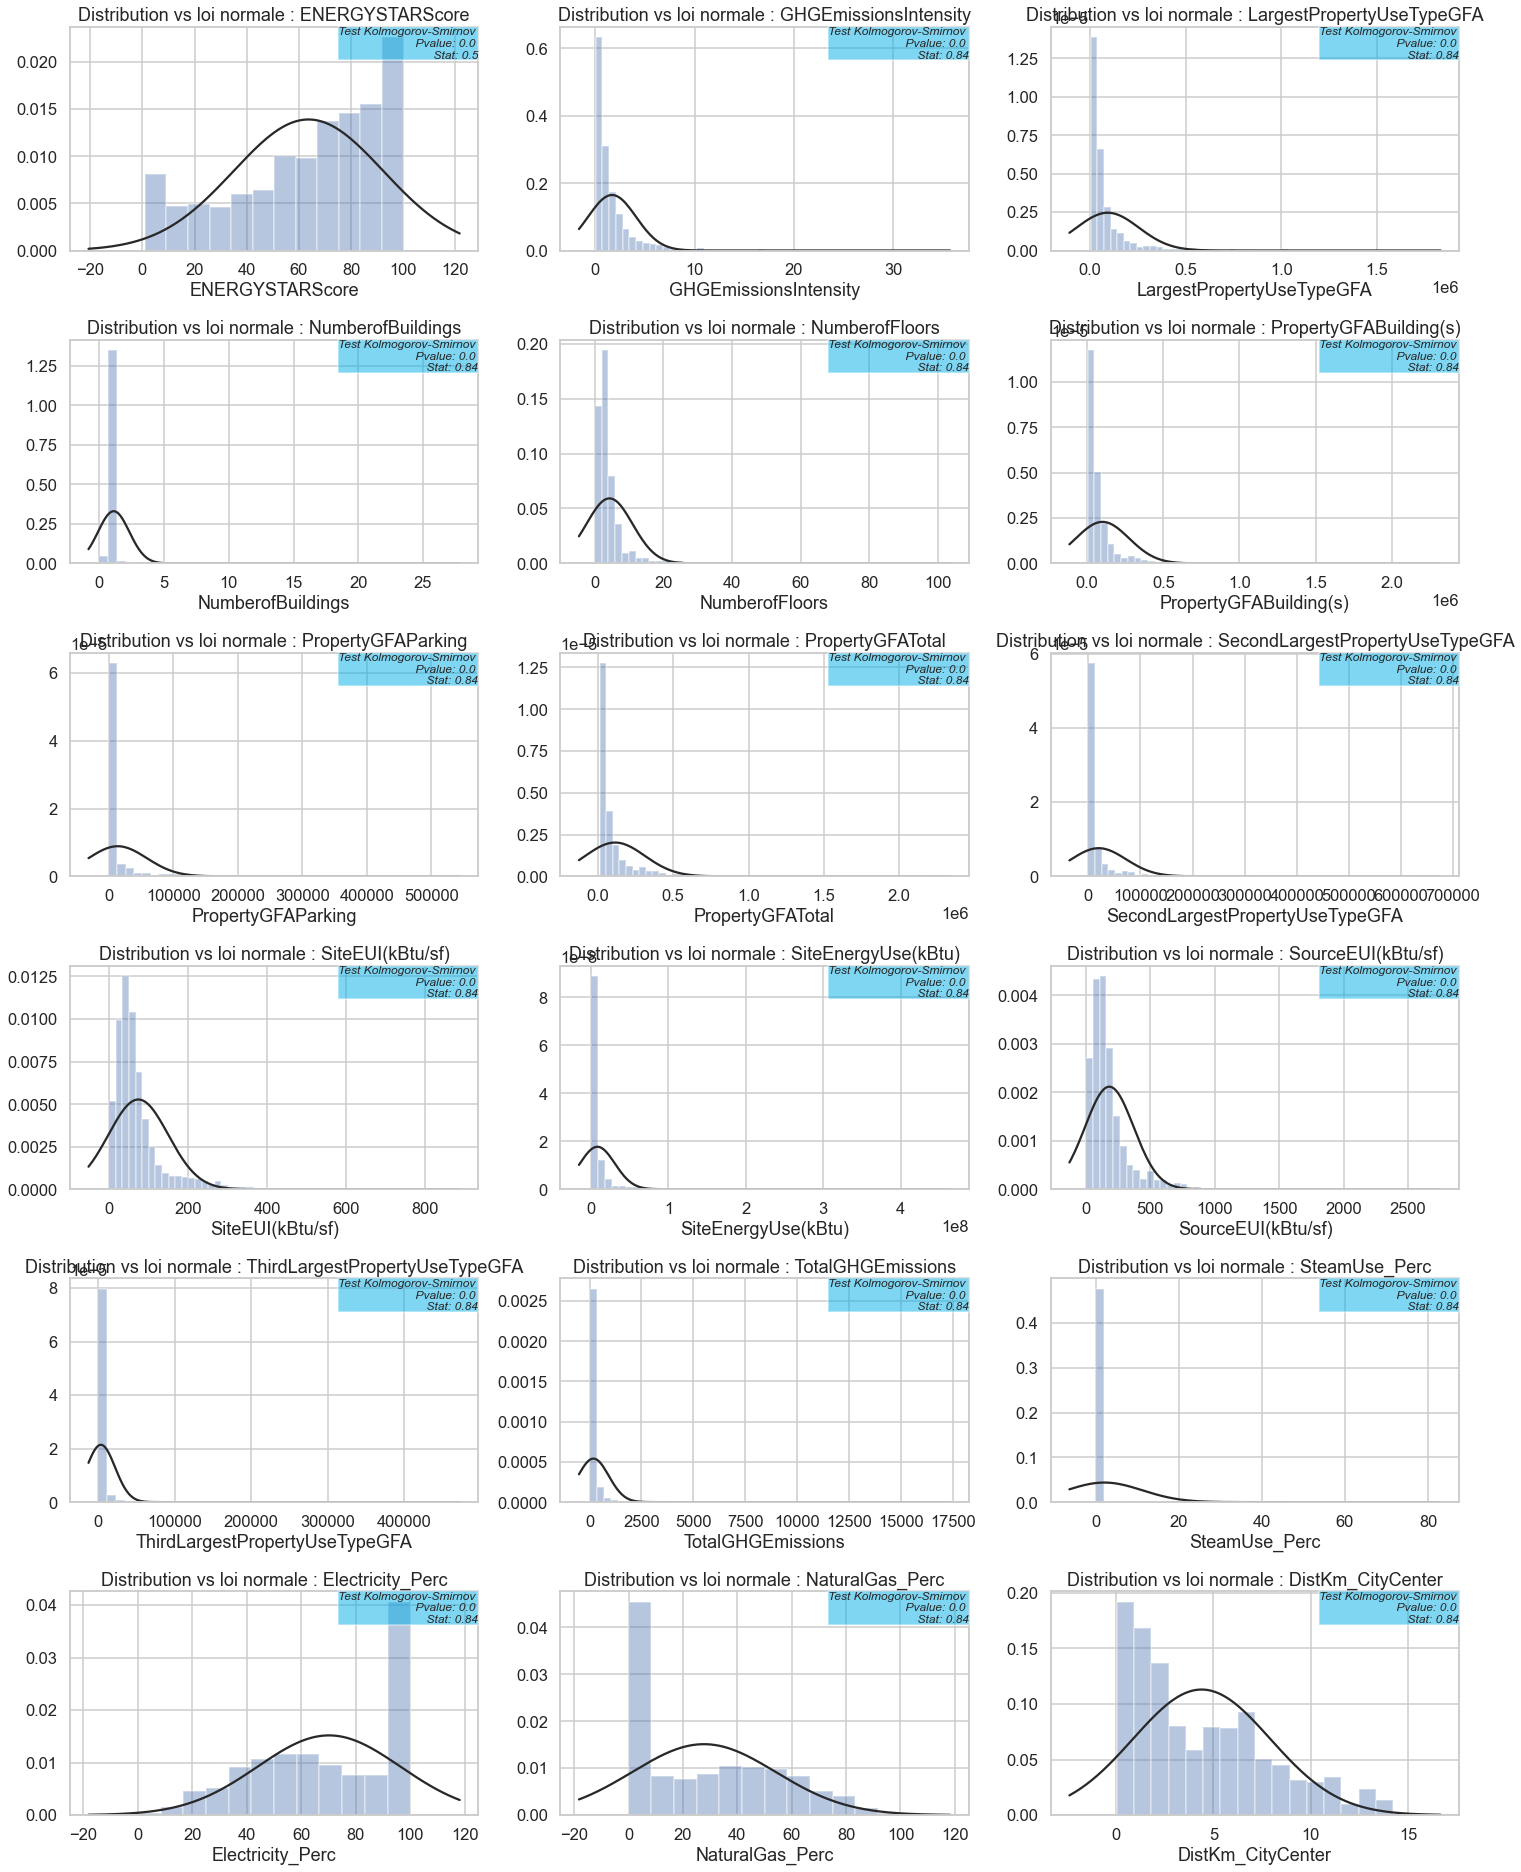

In [226]:
warnings.filterwarnings('ignore')

sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(data_num)):
    fig.add_subplot(len(data_num)//3+1,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = data_num[i]
    kstest = stats.kstest(data[colonne].notnull(),'norm')
    ax = sns.distplot(data[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
    
    fig.tight_layout()
    
plt.show()

**Interprétation du test :**<br>

Pour une variable V donnée, si l’hypothèse nulle est vraie (ici H0:{Fn=Fth}), alors<br>
**la probabilité** de voir la **statistique de test Stat** (écart maximum) autant éloignée de la valeur 0 <br>
est **inférieure à la p-Value (de 0 dansnotre cas)**, soit ici une faible probabilité.<br>

Autrement dit, la valeur de Stat est **anormalement grande**, et donc on **ne peut pas accepter l’hypothèse nulle**. <br>
Ceci confirme donc que **la loi de probabilité de la variable V n’est pas celle d’une loi normale**.

C'est ici le cas pour toutes les variables étudiées. On peut donc considérer qu'aucune d'entre elle ne suit une loi normale.

### 4.7 | Analyse des derniers NaN

#### 4.7.1 | Suppression NaN hors ENERGYSTARScore

In [227]:
data.isnull().mean(axis=0).sort_values(ascending = False)

ENERGYSTARScore                   0.352903
SiteEUI(kBtu/sf)                  0.000645
NaturalGas_Perc                   0.000645
Electricity_Perc                  0.000645
SteamUse_Perc                     0.000645
                                    ...   
SecondLargestPropertyUseType      0.000000
ThirdLargestPropertyUseType       0.000000
ThirdLargestPropertyUseTypeGFA    0.000000
ZipCode                           0.000000
BuildingType                      0.000000
Length: 27, dtype: float64

In [228]:
cols = [col for col in data.columns if col != 'ENERGYSTARScore']

In [229]:
data[cols].isnull().sum()

BuildingType           0
PrimaryPropertyType    0
Latitude               0
Longitude              0
YearBuilt              0
                      ..
ZipCode                0
SteamUse_Perc          1
Electricity_Perc       1
NaturalGas_Perc        1
DistKm_CityCenter      0
Length: 26, dtype: int64

ENERGYSTARScore doit pour le moment rester dans le jeu de données, car nous devrons l'analyser durant la seconde phase.
Les autres lignes avec des valeurs manquantes peuvent être supprimées, car peu nombreuses (7).

In [230]:
data[data['SteamUse_Perc'].isnull()]

BuildingType PrimaryPropertyType   Latitude  \
OSEBuildingID_DataYear                                                     
24408_2015              SPS-District K-12         K-12 School  47.695489   

                         Longitude  YearBuilt  NumberofBuildings  \
OSEBuildingID_DataYear                                             
24408_2015             -122.340188       1953                1.0   

                        NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
OSEBuildingID_DataYear                                                         
24408_2015                         1.0            110830                   0   

                        PropertyGFABuilding(s) LargestPropertyUseType  \
OSEBuildingID_DataYear                                                  
24408_2015                              110830            K-12 School   

                        LargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                              
24408_2015                               110830.0   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
24408_2015                                      nan   

                        SecondLargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                                    
24408_2015                                          0.0   

                       ThirdLargestPropertyUseType  \
OSEBuildingID_DataYear                               
24408_2015                                     nan   

                        ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
OSEBuildingID_DataYear                                                    
24408_2015                                         0.0              NaN   

                        SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
OSEBuildingID_DataYear                                         
24408_2015                           NaN                 NaN   

                        SiteEnergyUse(kBtu)  TotalGHGEmissions  \
OSEBuildingID_DataYear                                           
24408_2015                              NaN                NaN   

                        GHGEmissionsIntensity ZipCode  SteamUse_Perc  \
OSEBuildingID_DataYear                                                 
24408_2015                                NaN   98103            NaN   

                        Electricity_Perc  NaturalGas_Perc  DistKm_CityCenter  
OSEBuildingID_DataYear                                                        
24408_2015                           NaN              NaN              9.946

In [231]:
data[data['SiteEnergyUse(kBtu)'].isnull()]

BuildingType PrimaryPropertyType   Latitude  \
OSEBuildingID_DataYear                                                     
24408_2015              SPS-District K-12         K-12 School  47.695489   

                         Longitude  YearBuilt  NumberofBuildings  \
OSEBuildingID_DataYear                                             
24408_2015             -122.340188       1953                1.0   

                        NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
OSEBuildingID_DataYear                                                         
24408_2015                         1.0            110830                   0   

                        PropertyGFABuilding(s) LargestPropertyUseType  \
OSEBuildingID_DataYear                                                  
24408_2015                              110830            K-12 School   

                        LargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                              
24408_2015                               110830.0   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
24408_2015                                      nan   

                        SecondLargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                                    
24408_2015                                          0.0   

                       ThirdLargestPropertyUseType  \
OSEBuildingID_DataYear                               
24408_2015                                     nan   

                        ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
OSEBuildingID_DataYear                                                    
24408_2015                                         0.0              NaN   

                        SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
OSEBuildingID_DataYear                                         
24408_2015                           NaN                 NaN   

                        SiteEnergyUse(kBtu)  TotalGHGEmissions  \
OSEBuildingID_DataYear                                           
24408_2015                              NaN                NaN   

                        GHGEmissionsIntensity ZipCode  SteamUse_Perc  \
OSEBuildingID_DataYear                                                 
24408_2015                                NaN   98103            NaN   

                        Electricity_Perc  NaturalGas_Perc  DistKm_CityCenter  
OSEBuildingID_DataYear                                                        
24408_2015                           NaN              NaN              9.946

Mis à part ENERGYSTARScore qui sera traité à part dans la partie ML (et que nous conservons en l'état pour ne pas introduire de biais), le reste des colonnes présente maintenant une **proportion de manquants inférieure à 1,2%**, ce qui permettrait d'envisager une **imputation simple de type mode ou médiane par classe**.<br>

Mais compte-tenu du faible nombre de lignes concernées (7) nous allons **supprimer ces lignes et gagner du temps** sans trop impacter la modélisation.

In [232]:
# on supprime les lignes pour lesquelles on a des nan 
# dans les colonnes 'SiteEnergyUse(kBtu)' et 'SteamUse_Perc'
# 'Electricity_Perc' et 'NaturalGas_Perc' suivent le même pattern
# 'SiteEnergyUse(kBtu)' partage 5 des 7 lignes concernées
data.drop(data[data['SteamUse_Perc'].isnull()].index, inplace=True)

In [233]:
data.isnull().sum().sort_values(ascending = False)

ENERGYSTARScore                 546
DistKm_CityCenter                 0
SecondLargestPropertyUseType      0
PrimaryPropertyType               0
Latitude                          0
                               ... 
GHGEmissionsIntensity             0
ZipCode                           0
SteamUse_Perc                     0
Electricity_Perc                  0
BuildingType                      0
Length: 27, dtype: int64

#### 4.7.2 | Analyse NaN numériques

In [234]:
data[data_num].isnull().mean(axis=0).sort_values(ascending = False)

ENERGYSTARScore                    0.352485
NaturalGas_Perc                    0.000000
GHGEmissionsIntensity              0.000000
LargestPropertyUseTypeGFA          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
DistKm_CityCenter                  0.000000
SiteEUI(kBtu/sf)                   0.000000
SiteEnergyUse(kBtu)                0.000000
SourceEUI(kBtu/sf)                 0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
TotalGHGEmissions                  0.000000
SteamUse_Perc                      0.000000
Electricity_Perc                   0.000000
SecondLargestPropertyUseTypeGFA    0.000000
dtype: float64

#### 4.7.3 | Analyse NaN catégoriels

In [235]:
data[data_cat].isnull().mean(axis=0).sort_values(ascending = False)

ZipCode                         0.0
YearBuilt                       0.0
ThirdLargestPropertyUseType     0.0
SecondLargestPropertyUseType    0.0
PrimaryPropertyType             0.0
LargestPropertyUseType          0.0
BuildingType                    0.0
dtype: float64

Aucune valeur qualitative manquante a priori.

### 4.8 | Visualisation géographique à l'aide des latitudes et longitudes | Step 9

In [236]:
#Coordonnées du centre de Seattle
seattle_lat = 47.6062
seattle_lon = -122.3321

seattle_map = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11)

#Clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle_map)
for lat, lng, in zip(data.Latitude, data.Longitude):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

seattle_map

Alternativement, nous pouvons faire apparaitre l'ENERGYSTARScore pour les points géographiques:

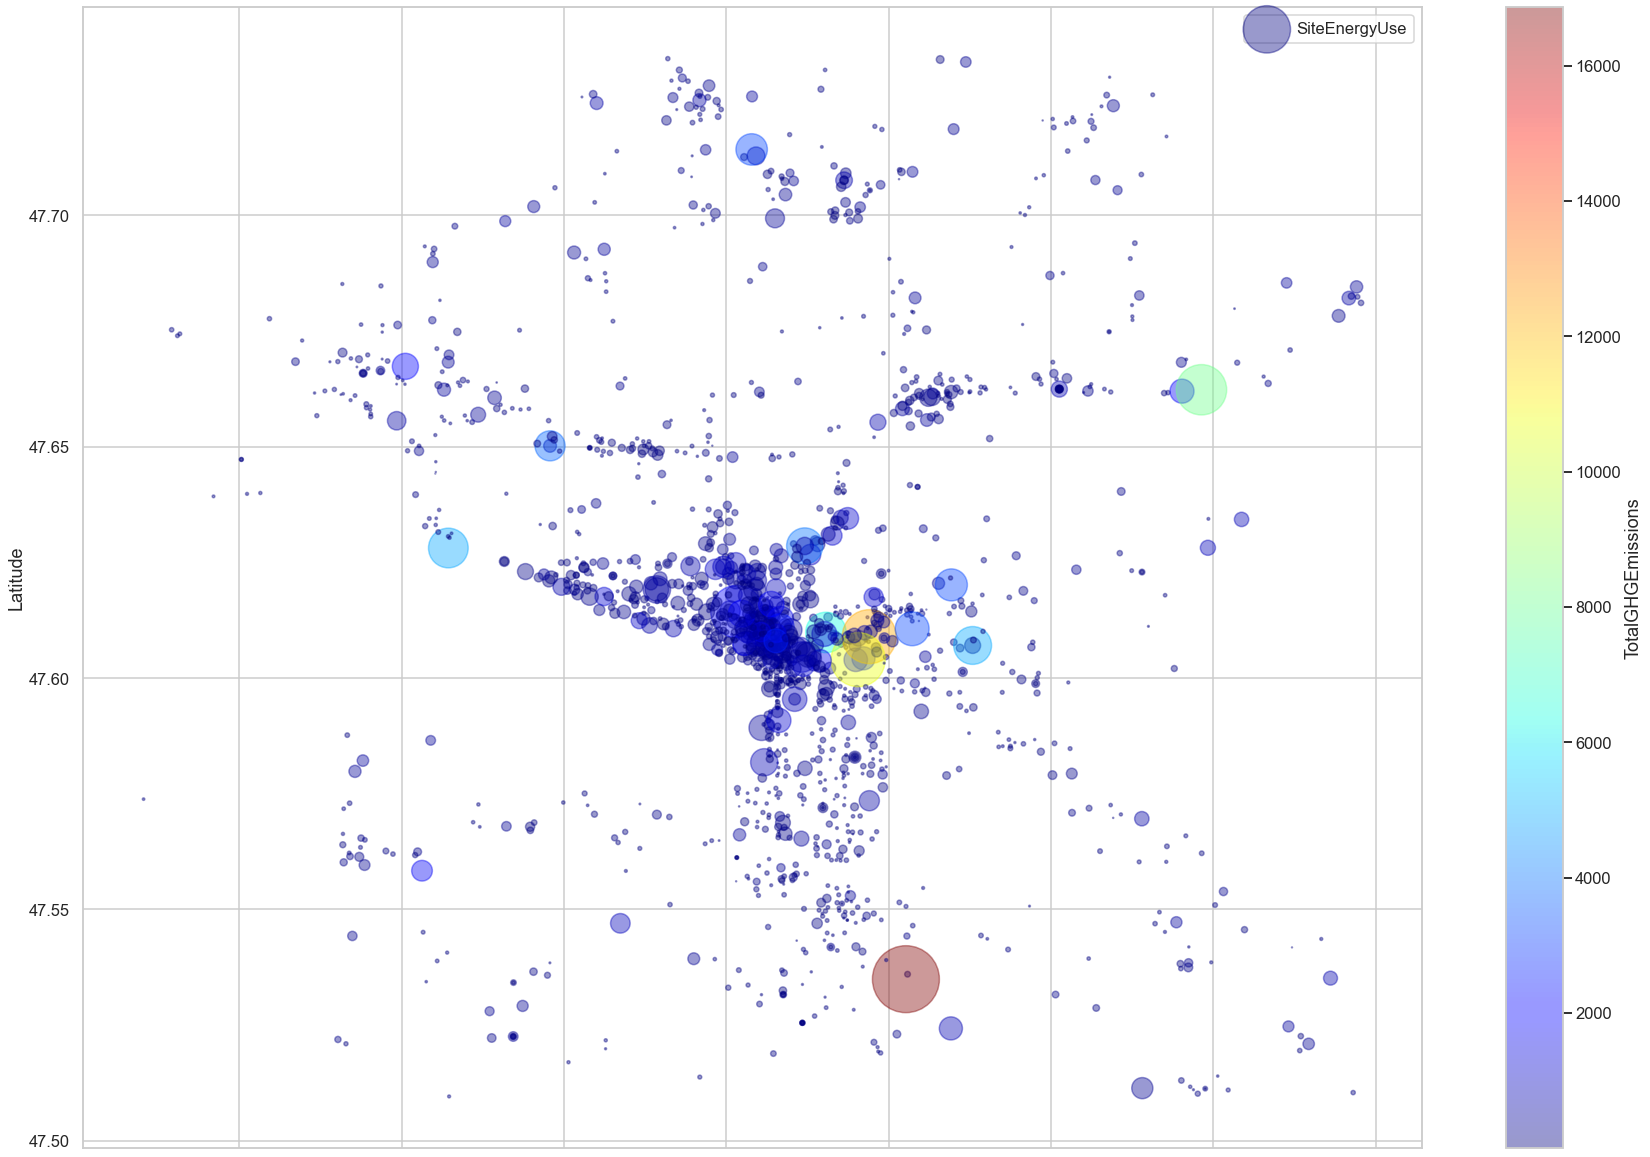

In [237]:
data.plot(kind ="scatter", x ="Longitude", y ="Latitude", alpha = 0.4,
             s = data["SiteEnergyUse(kBtu)"]/ 100000, label ="SiteEnergyUse", figsize =(30,21),
             c ="TotalGHGEmissions", cmap = plt.get_cmap("jet"), colorbar = True, )
plt.legend()

La visualisation a été effectuée et ne permet pas de distinguer de motif particulier permettant de corréler la géographie à la consommation ou à l'émission de GHG. Nous n'avons plus besoin des coordonnées 'Latitude' et 'Longitude', que nous supprimons.

In [238]:
col_to_drop = ['Latitude', 'Longitude', ]
data.drop(col_to_drop, axis = 1, inplace = True)

In [239]:
data_count_9 = data.count().sum()
data_shape_9 = data.shape
data_nan_9 = data.isnull().sum().sum()
step_9 = "Latitude et Longitude"
nb_steps += 1

# 5 | Analyse exploratoire / Feature Engineering | Step 10 à 12

Le jeu de données est maintenant nettoyé, nous pouvons l'analyser.

## 5.1 | Analyse univariée | ajout ENERGYSTAR_Color | Passage au Log | Step 10

### Mise à jour de data_num et data_cat

In [240]:
data_num = [item for item in data_num if item in data.columns]

In [241]:
data_cat = [item for item in data.columns if item not in data_num]

In [242]:
data_num.append('YearBuilt')
data_cat.remove('YearBuilt')

### 5.1.1 | Données qualitatives | La répartition des bâtiments est assez inégale:
-  plutôt du **non résidentiel** (comme attendu, mais peu d'autres types principaux)
-  hormis l'usage "Other", **majorité de "Small & Mid-size Office"** et **"Warehouse"**
-  encore plus visible en **LargestPropertyUseType : Office** puis **Non-Refrigerated Warehouse**
-  le **second usage** renseigné est majoritairement le **parking**, puis les **bureaux**
-  **répartition inégale** des sites **par quartier (ZipCode)** (5 ZipCodes = 40% des indiv., nous avons retiré les habitations).

In [243]:
data_cat

['BuildingType',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ZipCode']

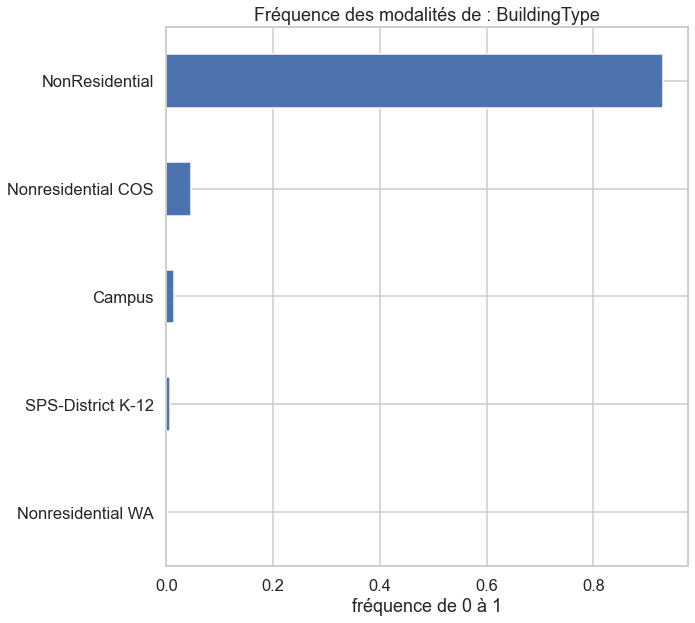

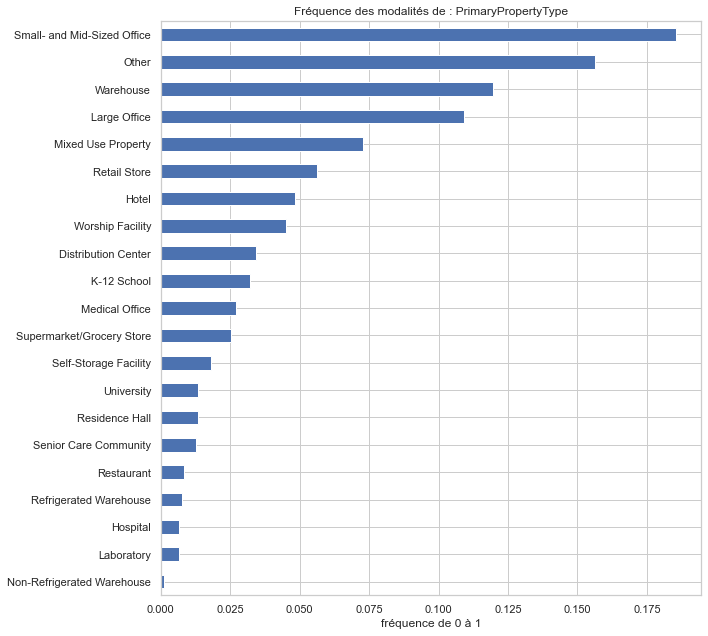

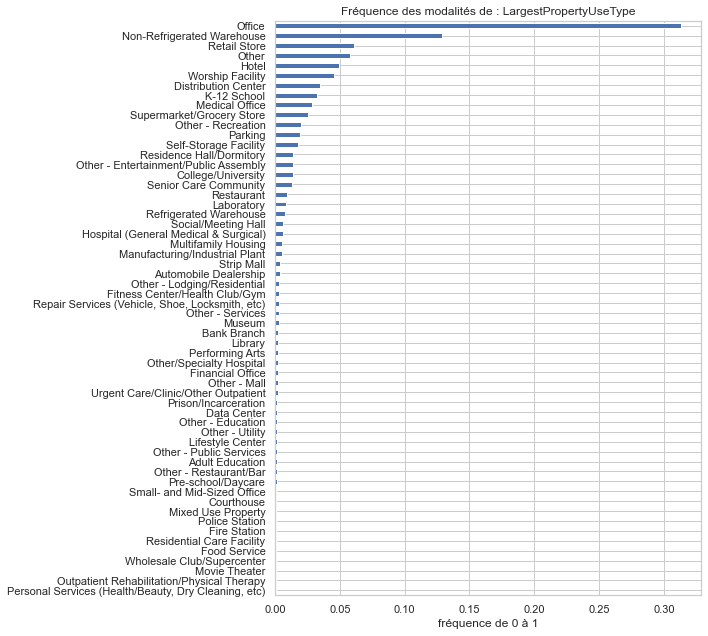

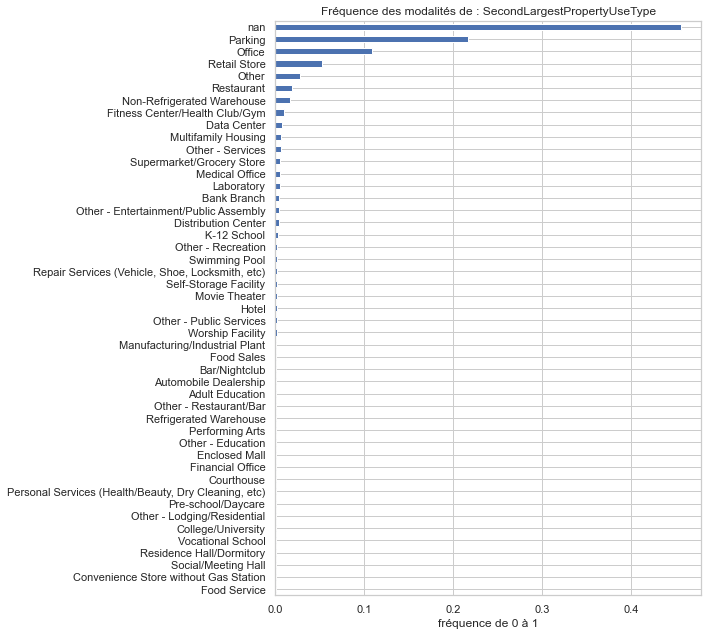

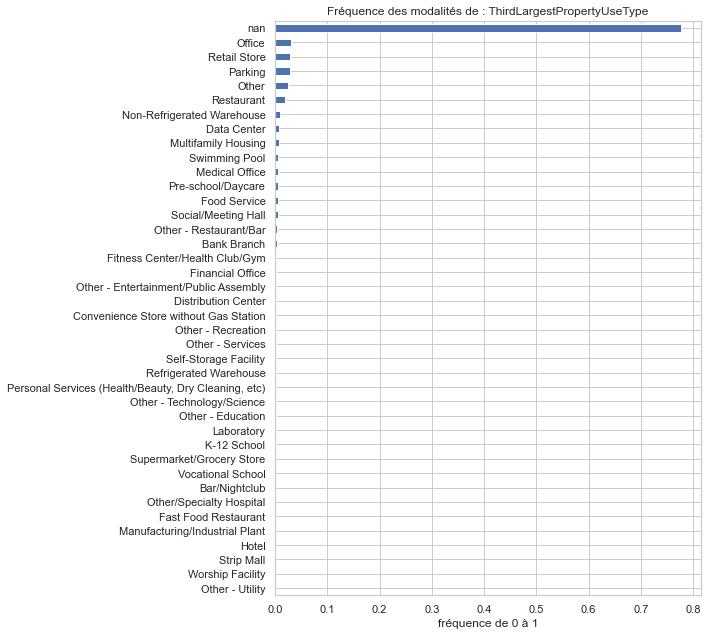

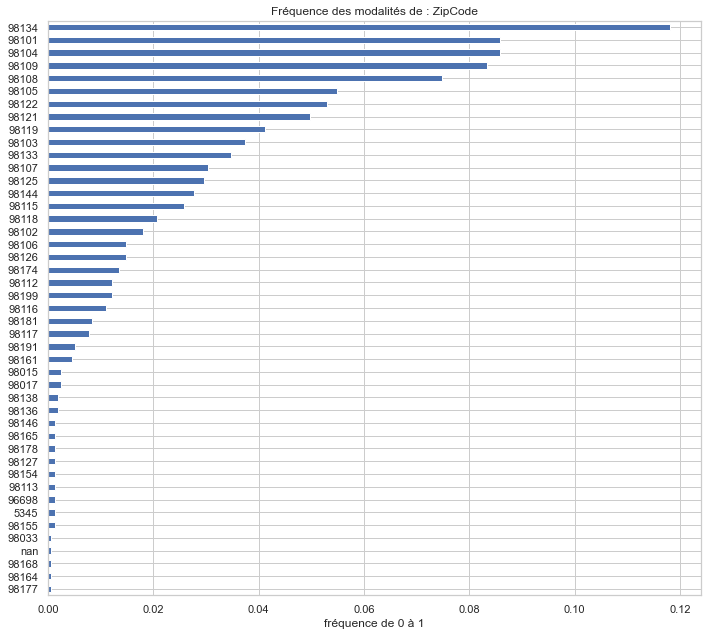

In [244]:
for column in data_cat:
    chaine = 'Fréquence des modalités de : ' + column
    plt.figure(figsize=(10,9))
    data[column].value_counts(normalize=True, ascending = True).plot(kind='barh') #normalize pour avoir les fréquences
    plt.title(chaine)
    plt.xlabel("fréquence de 0 à 1")
    plt.tight_layout()
    
    sns.set_context("notebook") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
    
    plt.show()

à noter : il semble que des nan résiduels soient encore présents parmi les ZipCode, nous allons les supprimer :

In [245]:
mask = data['ZipCode'] == 'nan'

In [246]:
data[mask]

BuildingType PrimaryPropertyType  YearBuilt  \
OSEBuildingID_DataYear                                                  
25325_2016              NonResidential    Worship Facility       1906   

                        NumberofBuildings  NumberofFloors  PropertyGFATotal  \
OSEBuildingID_DataYear                                                        
25325_2016                            1.0             1.0             26440   

                        PropertyGFAParking  PropertyGFABuilding(s)  \
OSEBuildingID_DataYear                                               
25325_2016                               0                   26440   

                       LargestPropertyUseType  LargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                                                     
25325_2016                   Worship Facility                    26440.0   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25325_2016                                      nan   

                        SecondLargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                                    
25325_2016                                          0.0   

                       ThirdLargestPropertyUseType  \
OSEBuildingID_DataYear                               
25325_2016                                     nan   

                        ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
OSEBuildingID_DataYear                                                    
25325_2016                                         0.0             91.0   

                        SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
OSEBuildingID_DataYear                                         
25325_2016                     27.200001           46.200001   

                        SiteEnergyUse(kBtu)  TotalGHGEmissions  \
OSEBuildingID_DataYear                                           
25325_2016                      719905.1875              27.93   

                        GHGEmissionsIntensity ZipCode  SteamUse_Perc  \
OSEBuildingID_DataYear                                                 
25325_2016                               1.06     nan            0.0   

                        Electricity_Perc  NaturalGas_Perc  DistKm_CityCenter  
OSEBuildingID_DataYear                                                        
25325_2016                         31.03            68.97              2.099

In [247]:
data = data[~mask]

### 5.1.2 | Données quantitatives & passage au Log | Une répartition là aussi plutôt inégale | Step 10:
-  données de **2016** majoritaires (comme attendu, keep = 'last')
-  créations de bâtiments plus **soutenue après-guerre**,
-  sites constitués de **1 bâtiment de moins de 10 étages** majoritairement,
-  des distribution de **consommation d'énergie** similaires et ramassées sur les valeurs basses
-  une répartition des **ENERGYSTARScore** plutôt **flatteuse** (selon le scorecard, on serait plutôt dans le vert).

#### 5.1.2.1 | ENERGYSTAR_Color

**ENERGYSTAR_Color** : J'ai envisagé dans un premier temps d'introduire une notion simplifiée de l'ENERGYSTAR Score, qui serait un indicateur sur 3 couleurs, pour faciliter la possibilité de modélisation.

Depuis le site : https://www.energystar.gov/buildings/tools-and-resources/sample_energy_star_scorecard
 - Green: ENERGY STAR score = 75 – 100
 - Yellow: ENERGY STAR score = 26 – 74
 - Red: ENERGY STAR score = 0 – 25
 
**Après relecture de la mission :**<br>
Le projet ne demande ni l'utilisation de cette grandeur, ni sa modélisation.<br>
J'ai donc conservé les étapes de sa création ci-dessous pour mémoire, mais **je n'exporterai pas ce flag ENERGYSTAR_Color (Green, Yellow, Red)** avec le jeu de données, afin ne pas surcharger inutilement le notebook de modélisation.

In [248]:
# pd.set_option('display.max_rows', 2000)
# data['ENERGYSTARScore']

In [249]:
# On utilise la fonction cut pour découper la page de données
# ENERGYSTARScore en intervalles de longueur égale à 25.

bins = pd.IntervalIndex.from_tuples([(0, 25), (25, 75), (75, 100)])
data['ENERGYSTAR_Color'] = pd.cut(data['ENERGYSTARScore'], bins)
x = pd.cut(data['ENERGYSTAR_Color'].to_list(),bins)
x.categories = ['Red', 'Yellow', 'Green']
data['ENERGYSTAR_Color'] = x

In [250]:
data.head()

BuildingType PrimaryPropertyType  YearBuilt  \
OSEBuildingID_DataYear                                                  
25042_2015              NonResidential               Other       1966   
24904_2015              NonResidential  Mixed Use Property       1928   
25455_2015              NonResidential               Other       1922   
25654_2015              NonResidential        Retail Store       1900   
23163_2015              NonResidential      Medical Office       1995   

                        NumberofBuildings  NumberofFloors  PropertyGFATotal  \
OSEBuildingID_DataYear                                                        
25042_2015                            1.0             2.0             33332   
24904_2015                            1.0             2.0             23000   
25455_2015                            1.0             1.0             23050   
25654_2015                            1.0             2.0             21600   
23163_2015                            1.0             4.0             43813   

                        PropertyGFAParking  PropertyGFABuilding(s)  \
OSEBuildingID_DataYear                                               
25042_2015                               0                   33332   
24904_2015                               0                   23000   
25455_2015                               0                   23050   
25654_2015                               0                   21600   
23163_2015                           23086                   20727   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   
23163_2015                                          Medical Office   

                        LargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                              
25042_2015                                33332.0   
24904_2015                                23000.0   
25455_2015                                23050.0   
25654_2015                                21600.0   
23163_2015                                45145.0   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25042_2015                                  Parking   
24904_2015                                      nan   
25455_2015                                      nan   
25654_2015                                      nan   
23163_2015                                      nan   

                        SecondLargestPropertyUseTypeGFA  \
OSEBuildingID_DataYear                                    
25042_2015                                          0.0   
24904_2015                                          0.0   
25455_2015                                          0.0   
25654_2015                                          0.0   
23163_2015                                          0.0   

                       ThirdLargestPropertyUseType  \
OSEBuildingID_DataYear                               
25042_2015                                     nan   
24904_2015                                     nan   
25455_2015                                     nan   
25654_2015                                     nan   
23163_2015                                     nan   

                        ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
OSEBuildingID_DataYear                                                    
25042_2015                                         0.0              NaN   
24904_2015                                         0.0              NaN   
25455_2015                                         0.0              NaN   
25654_2015                                         0

#### 5.1.2.2 | data_num - distributions AVANT passage au Log

Le **passage au log** a pour objectif principal d'**aider les algorithmes** de machine learning à travailler de manière plus **précise et efficace** en transformant les variables explicatives et cible de manière bijective, de manière à **amplifier les variations** tout en ne **modifiant pas les logiques d'optimisation**.<br>

Ainsi, nous allons appliquer la fonction log aux **distributions** quantitatives **trop ramassées d'un côté (skewed) ou trop basses (shallowed)**.<br>

Procédons tout d'abord à une **sélection des variables à passer au log** :

In [251]:
pd.set_option('display.max_rows', 20)

In [252]:
data_num

['ENERGYSTARScore',
 'GHGEmissionsIntensity',
 'LargestPropertyUseTypeGFA',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'SecondLargestPropertyUseTypeGFA',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SourceEUI(kBtu/sf)',
 'ThirdLargestPropertyUseTypeGFA',
 'TotalGHGEmissions',
 'SteamUse_Perc',
 'Electricity_Perc',
 'NaturalGas_Perc',
 'DistKm_CityCenter',
 'YearBuilt']

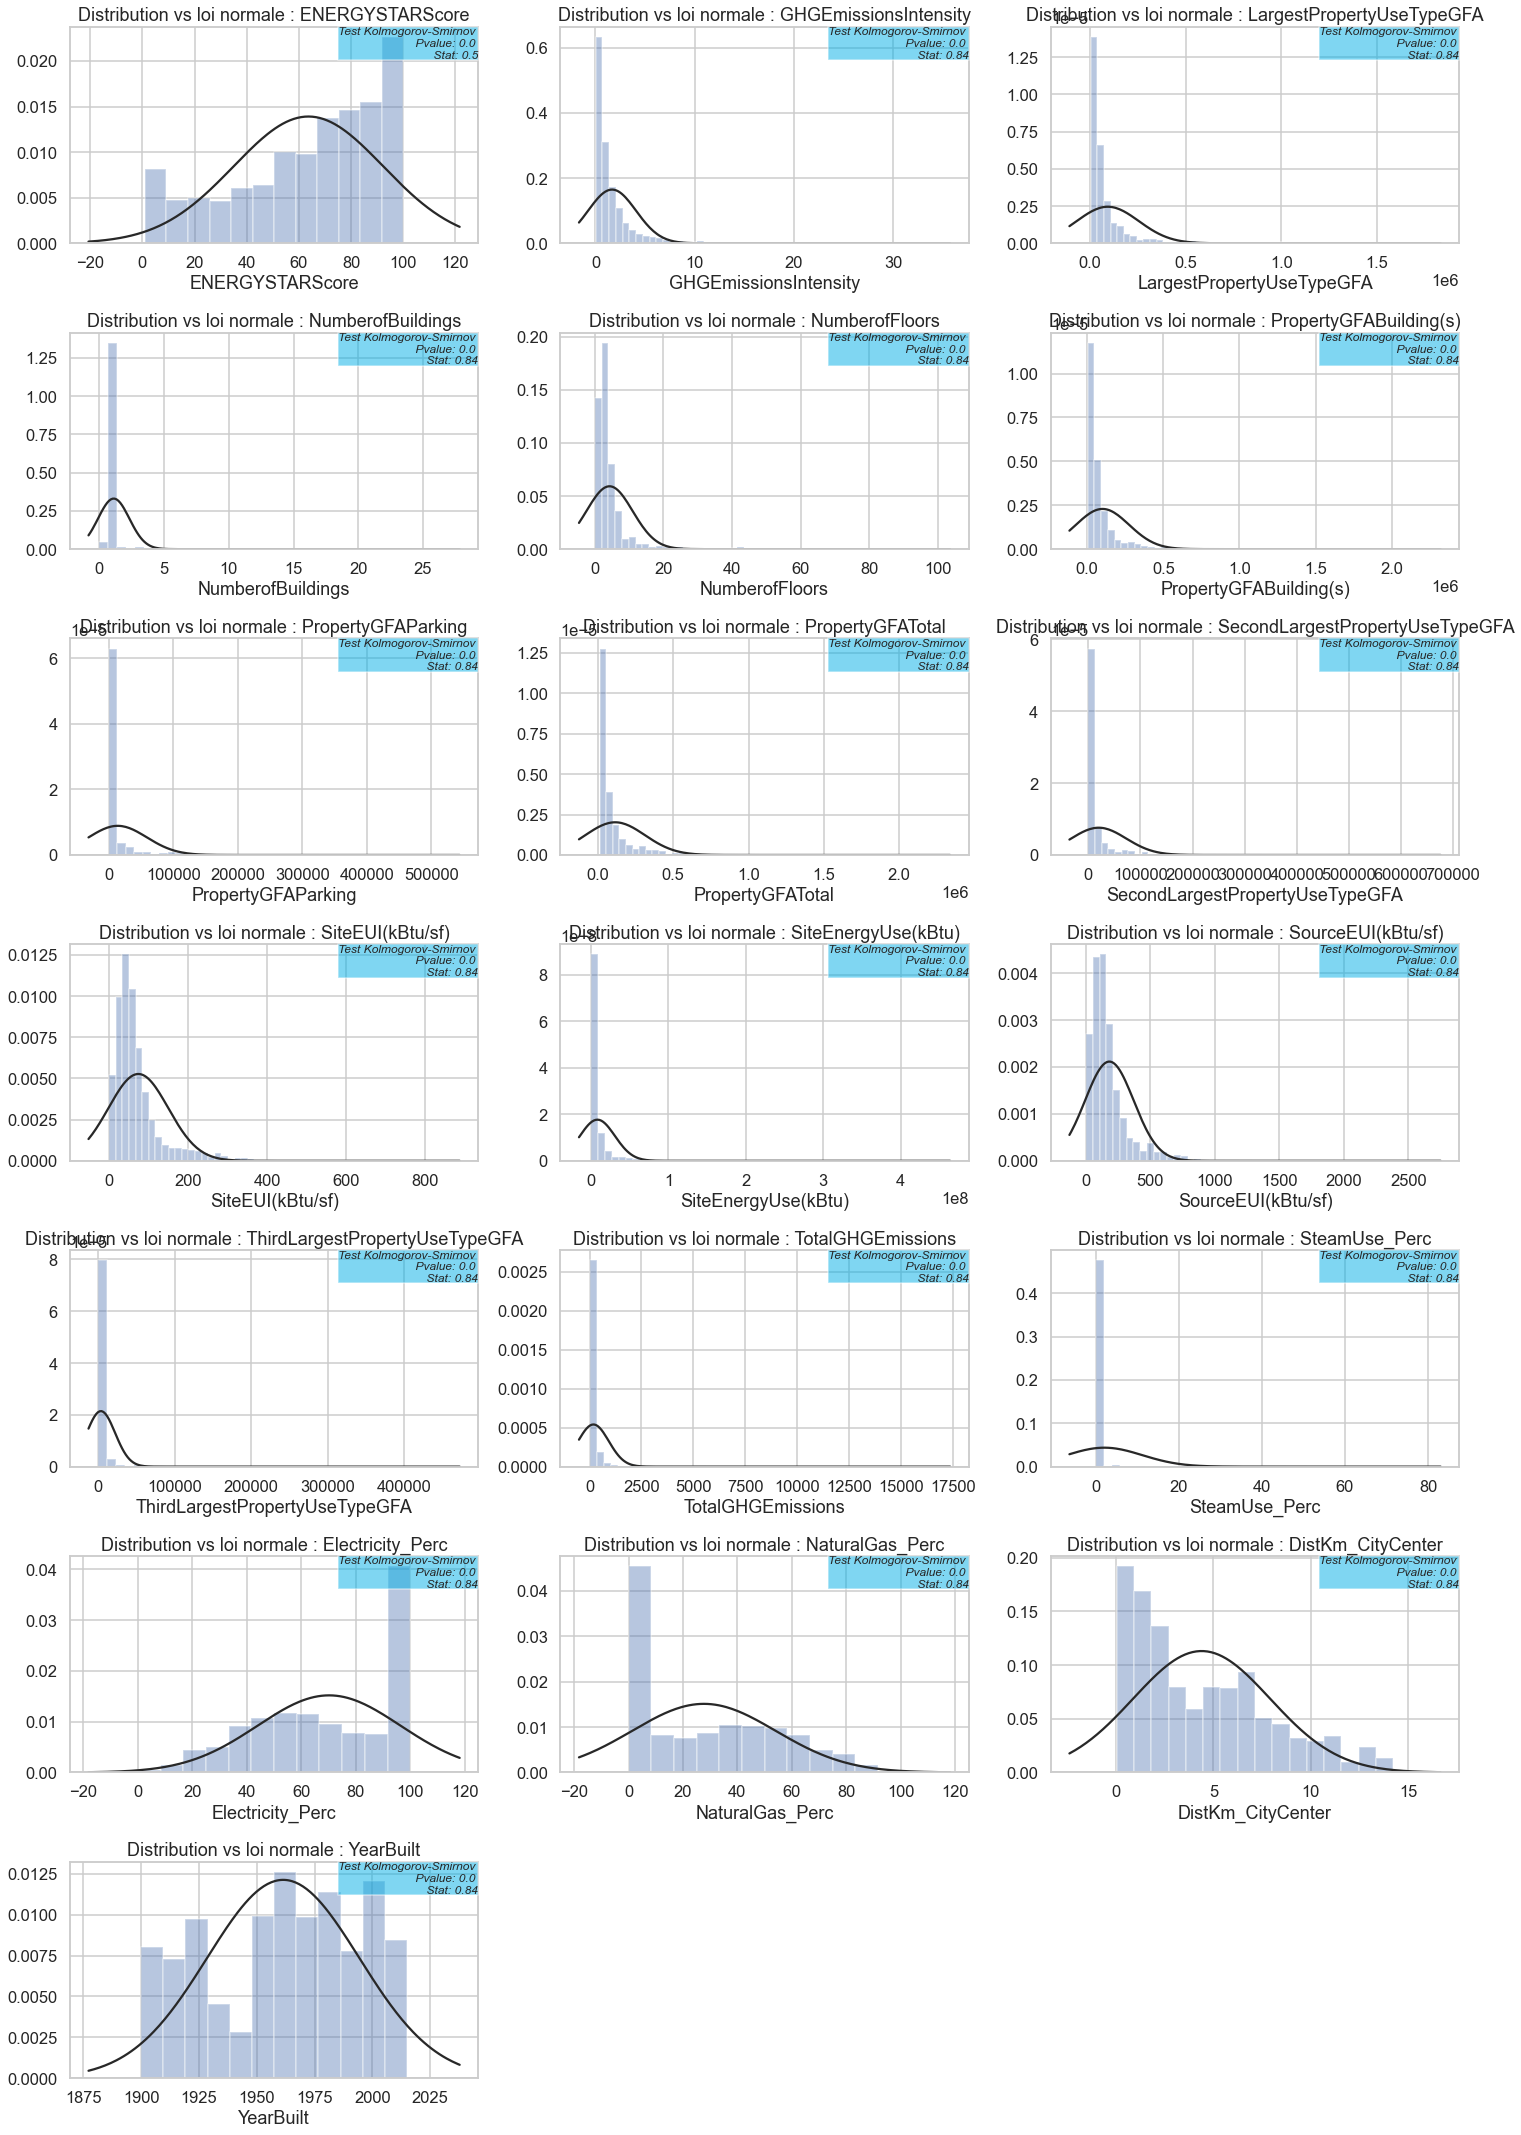

In [253]:
warnings.filterwarnings('ignore')

sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(data_num)):
    fig.add_subplot(len(data_num)//3+1,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = data_num[i]
    kstest = stats.kstest(data[colonne].notnull(),'norm')
    ax = sns.distplot(data[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
    
    fig.tight_layout()
    
plt.show()

#### 5.1.2.3 | Passage au Log des distributions numériques non normales | Step 10

In [254]:
data_log_cols = ['PropertyGFATotal', 'PropertyGFAParking',
                 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
                 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
                 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
                 'SteamUse_Perc', 'Electricity_Perc', 'NaturalGas_Perc']

In [255]:
# Fonction qui remplace par son logarithme chaque
# valeur non négative du jeu de colonnes spécifié
# (en ajoutant 1 afin de considérer 0).
# on conserve les colonnes originales dans data (pas de backup)

def switch_log(columns):
    # on passe au log les variables sélectionnées dans columns
    for column in columns:
        col_name = str(column + '_log')
        shift = 1 - data[column].min()
        data[col_name] = data[column].apply(lambda x: np.log(x + shift))
        data.drop(column, axis = 1, inplace = True)

In [256]:
switch_log(data_log_cols)

In [257]:
data.head(5)

BuildingType PrimaryPropertyType  YearBuilt  \
OSEBuildingID_DataYear                                                  
25042_2015              NonResidential               Other       1966   
24904_2015              NonResidential  Mixed Use Property       1928   
25455_2015              NonResidential               Other       1922   
25654_2015              NonResidential        Retail Store       1900   
23163_2015              NonResidential      Medical Office       1995   

                        NumberofBuildings  NumberofFloors  \
OSEBuildingID_DataYear                                      
25042_2015                            1.0             2.0   
24904_2015                            1.0             2.0   
25455_2015                            1.0             1.0   
25654_2015                            1.0             2.0   
23163_2015                            1.0             4.0   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   
23163_2015                                          Medical Office   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25042_2015                                  Parking   
24904_2015                                      nan   
25455_2015                                      nan   
25654_2015                                      nan   
23163_2015                                      nan   

                       ThirdLargestPropertyUseType  ENERGYSTARScore ZipCode  \
OSEBuildingID_DataYear                                                        
25042_2015                                     nan              NaN   98144   
24904_2015                                     nan              NaN   98119   
25455_2015                                     nan              NaN   98109   
25654_2015                                     nan              NaN   98104   
23163_2015                                     nan             76.0   98144   

                        DistKm_CityCenter ENERGYSTAR_Color  \
OSEBuildingID_DataYear                                       
25042_2015                          2.606              NaN   
24904_2015                          4.549              NaN   
25455_2015                          2.300              NaN   
25654_2015                          0.811              NaN   
23163_2015                          1.537            Green   

                        PropertyGFATotal_log  PropertyGFAParking_log  \
OSEBuildingID_DataYear                                                 
25042_2015                         10.000977                0.000000   
24904_2015                          9.368711                0.000000   
25455_2015                          9.372969                0.000000   
25654_2015                          9.241451                0.000000   
23163_2015                         10.389887               10.047025   

                        PropertyGFABuilding(s)_log  \
OSEBuildingID_DataYear                               
25042_2015                               10.298801   
24904_2015                                9.871223   
25455_2015                                9.873801   
25654_2015                                9.796181   
23163_2015                                9.746366   

                        LargestPropertyUseTypeGFA_log  \
OSEBuildingID_DataYear                                  
25042_2015                                  10.228357   
24904_2015                                   9.761060   
25455_2015                                   9.763938   
25654_2015                                   9.6769

Une fois les titres de colonne modifiés (ajout du suffixe _log), nous mettons à jour la définition des **data_num** en considérant toutes les colonnes non comprises dans **data_cat** qui sont inchangées par l'opération du log : 

In [258]:
data_num = [item for item in data.columns if item not in data_cat and item in data.select_dtypes(include=[np.number]).columns]

In [259]:
data_num

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'DistKm_CityCenter',
 'PropertyGFATotal_log',
 'PropertyGFAParking_log',
 'PropertyGFABuilding(s)_log',
 'LargestPropertyUseTypeGFA_log',
 'SecondLargestPropertyUseTypeGFA_log',
 'ThirdLargestPropertyUseTypeGFA_log',
 'SiteEUI(kBtu/sf)_log',
 'SourceEUI(kBtu/sf)_log',
 'SiteEnergyUse(kBtu)_log',
 'TotalGHGEmissions_log',
 'GHGEmissionsIntensity_log',
 'SteamUse_Perc_log',
 'Electricity_Perc_log',
 'NaturalGas_Perc_log']

#### 5.1.2.4 | data_num -  distributions APRES passage au Log

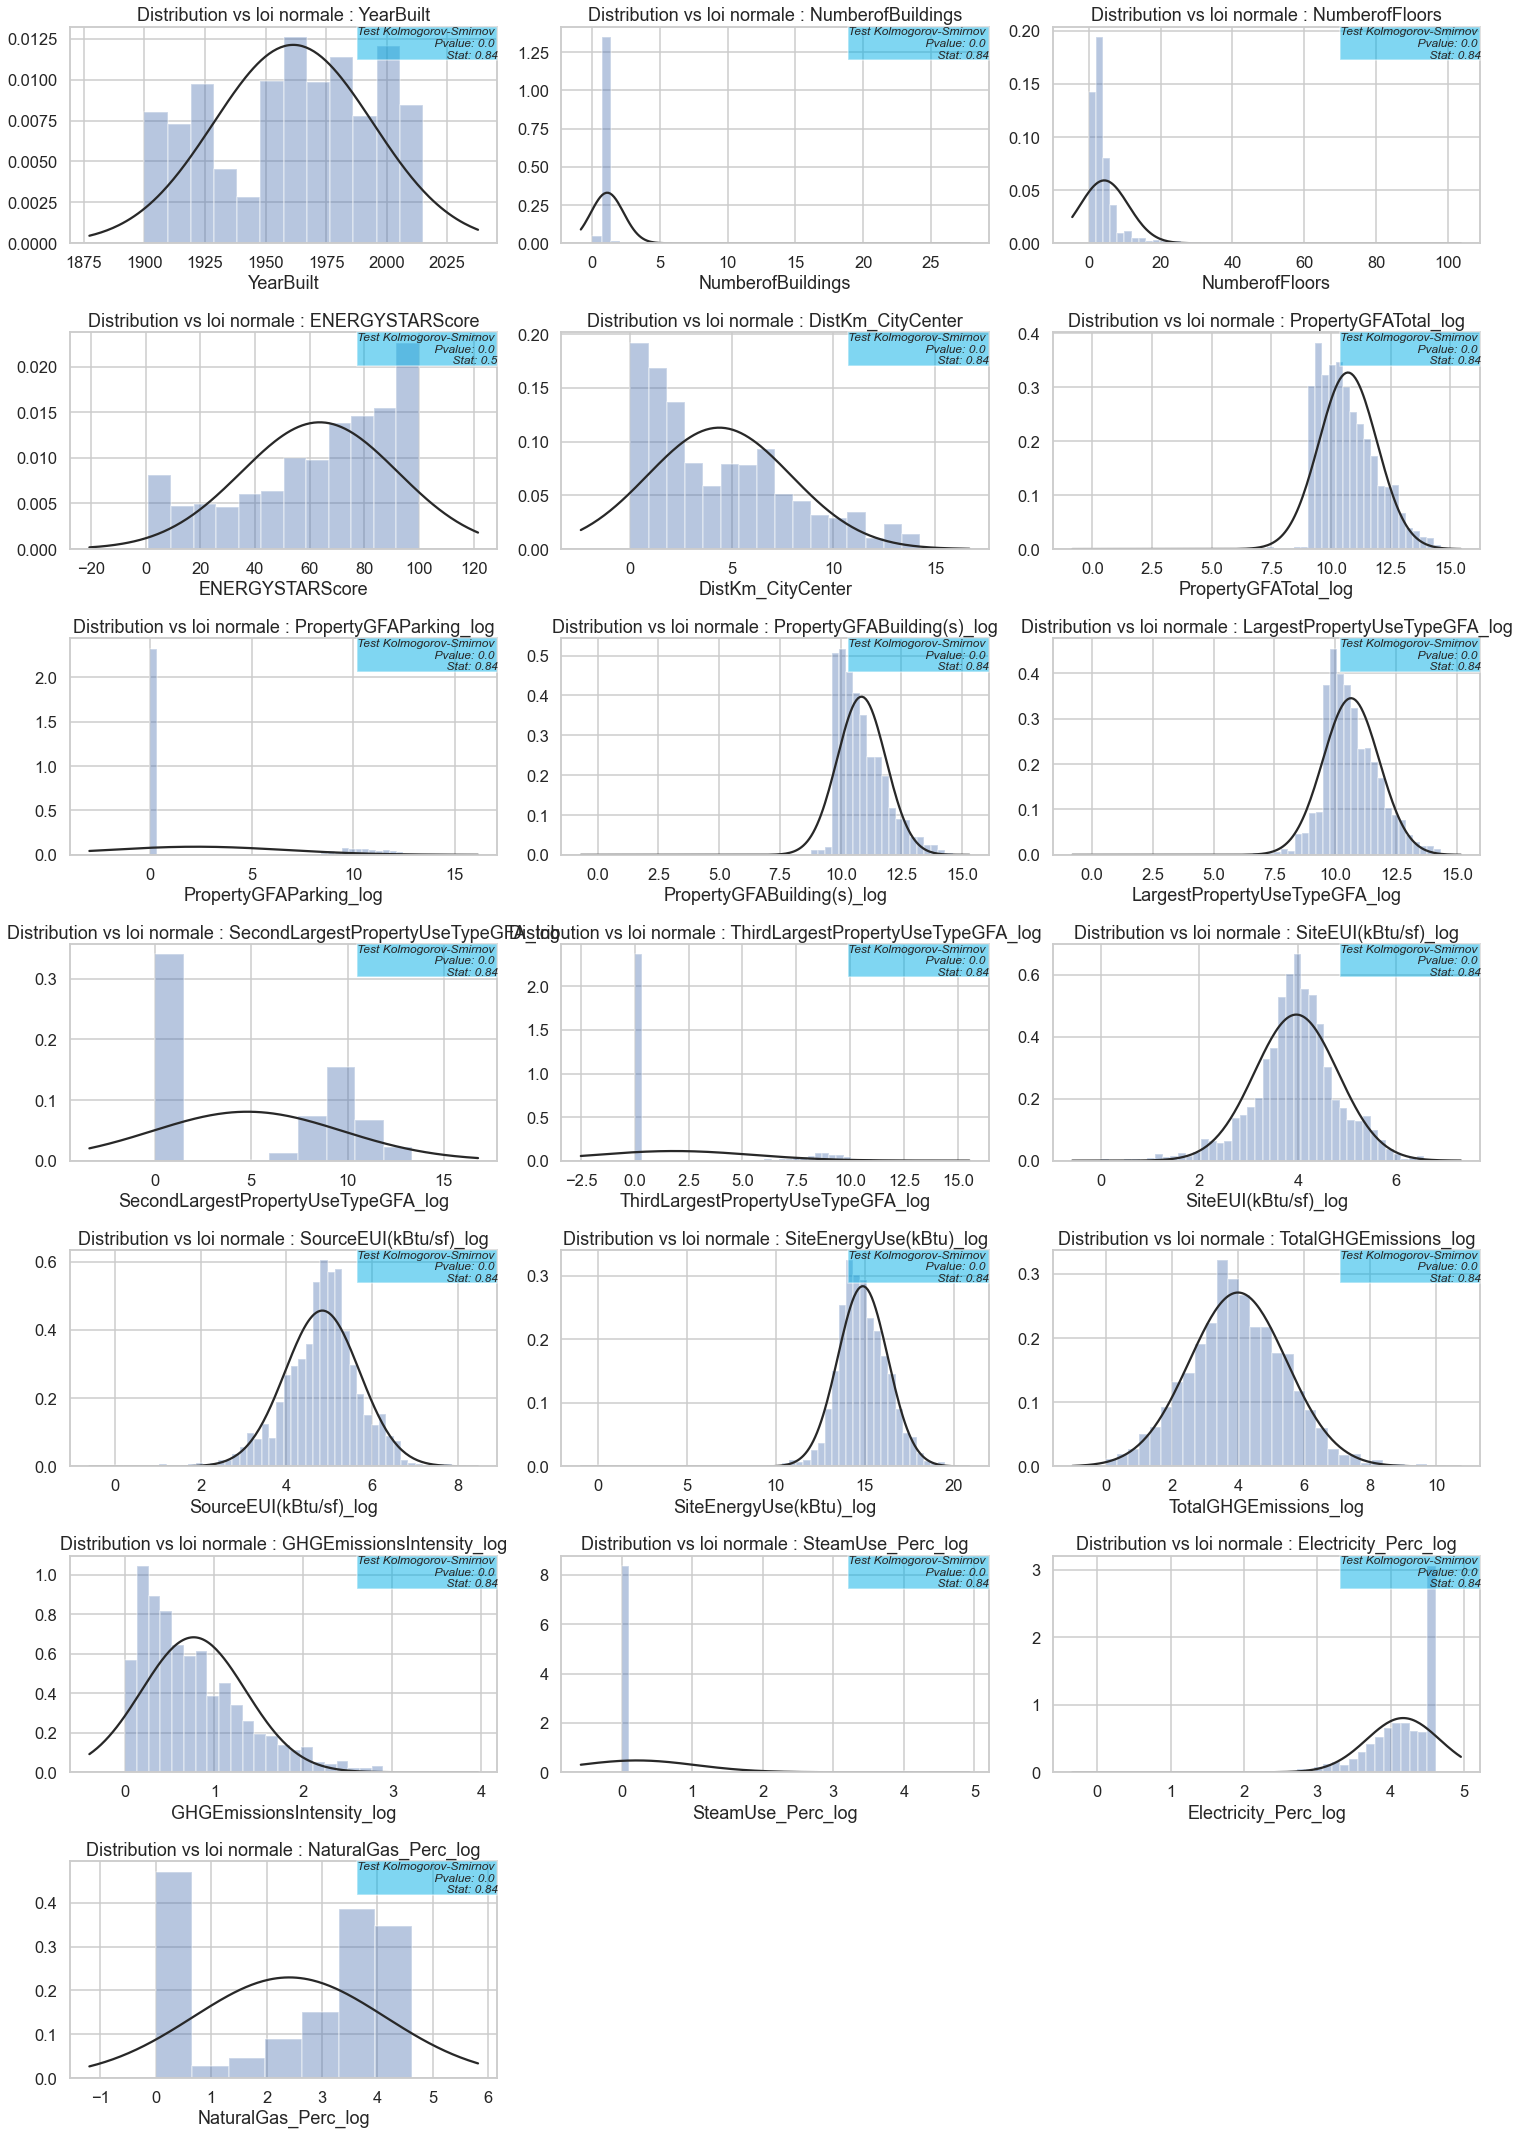

In [260]:
warnings.filterwarnings('ignore')

sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub  = 0
for i in range(len(data_num)):
    fig.add_subplot(len(data_num)//3+1,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = data_num[i]
    kstest = stats.kstest(data[colonne].notnull(),'norm')
    ax = sns.distplot(data[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
    
    fig.tight_layout()
    
plt.show()

Nous avons donc maintenant un jeu de données **data** pour lequel certaines données numériques ont été **passées au log** pour faciliter la tâche des algorithme de ML dans l'étape suivante de modélisation.

In [261]:
data_count_10 = data.count().sum()
data_shape_10 = data.shape
data_nan_10 = data.isnull().sum().sum()
step_10 = "EnergyStar_Color et Passage au Log"
nb_steps += 1

In [262]:
data.head()

BuildingType PrimaryPropertyType  YearBuilt  \
OSEBuildingID_DataYear                                                  
25042_2015              NonResidential               Other       1966   
24904_2015              NonResidential  Mixed Use Property       1928   
25455_2015              NonResidential               Other       1922   
25654_2015              NonResidential        Retail Store       1900   
23163_2015              NonResidential      Medical Office       1995   

                        NumberofBuildings  NumberofFloors  \
OSEBuildingID_DataYear                                      
25042_2015                            1.0             2.0   
24904_2015                            1.0             2.0   
25455_2015                            1.0             1.0   
25654_2015                            1.0             2.0   
23163_2015                            1.0             4.0   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   
23163_2015                                          Medical Office   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25042_2015                                  Parking   
24904_2015                                      nan   
25455_2015                                      nan   
25654_2015                                      nan   
23163_2015                                      nan   

                       ThirdLargestPropertyUseType  ENERGYSTARScore ZipCode  \
OSEBuildingID_DataYear                                                        
25042_2015                                     nan              NaN   98144   
24904_2015                                     nan              NaN   98119   
25455_2015                                     nan              NaN   98109   
25654_2015                                     nan              NaN   98104   
23163_2015                                     nan             76.0   98144   

                        DistKm_CityCenter ENERGYSTAR_Color  \
OSEBuildingID_DataYear                                       
25042_2015                          2.606              NaN   
24904_2015                          4.549              NaN   
25455_2015                          2.300              NaN   
25654_2015                          0.811              NaN   
23163_2015                          1.537            Green   

                        PropertyGFATotal_log  PropertyGFAParking_log  \
OSEBuildingID_DataYear                                                 
25042_2015                         10.000977                0.000000   
24904_2015                          9.368711                0.000000   
25455_2015                          9.372969                0.000000   
25654_2015                          9.241451                0.000000   
23163_2015                         10.389887               10.047025   

                        PropertyGFABuilding(s)_log  \
OSEBuildingID_DataYear                               
25042_2015                               10.298801   
24904_2015                                9.871223   
25455_2015                                9.873801   
25654_2015                                9.796181   
23163_2015                                9.746366   

                        LargestPropertyUseTypeGFA_log  \
OSEBuildingID_DataYear                                  
25042_2015                                  10.228357   
24904_2015                                   9.761060   
25455_2015                                   9.763938   
25654_2015                                   9.6769

## 5.2 | Analyse bivariée | Drop ENERGYSTAR_Color | Step 11

### 5.2.1 | Matrice des Corrélations

Premiers constats sur les corrélations:
-  Les variables à prédire (SiteEnergyUse(kBTU) et TotalGHGEmissions) semblent corrélées de manière significative à :
 - la surface totale (surtout buildings, 2 à 3x plus que pour les parkings)
-  faible corrélation avec l'année de construction ou avec l'ENERGYSTARScore
-  faible corrélation (0,15 à 0,4) avec le nombre de bâtiments ou d'étages

La carte de chaleur des corrélations :


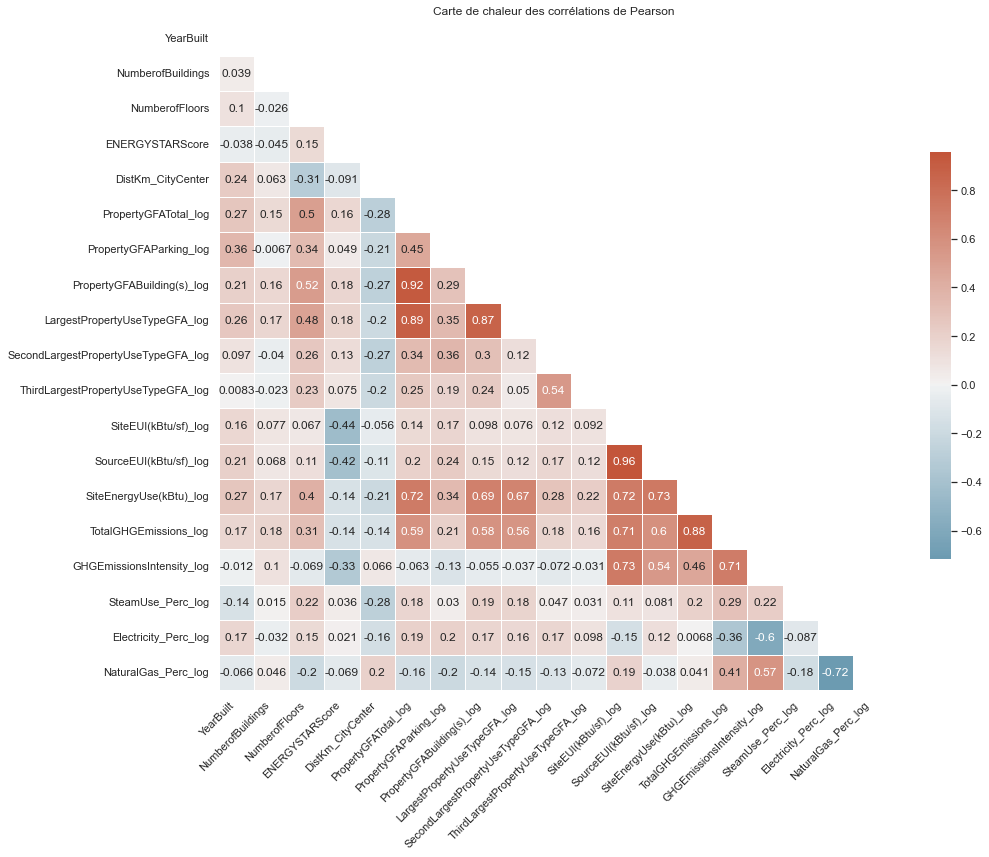

In [263]:
corr_data_num = data.corr(method='pearson').copy()

sns.set_context("notebook")

# On genère un masque pour le triangle du dessus
mask_cor = np.triu(np.ones_like(corr_data_num, dtype=bool))

# initialisation de la figure matplotlib
plt.figure(figsize=(15, 15))

# On génère une palette de couleurs personalisée
cmap_cor = sns.diverging_palette(230, 20, as_cmap=True)

# On génère une carte de chaleur avec le masque et le ratio d'aspect
chart = sns.heatmap(corr_data_num, annot=True, fmt=".2g", mask = mask_cor, cmap = cmap_cor, center=0,  
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# annot=True pour voir les valeurs (retirer si trop de cases, que la couleur)
# .1e = scientific notation with 1 decimal point (standard form)
# .2f = 2 decimal places
# .3g = 3 significant figures
# .4% = percentage with 4 decimal places

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Carte de chaleur des corrélations de Pearson')

print("La carte de chaleur des corrélations :")

plt.show()

Identifions les corrélations les plus fortes (supérieures à 0,7) :

In [264]:
corr_data_num

YearBuilt  NumberofBuildings  \
YearBuilt                             1.000000           0.039213   
NumberofBuildings                     0.039213           1.000000   
NumberofFloors                        0.101052          -0.026387   
ENERGYSTARScore                      -0.037883          -0.045463   
DistKm_CityCenter                     0.237776           0.063365   
PropertyGFATotal_log                  0.265288           0.147107   
PropertyGFAParking_log                0.355550          -0.006696   
PropertyGFABuilding(s)_log            0.211078           0.164923   
LargestPropertyUseTypeGFA_log         0.263399           0.168809   
SecondLargestPropertyUseTypeGFA_log   0.097201          -0.039758   
ThirdLargestPropertyUseTypeGFA_log    0.008307          -0.022902   
SiteEUI(kBtu/sf)_log                  0.162066           0.077008   
SourceEUI(kBtu/sf)_log                0.205629           0.068421   
SiteEnergyUse(kBtu)_log               0.267921           0.170669   
TotalGHGEmissions_log                 0.170532           0.179312   
GHGEmissionsIntensity_log            -0.011526           0.101208   
SteamUse_Perc_log                    -0.140000           0.014787   
Electricity_Perc_log                  0.168334          -0.031616   
NaturalGas_Perc_log                  -0.066118           0.045917   

                                     NumberofFloors  ENERGYSTARScore  \
YearBuilt                                  0.101052        -0.037883   
NumberofBuildings                         -0.026387        -0.045463   
NumberofFloors                             1.000000         0.147641   
ENERGYSTARScore                            0.147641         1.000000   
DistKm_CityCenter                         -0.312101        -0.090709   
PropertyGFATotal_log                       0.504682         0.160364   
PropertyGFAParking_log                     0.335294         0.049091   
PropertyGFABuilding(s)_log                 0.516564         0.178647   
LargestPropertyUseTypeGFA_log              0.484326         0.179375   
SecondLargestPropertyUseTypeGFA_log        0.258310         0.130214   
ThirdLargestPropertyUseTypeGFA_log         0.231267         0.075268   
SiteEUI(kBtu/sf)_log                       0.067409        -0.437652   
SourceEUI(kBtu/sf)_log                     0.114732        -0.416941   
SiteEnergyUse(kBtu)_log                    0.399192        -0.136930   
TotalGHGEmissions_log                      0.307137        -0.138900   
GHGEmissionsIntensity_log                 -0.069210        -0.333716   
SteamUse_Perc_log                          0.222239         0.035608   
Electricity_Perc_log                       0.145588         0.020598   
NaturalGas_Perc_log                       -0.197543        -0.068639   

                                     DistKm_CityCenter  PropertyGFATotal_log  \
YearBuilt                                     0.237776              0.265288   
NumberofBuildings                             0.063365              0.147107   
NumberofFloors                               -0.312101              0.504682   
ENERGYSTARScore                              -0.090709              0.160364   
DistKm_CityCenter                             1.000000             -0.280961   
PropertyGFATotal_log                         -0.280961              1.000000   
PropertyGFAParking_log                       -0.212740              0.453326   
PropertyGFABuilding(s)_log                   -0.269695              0.924168   
LargestPropertyUseTypeGFA_log                -0.201018              0.888886   
SecondLargestPropertyUseTypeGFA_log          -0.267078              0.335672   
ThirdLargestPropertyUseTypeGFA_log           -0.204703              0.248560   
SiteEUI(kBtu/sf)_log                         -0.056007              0.139710   
SourceEUI(kBtu/sf)_log                       -0.106747              0.197796   
SiteEnergyUse(kBtu)_log                      -0.207397              0.720223   
TotalGHGEmissio

In [265]:
corr_min = 0.7
corr_pairs = corr_data_num.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > corr_min)])
               .reset_index().rename(columns={0:'coef_correl'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('coef_correl', ascending=False).head(15)

level_0                        level_1  coef_correl
22         SourceEUI(kBtu/sf)_log           SiteEUI(kBtu/sf)_log     0.958613
20           PropertyGFATotal_log     PropertyGFABuilding(s)_log     0.924168
18  LargestPropertyUseTypeGFA_log           PropertyGFATotal_log     0.888886
16        SiteEnergyUse(kBtu)_log          TotalGHGEmissions_log     0.877741
14     PropertyGFABuilding(s)_log  LargestPropertyUseTypeGFA_log     0.869709
12         SourceEUI(kBtu/sf)_log        SiteEnergyUse(kBtu)_log     0.731697
10      GHGEmissionsIntensity_log           SiteEUI(kBtu/sf)_log     0.728344
8         SiteEnergyUse(kBtu)_log           SiteEUI(kBtu/sf)_log     0.721984
6            PropertyGFATotal_log        SiteEnergyUse(kBtu)_log     0.720223
4           TotalGHGEmissions_log      GHGEmissionsIntensity_log     0.714839
2           TotalGHGEmissions_log           SiteEUI(kBtu/sf)_log     0.708122
0             NaturalGas_Perc_log           Electricity_Perc_log    -0.718910

On peut identifier quelques variables explicatives fortement corrélées entre elles.<br>
Pour chaque cas nous supprimerons une des deux variables afin d'éviter
les corrélations fortes entre variables explicatives durant la phase de modélisation.

In [266]:
var_to_drop = ['SiteEUI(kBtu/sf)_log',\
               'SourceEUI(kBtu/sf)_log',\
               'GHGEmissionsIntensity_log']

In [267]:
# on supprime les colonnes du jeu de données
data.drop(var_to_drop, axis = 1, inplace = True)
# on retire les item de la liste data_num
data_num = [ele for ele in data_num if ele not in var_to_drop]

In [268]:
corr_data_num["TotalGHGEmissions_log"].sort_values( ascending = False)

TotalGHGEmissions_log                  1.000000
SiteEnergyUse(kBtu)_log                0.877741
GHGEmissionsIntensity_log              0.714839
SiteEUI(kBtu/sf)_log                   0.708122
SourceEUI(kBtu/sf)_log                 0.597570
PropertyGFATotal_log                   0.591269
PropertyGFABuilding(s)_log             0.581159
LargestPropertyUseTypeGFA_log          0.559330
NaturalGas_Perc_log                    0.409549
NumberofFloors                         0.307137
SteamUse_Perc_log                      0.293413
PropertyGFAParking_log                 0.211157
SecondLargestPropertyUseTypeGFA_log    0.183532
NumberofBuildings                      0.179312
YearBuilt                              0.170532
ThirdLargestPropertyUseTypeGFA_log     0.158470
DistKm_CityCenter                     -0.137517
ENERGYSTARScore                       -0.138900
Electricity_Perc_log                  -0.361726
Name: TotalGHGEmissions_log, dtype: float64

In [269]:
corr_data_num["SiteEnergyUse(kBtu)_log"].sort_values( ascending = False)

SiteEnergyUse(kBtu)_log                1.000000
TotalGHGEmissions_log                  0.877741
SourceEUI(kBtu/sf)_log                 0.731697
SiteEUI(kBtu/sf)_log                   0.721984
PropertyGFATotal_log                   0.720223
PropertyGFABuilding(s)_log             0.692592
LargestPropertyUseTypeGFA_log          0.669498
GHGEmissionsIntensity_log              0.456374
NumberofFloors                         0.399192
PropertyGFAParking_log                 0.341510
SecondLargestPropertyUseTypeGFA_log    0.277696
YearBuilt                              0.267921
ThirdLargestPropertyUseTypeGFA_log     0.220847
SteamUse_Perc_log                      0.197035
NumberofBuildings                      0.170669
NaturalGas_Perc_log                    0.040546
Electricity_Perc_log                   0.006837
ENERGYSTARScore                       -0.136930
DistKm_CityCenter                     -0.207397
Name: SiteEnergyUse(kBtu)_log, dtype: float64

### 5.2.2 | PairGrid

In [270]:
corr_columns = corr_data_num.columns[((corr_data_num < 1) & (corr_data_num > 0.7)).any(axis=0)]
display(corr_columns)

Index(['PropertyGFATotal_log', 'PropertyGFABuilding(s)_log',
       'LargestPropertyUseTypeGFA_log', 'SiteEUI(kBtu/sf)_log',
       'SourceEUI(kBtu/sf)_log', 'SiteEnergyUse(kBtu)_log',
       'TotalGHGEmissions_log', 'GHGEmissionsIntensity_log'],
      dtype='object')

Un premier pairgrid avec les variables les plus corrélées à la consommation d'énergie et à l'émission de CO2 :

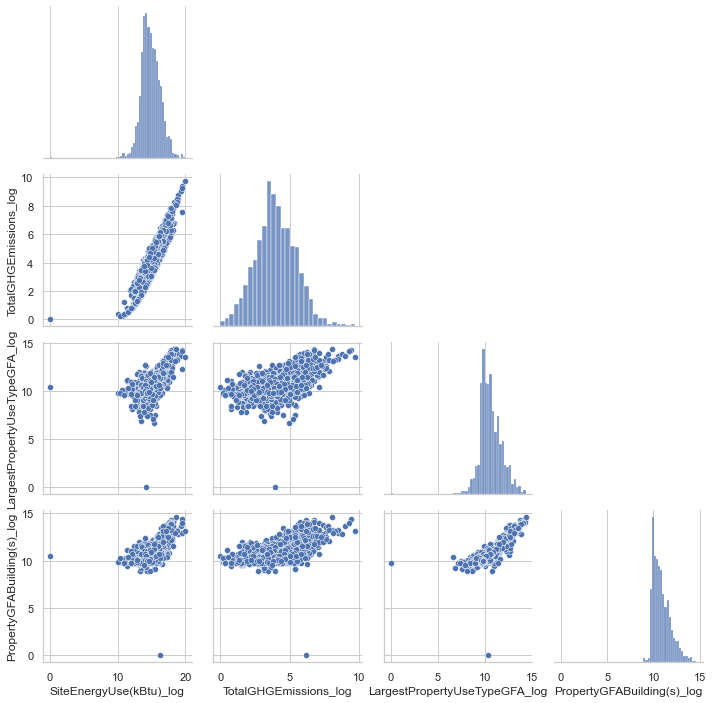

In [271]:
sns.set_context("notebook") # scaling automatique selon type de présentation
data_pairgrid = data.loc[:,['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log', 'LargestPropertyUseTypeGFA_log',
                            'PropertyGFABuilding(s)_log']]
g = sns.PairGrid(data_pairgrid, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(.55, .95))

Les corrélations semblent en effet assez fortes entre ces différents éléments. 

<AxesSubplot:xlabel='PropertyGFABuilding(s)_log', ylabel='SiteEnergyUse(kBtu)_log'>

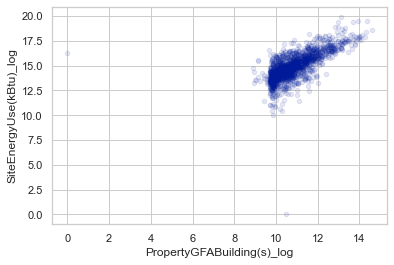

In [272]:
data.plot(kind ='scatter', x ='PropertyGFABuilding(s)_log', y ='SiteEnergyUse(kBtu)_log',\
              alpha = 0.1, c=np.array([0.0, 0.1, 0.6]).reshape(1,-1))


Ce graphique confirme une corrélation très forte : on peut constater une tendance croissante nette.

Maintenant avec les énergies/sf, en ajoutant la distance au centre ville en km :

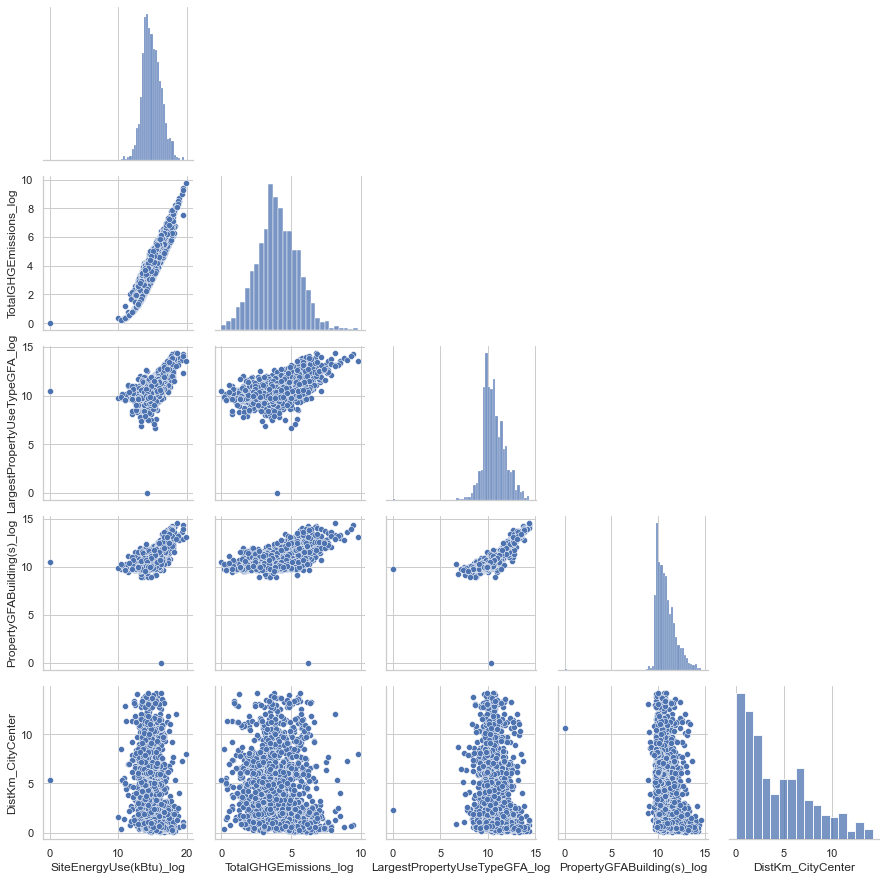

In [273]:
sns.set_context("notebook") # scaling automatique selon type de présentation
data_pairgrid = data.loc[:,['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log', 'LargestPropertyUseTypeGFA_log',
                            'PropertyGFABuilding(s)_log', 'DistKm_CityCenter']]
g = sns.PairGrid(data_pairgrid, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(.55, .95))

On ne note pas de corrélation forte avec la distance au centre ville

### 5.2.3 | ANOVA | SiteEnergyUse(kBTU) / TotalGHGEmissions vs PrimaryPropertyType / BuildingType

Nous allons tenter de répondre à la question suivante : la valeur de **'SiteEnergyUse(kBTU)_log'** est-elle différente d'une **modalité de 'PrimaryPropertyType' à l'autre?**. Nous renouvellerons la question pour **TotalGHGEmissions_log**.

In [274]:
data.head(5)

BuildingType PrimaryPropertyType  YearBuilt  \
OSEBuildingID_DataYear                                                  
25042_2015              NonResidential               Other       1966   
24904_2015              NonResidential  Mixed Use Property       1928   
25455_2015              NonResidential               Other       1922   
25654_2015              NonResidential        Retail Store       1900   
23163_2015              NonResidential      Medical Office       1995   

                        NumberofBuildings  NumberofFloors  \
OSEBuildingID_DataYear                                      
25042_2015                            1.0             2.0   
24904_2015                            1.0             2.0   
25455_2015                            1.0             1.0   
25654_2015                            1.0             2.0   
23163_2015                            1.0             4.0   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   
23163_2015                                          Medical Office   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25042_2015                                  Parking   
24904_2015                                      nan   
25455_2015                                      nan   
25654_2015                                      nan   
23163_2015                                      nan   

                       ThirdLargestPropertyUseType  ENERGYSTARScore ZipCode  \
OSEBuildingID_DataYear                                                        
25042_2015                                     nan              NaN   98144   
24904_2015                                     nan              NaN   98119   
25455_2015                                     nan              NaN   98109   
25654_2015                                     nan              NaN   98104   
23163_2015                                     nan             76.0   98144   

                        DistKm_CityCenter ENERGYSTAR_Color  \
OSEBuildingID_DataYear                                       
25042_2015                          2.606              NaN   
24904_2015                          4.549              NaN   
25455_2015                          2.300              NaN   
25654_2015                          0.811              NaN   
23163_2015                          1.537            Green   

                        PropertyGFATotal_log  PropertyGFAParking_log  \
OSEBuildingID_DataYear                                                 
25042_2015                         10.000977                0.000000   
24904_2015                          9.368711                0.000000   
25455_2015                          9.372969                0.000000   
25654_2015                          9.241451                0.000000   
23163_2015                         10.389887               10.047025   

                        PropertyGFABuilding(s)_log  \
OSEBuildingID_DataYear                               
25042_2015                               10.298801   
24904_2015                                9.871223   
25455_2015                                9.873801   
25654_2015                                9.796181   
23163_2015                                9.746366   

                        LargestPropertyUseTypeGFA_log  \
OSEBuildingID_DataYear                                  
25042_2015                                  10.228357   
24904_2015                                   9.761060   
25455_2015                                   9.763938   
25654_2015                                   9.6769

#### 5.2.3.1 | ANOVA 'SiteEnergyUse(kBTU)_log' est-elle différente d'une modalité de 'PrimaryPropertyType'

In [275]:
X = "PrimaryPropertyType" # qualitative
Y = "SiteEnergyUse(kBtu)_log" # quantitative

# On crée le sous-échantillon (pas de filtre particulier ici)
sous_echantillon = data[[X,Y]].dropna(how='any').copy()

In [276]:
sous_echantillon

PrimaryPropertyType  SiteEnergyUse(kBtu)_log
OSEBuildingID_DataYear                                                      
25042_2015                                    Other                13.312785
24904_2015                       Mixed Use Property                13.196927
25455_2015                                    Other                15.258813
25654_2015                             Retail Store                11.751508
23163_2015                           Medical Office                14.370411
...                                             ...                      ...
20985_2016                                    Other                12.887856
20986_2016                                Warehouse                14.358590
20987_2016              Small- and Mid-Sized Office                14.363624
20988_2016              Small- and Mid-Sized Office                14.666610
50226_2016                       Mixed Use Property                13.906962

[1548 rows x 2 columns]

In [277]:
# On calcule le rapport de corrélation eta carré pour l'afficher ensuite
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.3949505505132092

Affichons le graphique :

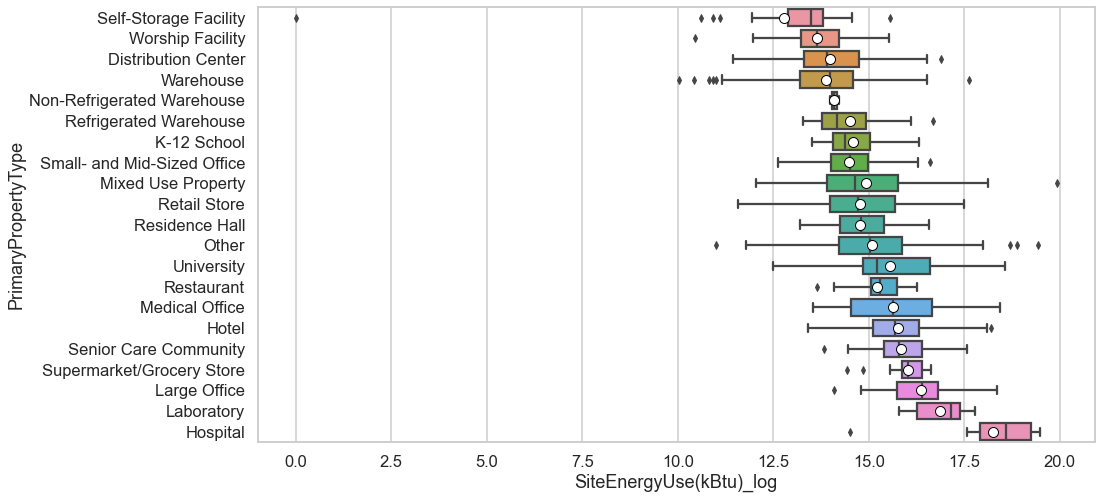

le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) :  0.39


In [278]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

# On se prépare à classer les boxplot par la médiane
my_order = sous_echantillon.groupby(by=[X])[Y].median().sort_values().iloc[::1].index

fig,ax = plt.subplots(figsize=(15,8))

# On affiche les boxplots et on matérialise la moyenne par un point blanc
sns.boxplot(x=Y, y=X, showmeans=True, data=sous_echantillon, order=my_order,\
           meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"})

plt.show()

print('le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) : ' ,\
      round(eta_squared(sous_echantillon[X],sous_echantillon[Y]),2))

On constate une corrélation significative à l'augmentation du SiteEnergyUse(kBtu)_log (médiane)  selon l'ordonnancement ci-dessus.<br>
S'il existe bien des **catégories PrimaryPropertyType** pour lesquelles le **SiteEnergyUse(kBtu)_log est plus élevé** et à l'inverse **d'autres pour lequel il est plus bas**, l'écart-type est large, au point qu'il est difficile de distinguer une relation franche pour la plupart des cas.

La relation semble toutefois **significative**, comme l'indique le **rapport de corrélation eta carré de 0.37**.

#### 5.2.3.2 | ANOVA 'TotalGHGEmissions_log.' est-elle différente d'une modalité de 'PrimaryPropertyType'

In [279]:
X = "PrimaryPropertyType" # qualitative
Y = "TotalGHGEmissions_log" # quantitative

# On crée le sous-échantillon (pas de filtre particulier ici)
sous_echantillon = data[[X,Y]].dropna(how='any').copy()

In [280]:
sous_echantillon

PrimaryPropertyType  TotalGHGEmissions_log
OSEBuildingID_DataYear                                                    
25042_2015                                    Other               3.151881
24904_2015                       Mixed Use Property               2.844328
25455_2015                                    Other               4.926021
25654_2015                             Retail Store               0.631272
23163_2015                           Medical Office               2.575661
...                                             ...                    ...
20985_2016                                    Other               1.324419
20986_2016                                Warehouse               4.180675
20987_2016              Small- and Mid-Sized Office               3.837084
20988_2016              Small- and Mid-Sized Office               4.413525
50226_2016                       Mixed Use Property               3.734570

[1548 rows x 2 columns]

In [281]:
# On calcule le rapport de corrélation eta carré pour l'afficher ensuite
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.3310753846399276

Affichons le graphique :

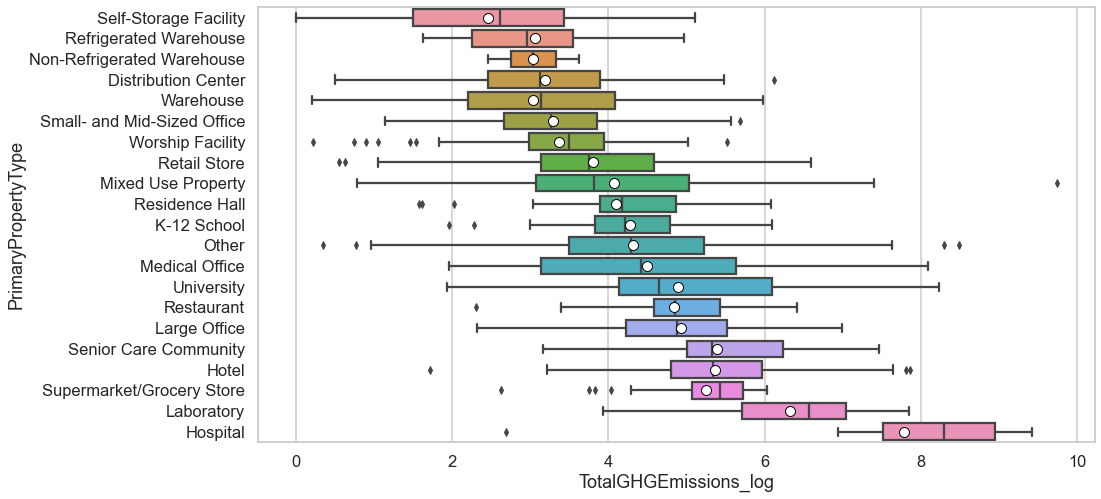

le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) :  0.33


In [282]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

# On se prépare à classer les boxplot par la médiane
my_order = sous_echantillon.groupby(by=[X])[Y].median().sort_values().iloc[::1].index

fig,ax = plt.subplots(figsize=(15,8))

# On affiche les boxplots et on matérialise la moyenne par un point blanc
sns.boxplot(x=Y, y=X, showmeans=True, data=sous_echantillon, order=my_order,\
           meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"})

plt.show()

print('le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) : ' ,\
      round(eta_squared(sous_echantillon[X],sous_echantillon[Y]),2))

On constate une corrélation significative à l'augmentation du TotalGHGEmissions_log (médiane)  selon l'ordonnancement ci-dessus.<br>
S'il existe bien des **catégories PrimaryPropertyType** pour lesquelles le **TotalGHGEmissions_log est plus élevé** et à l'inverse **d'autres pour lequel il est plus bas**, l'écart-type est large, au point qu'il est difficile de distinguer une relation franche pour la plupart des cas.

La relation semble toutefois **significative**, comme l'indique le **rapport de corrélation eta carré de 0.33**.

#### 5.2.3.3 | ANOVA 'SiteEnergyUse(kBTU)_log' est-elle différente d'une modalité de 'BuildingType'

In [283]:
X = "BuildingType" # qualitative
Y = "SiteEnergyUse(kBtu)_log" # quantitative

# On crée le sous-échantillon (pas de filtre particulier ici)
sous_echantillon = data[[X,Y]].dropna(how='any').copy()

In [284]:
sous_echantillon

BuildingType  SiteEnergyUse(kBtu)_log
OSEBuildingID_DataYear                                             
25042_2015                  NonResidential                13.312785
24904_2015                  NonResidential                13.196927
25455_2015                  NonResidential                15.258813
25654_2015                  NonResidential                11.751508
23163_2015                  NonResidential                14.370411
...                                    ...                      ...
20985_2016                  NonResidential                12.887856
20986_2016                  NonResidential                14.358590
20987_2016                  NonResidential                14.363624
20988_2016                  NonResidential                14.666610
50226_2016              Nonresidential COS                13.906962

[1548 rows x 2 columns]

In [285]:
# On calcule le rapport de corrélation eta carré pour l'afficher ensuite
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.02464971259556095

Affichons le graphique :

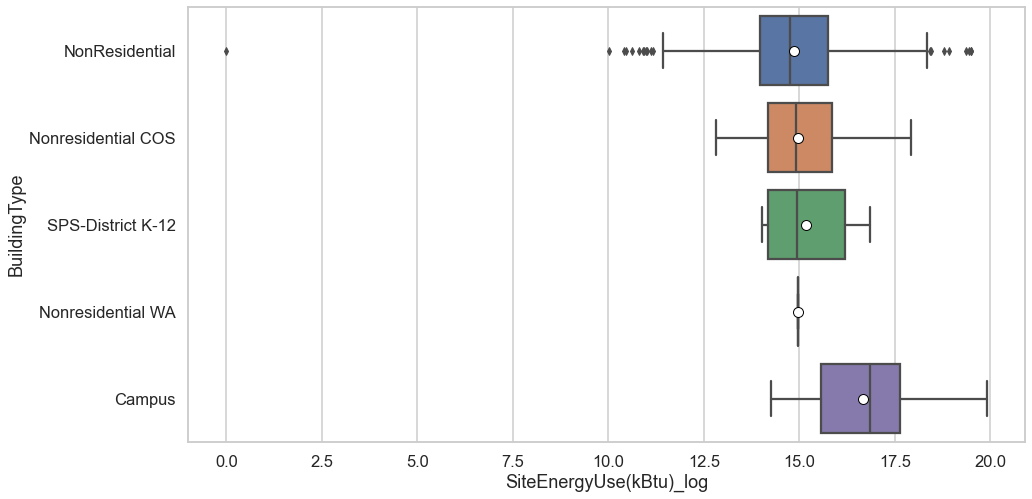

le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) :  0.02


In [286]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

# On se prépare à classer les boxplot par la médiane
my_order = sous_echantillon.groupby(by=[X])[Y].median().sort_values().iloc[::1].index

fig,ax = plt.subplots(figsize=(15,8))

# On affiche les boxplots et on matérialise la moyenne par un point blanc
sns.boxplot(x=Y, y=X, showmeans=True, data=sous_echantillon, order=my_order,\
           meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"})

plt.show()

print('le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) : ' ,\
      round(eta_squared(sous_echantillon[X],sous_echantillon[Y]),2))

On constate une **corrélation peu significative** à l'augmentation du SiteEnergyUse(kBtu)_log (médiane)  selon l'ordonnancement ci-dessus, comme l'indique le **rapport de corrélation eta carré de 0.02**.

#### 5.2.3.4 | ANOVA 'TotalGHGEmissions_log.' est-elle différente d'une modalité de 'BuildingType'

In [287]:
X = "BuildingType" # qualitative
Y = "TotalGHGEmissions_log" # quantitative

# On crée le sous-échantillon (pas de filtre particulier ici)
sous_echantillon = data[[X,Y]].dropna(how='any').copy()

In [288]:
sous_echantillon

BuildingType  TotalGHGEmissions_log
OSEBuildingID_DataYear                                           
25042_2015                  NonResidential               3.151881
24904_2015                  NonResidential               2.844328
25455_2015                  NonResidential               4.926021
25654_2015                  NonResidential               0.631272
23163_2015                  NonResidential               2.575661
...                                    ...                    ...
20985_2016                  NonResidential               1.324419
20986_2016                  NonResidential               4.180675
20987_2016                  NonResidential               3.837084
20988_2016                  NonResidential               4.413525
50226_2016              Nonresidential COS               3.734570

[1548 rows x 2 columns]

In [289]:
# On calcule le rapport de corrélation eta carré pour l'afficher ensuite
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.03383222256791929

Affichons le graphique :

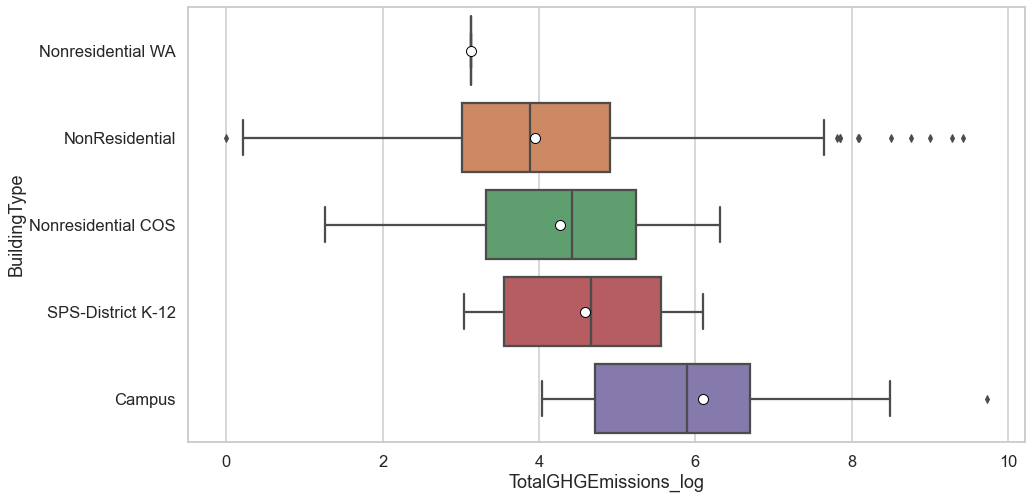

le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) :  0.03


In [290]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')

# On se prépare à classer les boxplot par la médiane
my_order = sous_echantillon.groupby(by=[X])[Y].median().sort_values().iloc[::1].index

fig,ax = plt.subplots(figsize=(15,8))

# On affiche les boxplots et on matérialise la moyenne par un point blanc
sns.boxplot(x=Y, y=X, showmeans=True, data=sous_echantillon, order=my_order,\
           meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"})

plt.show()

print('le rapport de corrélation eta carré est égal à (0 pas de relation - 1 forte correlation) : ' ,\
      round(eta_squared(sous_echantillon[X],sous_echantillon[Y]),2))

On constate une corrélation peu significative à l'augmentation du TotalGHGEmissions_log (médiane)  selon l'ordonnancement ci-dessus, comme l'indique le **rapport de corrélation eta carré de 0.03**.

#### 5.2.3.5 | ANOVA multiples

In [291]:
data.shape

(1548, 23)

In [292]:
data_num

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'DistKm_CityCenter',
 'PropertyGFATotal_log',
 'PropertyGFAParking_log',
 'PropertyGFABuilding(s)_log',
 'LargestPropertyUseTypeGFA_log',
 'SecondLargestPropertyUseTypeGFA_log',
 'ThirdLargestPropertyUseTypeGFA_log',
 'SiteEnergyUse(kBtu)_log',
 'TotalGHGEmissions_log',
 'SteamUse_Perc_log',
 'Electricity_Perc_log',
 'NaturalGas_Perc_log']

In [293]:
data_cat

['BuildingType',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ZipCode']

In [294]:
categories = data_cat

In [295]:
var_target = ['SiteEnergyUse(kBtu)_log','TotalGHGEmissions_log']

Nous allons récupérer les **eta carré** de plusieurs comparaisons via une fonction ANOVA.<br>
Un premier jet pour la variable cible 'SiteEnergyUse(kBTU)_log', et un second jet pour l'autre variable cible 'TotalGHGEmissions_log'

In [296]:
# création de la fonction Anova (target, cat) qui va réaliser
# les Anova pour chaque variable cible et variable catégorielle
# et renvoyer les eta carrés correspondants

# On définit le rapport de corrélation eta carré pour l'afficher ensuite dans la fonction Anova
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y]) # somme des carrés totale
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes]) # somme des carrés expliquée
    return SCE/SCT

    
list_vars_test = []
list_eta = []

def Anova(cat, target):
    print("Category_vs_Target : eta_carré")
    print("-"*50)
    for t in target: 
        Y = t # quantitative target
        for c in cat:
            X = c # qualitative category
#           On crée le sous-échantillon (pas de filtre particulier ici)
            sous_echantillon = data[[X,Y]].dropna(how='any').copy()
            list_vars_test.append(c+"_vs_"+t)
            list_eta.append(eta_squared(sous_echantillon[X],sous_echantillon[Y]))
            
    rank_var = {}         
    for i in range(len(list_vars_test)):
        print(list_vars_test[i]," : ",round(list_eta[i],4))
        rank_var.update({str(list_vars_test[i]):round(list_eta[i],4)})
        rank_var_df = pd.DataFrame.from_dict(rank_var, orient = 'index')
        rank_var_df.columns = ['eta_carré']
    return rank_var_df.sort_values(by='eta_carré',ascending=False)

In [297]:
df_var_eta = Anova(categories, var_target)

Category_vs_Target : eta_carré
--------------------------------------------------
BuildingType_vs_SiteEnergyUse(kBtu)_log  :  0.0246
PrimaryPropertyType_vs_SiteEnergyUse(kBtu)_log  :  0.395
LargestPropertyUseType_vs_SiteEnergyUse(kBtu)_log  :  0.3181
SecondLargestPropertyUseType_vs_SiteEnergyUse(kBtu)_log  :  0.1403
ThirdLargestPropertyUseType_vs_SiteEnergyUse(kBtu)_log  :  0.0832
ZipCode_vs_SiteEnergyUse(kBtu)_log  :  0.1427
BuildingType_vs_TotalGHGEmissions_log  :  0.0338
PrimaryPropertyType_vs_TotalGHGEmissions_log  :  0.3311
LargestPropertyUseType_vs_TotalGHGEmissions_log  :  0.2819
SecondLargestPropertyUseType_vs_TotalGHGEmissions_log  :  0.0805
ThirdLargestPropertyUseType_vs_TotalGHGEmissions_log  :  0.0589
ZipCode_vs_TotalGHGEmissions_log  :  0.115


In [298]:
df_var_eta

eta_carré
PrimaryPropertyType_vs_SiteEnergyUse(kBtu)_log              0.3950
PrimaryPropertyType_vs_TotalGHGEmissions_log                0.3311
LargestPropertyUseType_vs_SiteEnergyUse(kBtu)_log           0.3181
LargestPropertyUseType_vs_TotalGHGEmissions_log             0.2819
ZipCode_vs_SiteEnergyUse(kBtu)_log                          0.1427
SecondLargestPropertyUseType_vs_SiteEnergyUse(kBtu)_log     0.1403
ZipCode_vs_TotalGHGEmissions_log                            0.1150
ThirdLargestPropertyUseType_vs_SiteEnergyUse(kBtu)_log      0.0832
SecondLargestPropertyUseType_vs_TotalGHGEmissions_log       0.0805
ThirdLargestPropertyUseType_vs_TotalGHGEmissions_log        0.0589
BuildingType_vs_TotalGHGEmissions_log                       0.0338
BuildingType_vs_SiteEnergyUse(kBtu)_log                     0.0246

Cette analyse semble démontrer que les catégories qui présentent les corrélations les plus importantes avec les variables cibles sont :
-  PrimaryPropertyType
-  LargestPropertyUseType

et dans une moindre mesure :
-  ZipCode
-  SecondLargestPropertyUseType

### 5.2.4 | Drop 'ENERGYSTAR_Color' | Step 11

In [299]:
data.head()

BuildingType PrimaryPropertyType  YearBuilt  \
OSEBuildingID_DataYear                                                  
25042_2015              NonResidential               Other       1966   
24904_2015              NonResidential  Mixed Use Property       1928   
25455_2015              NonResidential               Other       1922   
25654_2015              NonResidential        Retail Store       1900   
23163_2015              NonResidential      Medical Office       1995   

                        NumberofBuildings  NumberofFloors  \
OSEBuildingID_DataYear                                      
25042_2015                            1.0             2.0   
24904_2015                            1.0             2.0   
25455_2015                            1.0             1.0   
25654_2015                            1.0             2.0   
23163_2015                            1.0             4.0   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   
23163_2015                                          Medical Office   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25042_2015                                  Parking   
24904_2015                                      nan   
25455_2015                                      nan   
25654_2015                                      nan   
23163_2015                                      nan   

                       ThirdLargestPropertyUseType  ENERGYSTARScore ZipCode  \
OSEBuildingID_DataYear                                                        
25042_2015                                     nan              NaN   98144   
24904_2015                                     nan              NaN   98119   
25455_2015                                     nan              NaN   98109   
25654_2015                                     nan              NaN   98104   
23163_2015                                     nan             76.0   98144   

                        DistKm_CityCenter ENERGYSTAR_Color  \
OSEBuildingID_DataYear                                       
25042_2015                          2.606              NaN   
24904_2015                          4.549              NaN   
25455_2015                          2.300              NaN   
25654_2015                          0.811              NaN   
23163_2015                          1.537            Green   

                        PropertyGFATotal_log  PropertyGFAParking_log  \
OSEBuildingID_DataYear                                                 
25042_2015                         10.000977                0.000000   
24904_2015                          9.368711                0.000000   
25455_2015                          9.372969                0.000000   
25654_2015                          9.241451                0.000000   
23163_2015                         10.389887               10.047025   

                        PropertyGFABuilding(s)_log  \
OSEBuildingID_DataYear                               
25042_2015                               10.298801   
24904_2015                                9.871223   
25455_2015                                9.873801   
25654_2015                                9.796181   
23163_2015                                9.746366   

                        LargestPropertyUseTypeGFA_log  \
OSEBuildingID_DataYear                                  
25042_2015                                  10.228357   
24904_2015                                   9.761060   
25455_2015                                   9.763938   
25654_2015                                   9.6769

In [300]:
var_to_drop = ['ENERGYSTAR_Color']

In [301]:
# on retire les item de la liste data_num
data_cat = [ele for ele in data_cat if ele not in var_to_drop]

In [302]:
data.drop(var_to_drop, axis=1, inplace = True)

In [303]:
data_count_11 = data.count().sum()
data_shape_11 = data.shape
data_nan_11 = data.isnull().sum().sum()
step_11 = "Drop EnergyStar_Color & other variables"
nb_steps += 1

## 5.3 | Analyse des variables à prédire

Les 2 variables à prédire sont : 
-  TotalGHGEmissions
-  SiteEnergyUse(kBtu)

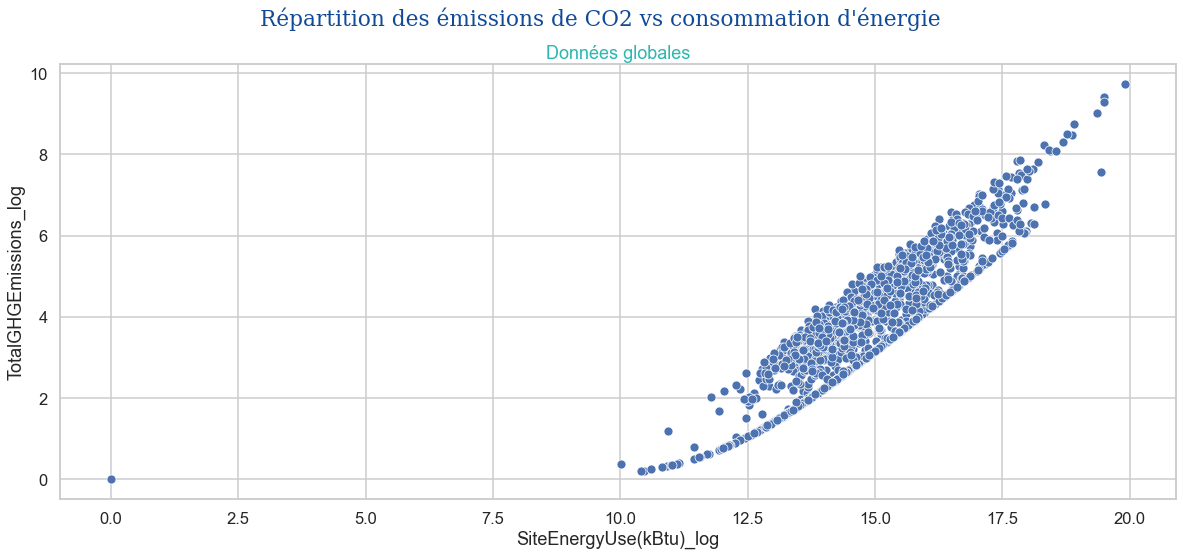

In [304]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, x="SiteEnergyUse(kBtu)_log", y="TotalGHGEmissions_log", ax=axes)
axes.set_title("Données globales", color='#2cb7b0')
plt.suptitle("Répartition des émissions de CO2 vs consommation d'énergie", fontdict=font_title)
plt.show()

On identifie bien une relation forte et croissante entre ces deux variables.<br>
Nous avons déjà vu que ces distributions ne suivaient pas une loi normale.<br>
Observons maintenant leur interaction avec certaines variables.

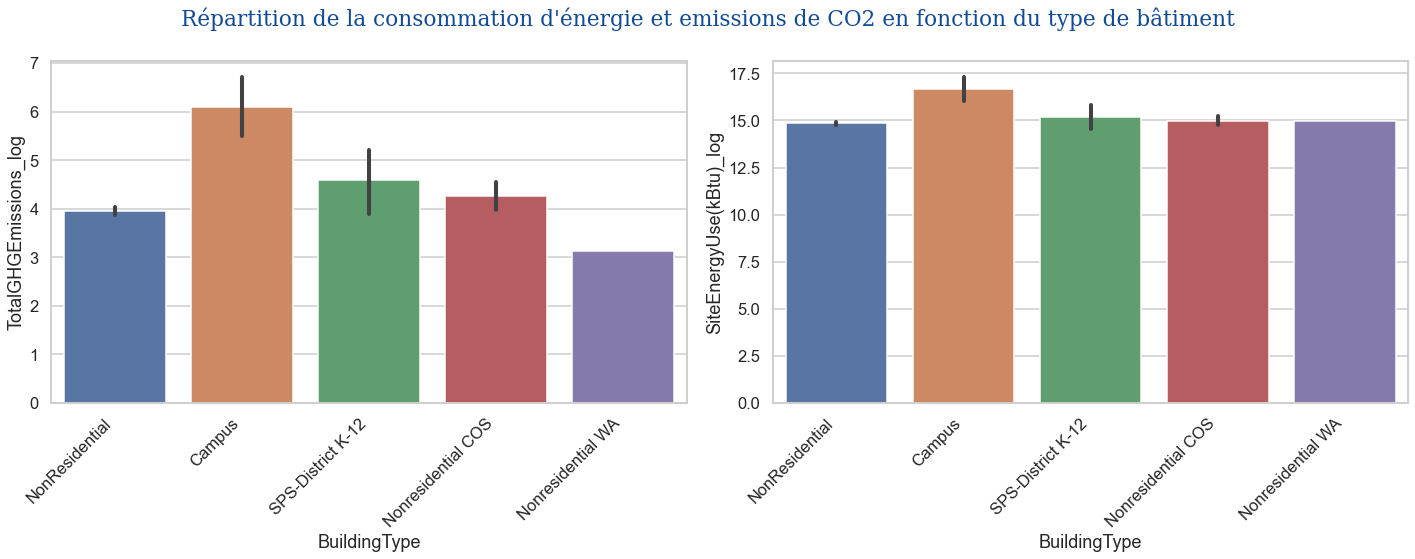

In [305]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
chart1=sns.barplot(x='BuildingType',y='TotalGHGEmissions_log',data=data, ax=axes[0])
chart2=sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)_log',data=data, ax=axes[1])
plt.suptitle("Répartition de la consommation d'énergie et emissions de CO2 en fonction du type de bâtiment", 
             fontdict=font_title)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

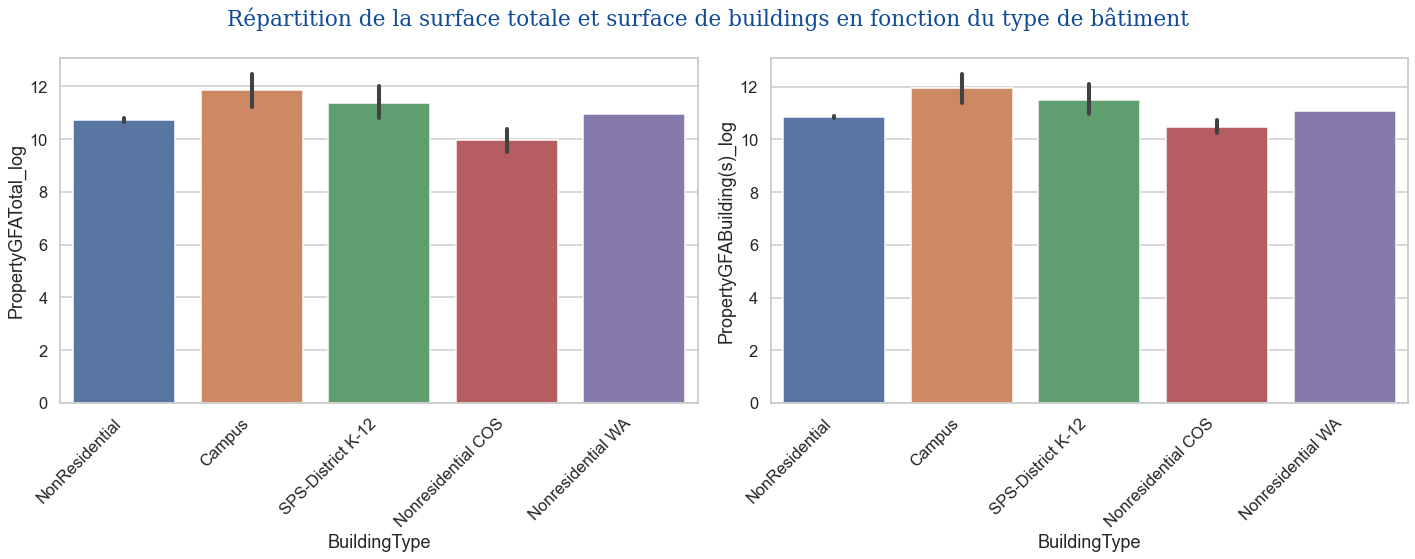

In [306]:
sns.set_context("talk") # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
chart1=sns.barplot(x='BuildingType',y='PropertyGFATotal_log',data=data, ax=axes[0])
chart2=sns.barplot(x='BuildingType',y='PropertyGFABuilding(s)_log',data=data, ax=axes[1])
plt.suptitle("Répartition de la surface totale et surface de buildings en fonction du type de bâtiment", 
             fontdict=font_title)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()
plt.show()

On constate que les campus représentent à la fois la plus grande surface totale et de buildings, et que parallèlement ils regroupent aussi les plus grandes émissions de GHG (Green House Gaz) et consommation d'énergie.

## 5.4 | Préparation données ML | One Hot Encoding | Step 12

##### Sélection de la variable à encoder via One Hot Encoder

In [307]:
data[data_cat].head()

BuildingType PrimaryPropertyType  \
OSEBuildingID_DataYear                                       
25042_2015              NonResidential               Other   
24904_2015              NonResidential  Mixed Use Property   
25455_2015              NonResidential               Other   
25654_2015              NonResidential        Retail Store   
23163_2015              NonResidential      Medical Office   

                                            LargestPropertyUseType  \
OSEBuildingID_DataYear                                               
25042_2015              Outpatient Rehabilitation/Physical Therapy   
24904_2015                                      Mixed Use Property   
25455_2015                                   Automobile Dealership   
25654_2015                                            Retail Store   
23163_2015                                          Medical Office   

                       SecondLargestPropertyUseType  \
OSEBuildingID_DataYear                                
25042_2015                                  Parking   
24904_2015                                      nan   
25455_2015                                      nan   
25654_2015                                      nan   
23163_2015                                      nan   

                       ThirdLargestPropertyUseType ZipCode  
OSEBuildingID_DataYear                                      
25042_2015                                     nan   98144  
24904_2015                                     nan   98119  
25455_2015                                     nan   98109  
25654_2015                                     nan   98104  
23163_2015                                     nan   98144

In [308]:
print("nombre de modes par feature :")
print("-"*35)
for col in data_cat:
    print(col,":",len(data[col].unique()))

nombre de modes par feature :
-----------------------------------
BuildingType : 5
PrimaryPropertyType : 21
LargestPropertyUseType : 58
SecondLargestPropertyUseType : 47
ThirdLargestPropertyUseType : 40
ZipCode : 44


**PrimaryPropertyType :**<br>
Pour rappel, le résultat des ANOVA multiples montrait que les principales variables catégorielles corrélées avec les variables cibles étaient : 

-  PrimaryPropertyType
-  LargestPropertyUseType

Nous allons **uniquement encoder PrimaryPropertyType**, la variable la **plus corrélée** des deux, et celle qui compte aussi le **plus petit nombre de modes**, pour éviter le fléau de la dimensionalité (et ne pas avoir assez d'invididus pour modéliser). Nous pourrons ainsi utiliser ces valeurs textuelles de manière numérique avec les modèles de ML.<br>

Si le besoin s'en faisait sentir, nous encoderons dans un second temps également la variable **LargestPropertyType** pour tenter d'améliorer la performance du modèle de prédiction.

In [309]:
data.PrimaryPropertyType.unique()

array(['Other', 'Mixed Use Property', 'Retail Store', 'Medical Office',
       'Restaurant', 'Small- and Mid-Sized Office', 'Large Office',
       'Non-Refrigerated Warehouse', 'K-12 School', 'Worship Facility',
       'Distribution Center', 'Warehouse', 'Self-Storage Facility',
       'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'University', 'Senior Care Community', 'Hotel', 'Hospital',
       'Residence Hall', 'Laboratory'], dtype=object)

##### Encodage de 'PrimaryPropertyType'

Utilisons la méthode get_dummies de pandas pour effectuer le one hot encoder depuis le dataframe.

In [310]:
PrimPropType = pd.get_dummies(data['PrimaryPropertyType'], prefix='PropType')

In [311]:
PrimPropType

PropType_Distribution Center  PropType_Hospital  \
OSEBuildingID_DataYear                                                    
25042_2015                                         0                  0   
24904_2015                                         0                  0   
25455_2015                                         0                  0   
25654_2015                                         0                  0   
23163_2015                                         0                  0   
...                                              ...                ...   
20985_2016                                         0                  0   
20986_2016                                         0                  0   
20987_2016                                         0                  0   
20988_2016                                         0                  0   
50226_2016                                         0                  0   

                        PropType_Hotel  PropType_K-12 School  \
OSEBuildingID_DataYear                                         
25042_2015                           0                     0   
24904_2015                           0                     0   
25455_2015                           0                     0   
25654_2015                           0                     0   
23163_2015                           0                     0   
...                                ...                   ...   
20985_2016                           0                     0   
20986_2016                           0                     0   
20987_2016                           0                     0   
20988_2016                           0                     0   
50226_2016                           0                     0   

                        PropType_Laboratory  PropType_Large Office  \
OSEBuildingID_DataYear                                               
25042_2015                                0                      0   
24904_2015                                0                      0   
25455_2015                                0                      0   
25654_2015                                0                      0   
23163_2015                                0                      0   
...                                     ...                    ...   
20985_2016                                0                      0   
20986_2016                                0                      0   
20987_2016                                0                      0   
20988_2016                                0                      0   
50226_2016                                0                      0   

                        PropType_Medical Office  PropType_Mixed Use Property  \
OSEBuildingID_DataYear                                                         
25042_2015                                    0                            0   
24904_2015                                    0                            1   
25455_2015                                    0                            0   
25654_2015                                    0                            0   
23163_2015                                    1                            0   
...                                         ...                          ...   
20985_2016                                    0                            0   
20986_2016                                    0                            0   
20987_2016                                    0                            0   
20988_2016                                    0                            0   
50226_2016                                    0                            1   

                        PropType_Non-Refrigerated Warehouse  PropType_Other  \
OSEBuildingID_DataYear                                                        
25042_2015                                                0               1   
24904_2015                

Nous allons maintenant ajouter ces colonnes à 'data' et retirer les colonnes non encodées :

In [312]:
# on concatène data et PrimPropType sur les colonnes
data = pd.concat([data,PrimPropType], axis = 1, copy=False)

In [313]:
data.drop(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType',\
           'ThirdLargestPropertyUseType'], axis=1, inplace=True)

In [314]:
data_count_12 = data.count().sum()
data_shape_12 = data.shape
data_nan_12 = data.isnull().sum().sum()
step_12 = "One Hot Encoding"
nb_steps += 1

##### Mise à jour des variables **data_num** et **data_cat**

In [315]:
data_num = [i for i in data_num if i in data.columns]

In [316]:
data_cat = [i for i in data_cat if i in data.columns]

In [317]:
data.shape[1] - (len(data_num)+len(data_cat))

21

In [318]:
result = [i for i in data.columns if i not in data_num and i not in data_cat]

In [319]:
result

['PropType_Distribution Center',
 'PropType_Hospital',
 'PropType_Hotel',
 'PropType_K-12 School',
 'PropType_Laboratory',
 'PropType_Large Office',
 'PropType_Medical Office',
 'PropType_Mixed Use Property',
 'PropType_Non-Refrigerated Warehouse',
 'PropType_Other',
 'PropType_Refrigerated Warehouse',
 'PropType_Residence Hall',
 'PropType_Restaurant',
 'PropType_Retail Store',
 'PropType_Self-Storage Facility',
 'PropType_Senior Care Community',
 'PropType_Small- and Mid-Sized Office',
 'PropType_Supermarket/Grocery Store',
 'PropType_University',
 'PropType_Warehouse',
 'PropType_Worship Facility']

In [320]:
data_cat.extend(result)

In [321]:
data.shape[1] - (len(data_num)+len(data_cat))

0

Le jeu de données data est bien **identifié** avec des **données numériques** et des **données catégorielles**.

# 6 | Etapes du nettoyage et préparation des données

## 6.1 | Etapes du nettoyage | données chiffrées

In [322]:
data_step_prep = []
data_count_prep = []
data_rows_prep = []
data_columns_prep = []
data_nan_prep = []

print("Les différentes étapes de filtrage et nettoyage sont :\n")
for i in range (nb_steps + 1):
    if i == 0:
        print(i,"|", eval("step_"+str(i))," :\n",eval("data_shape_"+str(i)))
        print(eval("data_nan_"+str(i))," NaN")
        print('\n')
        data_step_prep.append(" ".join(map(str, [i,"|",eval("step_"+str(i))])))
        data_count_prep.append(eval("data_count_"+str(i)))
        data_rows_prep.append(eval("data_shape_"+str(i))[0])
        data_columns_prep.append(eval("data_shape_"+str(i))[1])
        data_nan_prep.append(eval("data_nan_"+str(i)))
    else:
        print(i,"|", eval("step_"+str(i))," :\n",eval("data_shape_"+str(i)),\
              eval("data_shape_"+str(i))[0]-eval("data_shape_"+str(i-1))[0]," lignes, et ",\
              eval("data_shape_"+str(i))[1]-eval("data_shape_"+str(i-1))[1]," colonnes,\n soit",\
              "{}% du total des lignes,\n".format(round((eval("data_shape_"+str(i))[0]-eval("data_shape_"+str(i-1))[0])\
                                                                /data_shape_0[0]*100,2)),
               "{}% du total des colonnes,\n".format(round((eval("data_shape_"+str(i))[1]-eval("data_shape_"+str(i-1))[1])\
                                                                /data_shape_0[1]*100,2)),
              "{} NaN, soit {}% du total NaN initial".format(eval("data_nan_"+str(i))-eval("data_nan_"+str(i-1)),\
              round(100*(eval("data_nan_"+str(i))-eval("data_nan_"+str(i-1)))/eval("data_nan_"+str(0)),2)
             ))
        data_step_prep.append(" ".join(map(str, [i,"|",eval("step_"+str(i))])))
        data_count_prep.append(eval("data_count_"+str(i)))
        data_rows_prep.append(eval("data_shape_"+str(i))[0])
        data_columns_prep.append(eval("data_shape_"+str(i))[1])
        data_nan_prep.append(eval("data_nan_"+str(i)))
                
        print('\n')

print("A ce stade {}% des lignes,".format(round(100-eval("data_shape_"+str(i))[0]/data_shape_0[0]*100,2)))
print("et {}% des colonnes ont été écartées.".format(round(100-eval("data_shape_"+str(i))[1]/data_shape_0[1]*100,2)))

Les différentes étapes de filtrage et nettoyage sont :

0 | jeu de données initial  :
 (6716, 45)
33504  NaN


1 | colonne ZipCode  :
 (6716, 45) 0  lignes, et  0  colonnes,
 soit 0.0% du total des lignes,
 0.0% du total des colonnes,
 -9218 NaN, soit -27.51% du total NaN initial


2 | suppression doublons OSEBuildingID  :
 (3432, 45) -3284  lignes, et  0  colonnes,
 soit -48.9% du total des lignes,
 0.0% du total des colonnes,
 -11967 NaN, soit -35.72% du total NaN initial


3 | Ecart SiteEnergyUse vs calculé, Compliance  :
 (3224, 50) -208  lignes, et  5  colonnes,
 soit -3.1% du total des lignes,
 11.11% du total des colonnes,
 -900 NaN, soit -2.69% du total NaN initial


4 | sélection colonnes analyse  :
 (3224, 28) 0  lignes, et  -22  colonnes,
 soit 0.0% du total des lignes,
 -48.89% du total des colonnes,
 -3119 NaN, soit -9.31% du total NaN initial


5 | fillna(0), cols manquants  :
 (3224, 28) 0  lignes, et  0  colonnes,
 soit 0.0% du total des lignes,
 0.0% du total des colon

In [323]:
# Création d'un dataframe pour grapher l'évolution de ces grandeurs liées au nettoyage
data_step = pd.Series(data_step_prep) 
data_count = pd.Series(data_count_prep)
data_rows = pd.Series(data_rows_prep)
data_columns = pd.Series(data_columns_prep)
data_nan = pd.Series(data_nan_prep)
  
frame = { 'Step': data_step, 'Count': data_count, 'Rows': data_rows, \
         'Columns': data_columns, 'Nan': data_nan  } 

data_cleaning = pd.DataFrame(frame)

data_cleaning['Count_base100'] = round(data_cleaning.Count / data_cleaning.Count[0] * 100, 2)
data_cleaning['Rows_base100'] = round(data_cleaning.Rows / data_cleaning.Rows[0] * 100, 2)
data_cleaning['Columns_base100'] = round(data_cleaning.Columns / data_cleaning.Columns[0] * 100, 2)
data_cleaning['Nan_base100'] = round(data_cleaning.Nan / data_cleaning.Nan[0] * 100, 2)

In [324]:
data_cleaning

Step   Count  Rows  Columns  \
0                       0 | jeu de données initial  268716  6716       45   
1                              1 | colonne ZipCode  277934  6716       45   
2           2 | suppression doublons OSEBuildingID  142121  3432       45   
3   3 | Ecart SiteEnergyUse vs calculé, Compliance  149781  3224       50   
4                   4 | sélection colonnes analyse   81972  3224       28   
5                    5 | fillna(0), cols manquants   86235  3224       28   
6             6 | filtre bâtiments hors habitation   41350  1552       28   
7                              7 | filtre outliers   41295  1550       27   
8                    8 | Taux manquants numériques   41295  1550       27   
9                        9 | Latitude et Longitude   38179  1549       25   
10         10 | EnergyStar_Color et Passage au Log   39156  1548       26   
11    11 | Drop EnergyStar_Color & other variables   33510  1548       22   
12                           12 | One Hot Encoding   58278  1548       38   

      Nan  Count_base100  Rows_base100  Columns_base100  Nan_base100  
0   33504         100.00        100.00           100.00       100.00  
1   24286         103.43        100.00           100.00        72.49  
2   12319          52.89         51.10           100.00        36.77  
3   11419          55.74         48.00           111.11        34.08  
4    8300          30.51         48.00            62.22        24.77  
5    4037          32.09         48.00            62.22        12.05  
6    2106          15.39         23.11            62.22         6.29  
7     555          15.37         23.08            60.00         1.66  
8     555          15.37         23.08            60.00         1.66  
9     546          14.21         23.06            55.56         1.63  
10   1092          14.57         23.05            57.78         3.26  
11    546          12.47         23.05            48.89         1.63  
12    546          21.69         23.05            84.44         1.63

## 6.2 | Etapes du nettoyage | graphique

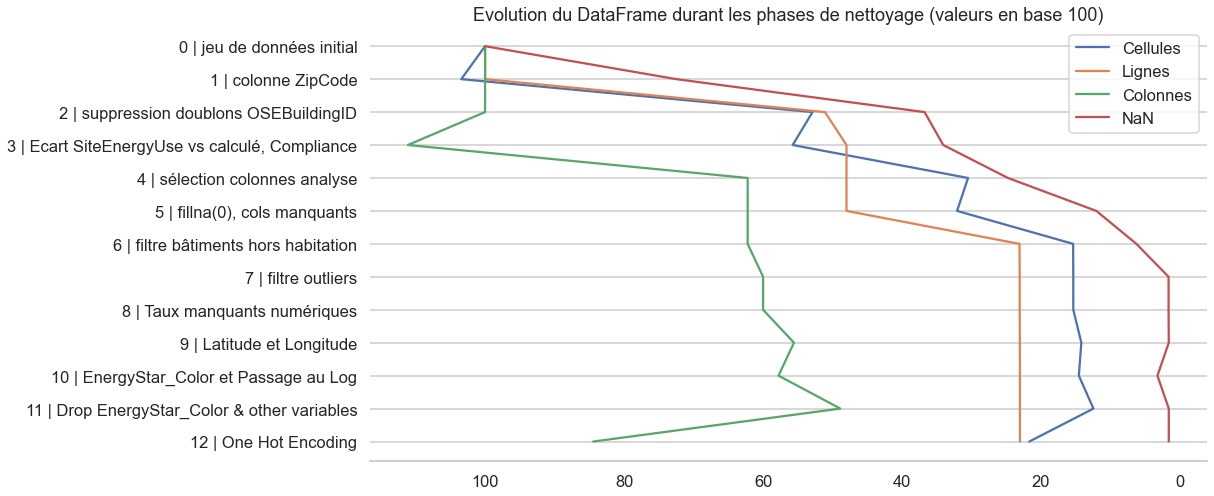

In [325]:
x = data_cleaning.Step
y1 = data_cleaning.Count_base100
y2 = data_cleaning.Rows_base100
y3 = data_cleaning.Columns_base100
y4 = data_cleaning.Nan_base100
fig,ax = plt.subplots(figsize=(15,8))
plt.plot(y1, x, label='Cellules')
plt.plot(y2, x, label='Lignes')
plt.plot(y3, x, label='Colonnes')
plt.plot(y4, x, label='NaN')

plt.title('Evolution du DataFrame durant les phases de nettoyage (valeurs en base 100)')

ax.invert_xaxis()
ax.invert_yaxis()
ax.tick_params(direction='out')
sns.set_theme()
sns.set_style("whitegrid")

sns.set_context("talk") # scaling automatique selon type de présentation ('paper', 'talk', 'poster', 'notebook')
sns.despine(left=True)
plt.legend(loc=0)
plt.grid(axis = 'x')

plt.show()

# 7 | Export pkl des données nettoyées et des listes

### Le jeu de données est maintenant nettoyé, nous pouvons le réindexer et l'exporter en pickle.

In [326]:
len(data.isnull().any(axis=1).index)

1548

In [327]:
# on réindexe le jeu de données
data.reindex()

YearBuilt  NumberofBuildings  NumberofFloors  \
OSEBuildingID_DataYear                                                 
25042_2015                   1966                1.0             2.0   
24904_2015                   1928                1.0             2.0   
25455_2015                   1922                1.0             1.0   
25654_2015                   1900                1.0             2.0   
23163_2015                   1995                1.0             4.0   
...                           ...                ...             ...   
20985_2016                   1970                1.0             1.0   
20986_2016                   1968                1.0             1.0   
20987_2016                   1969                1.0             2.0   
20988_2016                   1969                1.0             2.0   
50226_2016                   1938                1.0             1.0   

                        ENERGYSTARScore ZipCode  DistKm_CityCenter  \
OSEBuildingID_DataYear                                               
25042_2015                          NaN   98144              2.606   
24904_2015                          NaN   98119              4.549   
25455_2015                          NaN   98109              2.300   
25654_2015                          NaN   98104              0.811   
23163_2015                         76.0   98144              1.537   
...                                 ...     ...                ...   
20985_2016                          NaN   98108              6.088   
20986_2016                          NaN   98108              6.225   
20987_2016                          NaN   98108              6.103   
20988_2016                         41.0   98108              6.126   
50226_2016                          NaN   98108              7.926   

                        PropertyGFATotal_log  PropertyGFAParking_log  \
OSEBuildingID_DataYear                                                 
25042_2015                         10.000977                0.000000   
24904_2015                          9.368711                0.000000   
25455_2015                          9.372969                0.000000   
25654_2015                          9.241451                0.000000   
23163_2015                         10.389887               10.047025   
...                                      ...                     ...   
20985_2016                          9.623509                0.000000   
20986_2016                          9.704793                0.000000   
20987_2016                          9.587955                0.000000   
20988_2016                          9.587955                0.000000   
50226_2016                          8.849944                0.000000   

                        PropertyGFABuilding(s)_log  \
OSEBuildingID_DataYear                               
25042_2015                               10.298801   
24904_2015                                9.871223   
25455_2015                                9.873801   
25654_2015                                9.796181   
23163_2015                                9.746366   
...                                            ...   
20985_2016                               10.032980   
20986_2016                               10.087682   
20987_2016                               10.009513   
20988_2016                               10.009513   
50226_2016                                9.590351   

                        LargestPropertyUseTypeGFA_log  \
OSEBuildingID_DataYear                                  
25042_2015                                  10.228357   
24904_2015                                   9.761060   
25455_2015                                   9.763938   
25654_2015                                   9.676901   
23163_2015                                  10.583803   
...                                               ...   
20985_2016                                   9.609452   
20986_2016             

In [328]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1548 entries, 25042_2015 to 50226_2016
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   YearBuilt                             1548 non-null   int64  
 1   NumberofBuildings                     1548 non-null   float64
 2   NumberofFloors                        1548 non-null   float64
 3   ENERGYSTARScore                       1002 non-null   float64
 4   ZipCode                               1548 non-null   object 
 5   DistKm_CityCenter                     1548 non-null   float64
 6   PropertyGFATotal_log                  1548 non-null   float64
 7   PropertyGFAParking_log                1548 non-null   float64
 8   PropertyGFABuilding(s)_log            1548 non-null   float64
 9   LargestPropertyUseTypeGFA_log         1548 non-null   float64
 10  SecondLargestPropertyUseTypeGFA_log   1548 non-null   float64
 11  ThirdLa

### Création de dataframes pour exporter les listes et export en pickle de data, data_num et data_cat

In [329]:
data.shape

(1548, 38)

In [330]:
# on crée deux dataframe pour exporter les listes de variables :
df_data_num = pd.DataFrame (data_num, columns = ['variables'])
df_data_cat = pd.DataFrame (data_cat, columns = ['variables'])

In [331]:
data.to_pickle("data_cleaned.pkl")
df_data_num.to_pickle("data_num.pkl")
df_data_cat.to_pickle("data_cat.pkl")